In [1]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

# import libraries
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot of the graph
from adjustText import adjust_text
from scipy.stats import mode, zscore, median_abs_deviation
import joblib
from sklearn.ensemble import IsolationForest

from helper import draw_confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)


In [2]:
# Load Data
data = pd.read_csv("Data_Raw.csv", header=1)
sites = data['site']

niki = pd.read_csv("Data_Niki.csv")
niki = niki.drop(index=[0,1])
niki['Engineer classification.1'] = (niki['Engineer classification.1'] == 'Release').astype(int)
y = niki['Engineer classification.1']

# Dropping Unnecessary Rows and Columns
# def smart_drop_columns(df):
#     # Exact column names to drop
#     exact_names = {
#         'Source Lot', 'Lot', 'rework_flag', 'Program', 'Wafer Number', 'start_time', 'temperature', 'subid', 'Wafer',
#         'die_x', 'die_y', 'device_nr', 'rom_code', 'hardbin', 'lib_info', 'BinName', 'BinState',
#         'cnt_alarmed_tests', 'cnt_failed_tests', 'cnt_passed_tests', 'cnt_recorded_tests', 'Device_Test_Time',
#         'lot_key', 'wf_key', 'Fab', 'Probecard', 'Testcenter', 'Tester', 'program revision', 'Stage'
#     }

#     # Prefixes to drop
#     prefixes = [
#         'ECID', 'failtest_name', 'failtest_number', 'hardbin_name', 'hardbin_number',
#         'lastfailtest_name', 'lastfailtest_number', 'Part_Id', 'softbin_name', 'softbin_number'
#     ]

#     # Suffix patterns to drop
#     suffixes = [',0,0', ',0,-']

#     # Drop logic
#     columns_to_drop = [
#         col for col in df.columns
#         if col in exact_names
#         or any(col.startswith(prefix) for prefix in prefixes)
#         or any(col.endswith(suffix) for suffix in suffixes)
#         or any(col.startswith(prefix + suffix) for prefix in prefixes for suffix in suffixes)
#     ]

#     return df.drop(columns=columns_to_drop, errors='ignore')

# data = smart_drop_columns(data)
# data = data.apply(pd.to_numeric, errors='coerce')

filtered_ordered_columns = [col for col in niki['Parameter name'] if col in data.columns] # If we want to scale, this line will be removed (is there any way to determine unwanted test parameters)
data = data[filtered_ordered_columns]
data = pd.concat([sites, data], axis=1)
data = data.apply(pd.to_numeric, errors='coerce') 

# Obtaining Median and Std for Each Site and Each Parameter
med = data.groupby('site').median()
std = data.groupby('site').std()

# med = med.fillna(0)
# std = std.fillna(0)

med = med.T.copy()
std = std.T.copy()

med.columns = [f"site{i+1} med" for i in range(med.shape[1])]
std.columns = [f"site{i+1} std" for i in range(std.shape[1])]

x = pd.concat([med, std], axis=1)

C:\Users\nxg15046\AppData\Local\Temp\1\ipykernel_17512\1797234974.py:5: DtypeWarning: Columns (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [3]:
# Standardizing by Row
z_med = med.apply(zscore, axis=1, nan_policy='omit')
z_med = pd.DataFrame(z_med.tolist(), index=med.index, columns=med.columns)
z_std = std.apply(zscore, axis=1, nan_policy='omit')
z_std = pd.DataFrame(z_std.tolist(), index=std.index, columns=std.columns)

# Range (need to remove lower and upper limit)
z_med_min = z_med.min(axis=1)
z_std_min = z_std.min(axis=1)
z_med_max = z_med.max(axis=1)
z_std_max = z_std.max(axis=1)
z_med_range = z_med_max - z_med_min
z_std_range = z_std_max - z_std_min

## Inter-Quartile Range
Q1_med = z_med.quantile(0.25, axis=1)
Q3_med = z_med.quantile(0.75, axis=1)
z_med_iqr = Q3_med - Q1_med
Q1_std = z_std.quantile(0.25, axis=1)
Q3_std = z_med.quantile(0.75, axis=1)
z_std_iqr = Q3_std - Q1_std

## Median Absolute Deviation
z_med_mad = z_med.apply(median_abs_deviation, axis=1)
z_std_mad = z_std.apply(median_abs_deviation, axis=1)

## Skewness
med_skewness = med.skew(axis=1)
std_skewness = std.skew(axis=1)

## Kurtosis (Propensity for Outliers)
med_kurtosis = med.kurt(axis=1)
std_kurtosis = std.kurt(axis=1)

In [4]:
# Concatenating All Features
# y.index = z_med.index
x = pd.concat([z_med_range, z_std_range, z_med_iqr, z_std_iqr, z_med_mad, z_std_mad, med_skewness, std_skewness, med_kurtosis, std_kurtosis], axis=1)

# Assigning New Column Names to Bypass Column Name Repeating Issue
num_columns = x.shape[1]
x.columns = x.columns.astype(str)
new_columns = ["z_med_range", "z_std_range", "z_med_iqr", "z_std_iqr", "z_med_mad", "z_std_mad", "med_skewness", "std_skewness", "med_kurtosis", "std_kurtosis"]
x.columns = new_columns

"""
corr_matrix = x.corr(numeric_only=True)
print(corr_matrix["y"].sort_values(ascending=False))
x = x.drop('y', axis=1)
"""

'\ncorr_matrix = x.corr(numeric_only=True)\nprint(corr_matrix["y"].sort_values(ascending=False))\nx = x.drop(\'y\', axis=1)\n'

In [5]:
# XGB Model Trained with No Imputation
xgb_loaded = joblib.load('pkl files/xgb_raw_noimpute.joblib')
pipeline_noimpute = joblib.load('pkl files/pipeline_noimpute.joblib')

x_transformed = pipeline_noimpute.transform(x)
xgb_predictions = xgb_loaded.predict(x_transformed)

"""
accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))
"""
# draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])

'\naccuracy = metrics.accuracy_score(y, predictions)\nprecision = precision_score(y, predictions, pos_label=0)\nrecall = recall_score(y, predictions, pos_label=0)\nf1 = f1_score(y, predictions, pos_label=0)\n\nprint("%-12s %f" % (\'Test Accuracy:\', accuracy))\nprint("%-12s %f" % (\'Precision:\', precision))\nprint("%-12s %f" % (\'Recall:\', recall))\nprint("%-12s %f" % (\'F1 Score:\', f1))\n'

In [6]:
# RF Model Trained with No Imputation
rf_loaded = joblib.load('pkl files/rf_raw_noimpute.joblib')
pipeline_noimpute = joblib.load('pkl files/pipeline_noimpute.joblib')

x_transformed = pipeline_noimpute.transform(x)
rf_predictions = rf_loaded.predict(x_transformed)

"""
accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))
"""
# draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])

'\naccuracy = metrics.accuracy_score(y, predictions)\nprecision = precision_score(y, predictions, pos_label=0)\nrecall = recall_score(y, predictions, pos_label=0)\nf1 = f1_score(y, predictions, pos_label=0)\n\nprint("%-12s %f" % (\'Test Accuracy:\', accuracy))\nprint("%-12s %f" % (\'Precision:\', precision))\nprint("%-12s %f" % (\'Recall:\', recall))\nprint("%-12s %f" % (\'F1 Score:\', f1))\n'

In [7]:
# DT Model Trained with No Imputation
dt_loaded = joblib.load('pkl files/dt_raw_noimpute.joblib')
pipeline_noimpute = joblib.load('pkl files/pipeline_noimpute.joblib')

x_transformed = pipeline_noimpute.transform(x)
dt_predictions = dt_loaded.predict(x_transformed)

"""
accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))
"""
# draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])

'\naccuracy = metrics.accuracy_score(y, predictions)\nprecision = precision_score(y, predictions, pos_label=0)\nrecall = recall_score(y, predictions, pos_label=0)\nf1 = f1_score(y, predictions, pos_label=0)\n\nprint("%-12s %f" % (\'Test Accuracy:\', accuracy))\nprint("%-12s %f" % (\'Precision:\', precision))\nprint("%-12s %f" % (\'Recall:\', recall))\nprint("%-12s %f" % (\'F1 Score:\', f1))\n'

In [8]:
# LGBM Model Trained with No Imputation
lgbm_loaded = joblib.load('pkl files/lgbm_raw_noimpute.joblib')
pipeline_noimpute = joblib.load('pkl files/pipeline_noimpute.joblib')

x_transformed = pipeline_noimpute.transform(x)
lgbm_predictions = lgbm_loaded.predict(x_transformed)

"""
accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))
"""
# draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])

c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


'\naccuracy = metrics.accuracy_score(y, predictions)\nprecision = precision_score(y, predictions, pos_label=0)\nrecall = recall_score(y, predictions, pos_label=0)\nf1 = f1_score(y, predictions, pos_label=0)\n\nprint("%-12s %f" % (\'Test Accuracy:\', accuracy))\nprint("%-12s %f" % (\'Precision:\', precision))\nprint("%-12s %f" % (\'Recall:\', recall))\nprint("%-12s %f" % (\'F1 Score:\', f1))\n'

In [9]:
# Extract site names and ground truth classifications
ground_truth_labels = niki['Engineer classification'].values

# Create a dictionary mapping each test parameter index to its problematic sites
ground_truth_dict = {}
for idx, label in enumerate(ground_truth_labels):
    if isinstance(label, str):
        # Split the string of site names into a list
        sites = [s.strip() for s in label.split(',') if s.strip()]
        ground_truth_dict[idx + 4] = sites  # Offset by 4 to match anomalies_dict index
    else:
        ground_truth_dict[idx + 4] = []

In [10]:
# Keeping "Investigate" Rows
df = pd.DataFrame({'LightGBM': lgbm_predictions})
df = df[df['LightGBM'] == 0]

# Rename rows for Convenience
new_rows = [i for i in range(z_med.shape[0])]
z_med.index = new_rows
z_std.index = new_rows

# Only Keep Rows to Investigate
z_med = z_med.loc[df.index]
z_std = z_std.loc[df.index]

# For Easier Comparison
offset = 4
df = df.index + offset
z_med.index = z_med.index + offset
z_std.index = z_std.index + offset

# Rename columns
new_columns = [i+1 for i in range(z_med.shape[1])]
z_med.columns = new_columns
z_std.columns = new_columns

In [13]:
# Assuming z_med and z_std are already defined and aligned
anomalies_dict = {}

# Define a fixed anomaly score threshold for Isolation Forest
ANOMALY_SCORE_THRESHOLD = -0.7

# Iterate over each test parameter
for idx in z_med.index:
    param_med = z_med.loc[idx]
    param_std = z_std.loc[idx]

    data = pd.DataFrame({'med': param_med, 'std': param_std}).dropna()

    if data.empty:
        anomalies_dict[idx] = []
        continue

    # Fit Isolation Forest and get anomaly scores
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    iso_forest.fit(data[['med', 'std']])
    data['anomaly_score'] = iso_forest.score_samples(data[['med', 'std']])

    # Flag sites with scores below the threshold
    anomalies = data[data['anomaly_score'] < ANOMALY_SCORE_THRESHOLD].index.tolist()
    anomalies_dict[idx] = anomalies

# Output the dictionary of anomalies
anomalies_dict

{4: [44, 52, 100, 158],
 5: [42, 44, 47],
 7: [90, 100, 136],
 12: [36, 55, 65, 167],
 13: [115, 142],
 14: [115, 142],
 15: [77],
 16: [74, 77],
 17: [47, 55, 158],
 18: [47, 55, 158],
 19: [52, 77],
 20: [3, 44, 142],
 21: [3, 44, 142],
 22: [5, 44, 54, 134],
 23: [44, 134],
 24: [96],
 25: [2, 77],
 26: [96],
 27: [2, 77],
 34: [163, 167],
 40: [44, 69],
 44: [44, 158],
 45: [36, 44, 158],
 46: [44, 158],
 47: [44, 158],
 48: [36, 44, 158],
 49: [36, 44, 158],
 50: [44, 158],
 51: [36, 44, 158],
 52: [36, 44, 158],
 53: [44, 158, 168],
 54: [44, 158],
 55: [44, 97, 158],
 56: [44, 158],
 57: [44, 158],
 58: [44, 134, 158],
 59: [44, 158],
 60: [44, 158],
 61: [44, 158],
 62: [36, 44, 158],
 63: [36, 44, 158],
 64: [36, 44, 158],
 65: [44, 158],
 66: [36, 44, 158],
 67: [36, 44, 158],
 68: [44, 158],
 69: [44, 158],
 70: [44, 158],
 71: [44, 100, 158],
 72: [44, 158],
 73: [44, 158],
 74: [44],
 75: [44, 158],
 76: [36, 44, 158],
 77: [44, 134],
 78: [20, 44, 158],
 79: [14, 36, 44],

In [13]:
# Compare anomalies_dict with ground_truth_dict
comparison_summary = {}
for test_param, predicted_anomalies in anomalies_dict.items():
    true_anomalies = ground_truth_dict.get(test_param, [])

    # Fix: Convert both lists to strings for consistent comparison
    predicted_anomalies = [str(x) for x in predicted_anomalies]
    true_anomalies = [str(x) for x in true_anomalies]

    matched = list(set(predicted_anomalies) & set(true_anomalies))
    missed = list(set(true_anomalies) - set(predicted_anomalies))
    false_positives = list(set(predicted_anomalies) - set(true_anomalies))

    comparison_summary[test_param] = {
        'matched': matched,
        'missed': missed,
        'false_positives': false_positives
    }
comparison_summary

{4: {'matched': ['44'], 'missed': [], 'false_positives': []},
 5: {'matched': [], 'missed': [], 'false_positives': ['47']},
 7: {'matched': [], 'missed': [], 'false_positives': ['136']},
 12: {'matched': [], 'missed': [], 'false_positives': ['65']},
 13: {'matched': [], 'missed': [], 'false_positives': ['142']},
 14: {'matched': [], 'missed': [], 'false_positives': ['142']},
 15: {'matched': ['77'], 'missed': [], 'false_positives': []},
 16: {'matched': ['77'], 'missed': [], 'false_positives': []},
 17: {'matched': [], 'missed': [], 'false_positives': ['55']},
 18: {'matched': [], 'missed': [], 'false_positives': ['55']},
 19: {'matched': ['52'], 'missed': ['77'], 'false_positives': []},
 20: {'matched': [], 'missed': [], 'false_positives': ['142']},
 21: {'matched': [], 'missed': [], 'false_positives': ['142']},
 22: {'matched': [], 'missed': [], 'false_positives': ['134']},
 23: {'matched': [], 'missed': [], 'false_positives': ['44']},
 24: {'matched': ['96'], 'missed': [], 'false_po

In [14]:
# Get position and dictionary key for every entry in comparison_summary
all_indices = [(i, key) for i, key in enumerate(comparison_summary)]

In [15]:
# Identifying all non-empty 'missed' entries and their actual positions
indices_with_missed = [(i, key) for i, key in enumerate(comparison_summary) if comparison_summary[key]['missed']]

# Print the result
print("Zero-based position and corresponding dictionary key where 'missed' is not empty:")
for position, key in indices_with_missed:
    print(f"Position: {position}, Dictionary Key: {key}")

Zero-based position and corresponding dictionary key where 'missed' is not empty:
Position: 10, Dictionary Key: 19
Position: 16, Dictionary Key: 25
Position: 18, Dictionary Key: 27
Position: 86, Dictionary Key: 154
Position: 111, Dictionary Key: 179
Position: 112, Dictionary Key: 180
Position: 116, Dictionary Key: 187
Position: 118, Dictionary Key: 190
Position: 186, Dictionary Key: 272
Position: 188, Dictionary Key: 274
Position: 259, Dictionary Key: 370
Position: 260, Dictionary Key: 371
Position: 263, Dictionary Key: 374
Position: 277, Dictionary Key: 393
Position: 278, Dictionary Key: 394
Position: 282, Dictionary Key: 398
Position: 283, Dictionary Key: 399
Position: 284, Dictionary Key: 400
Position: 285, Dictionary Key: 401
Position: 309, Dictionary Key: 430
Position: 310, Dictionary Key: 431
Position: 379, Dictionary Key: 527
Position: 496, Dictionary Key: 865
Position: 497, Dictionary Key: 867
Position: 732, Dictionary Key: 1527
Position: 734, Dictionary Key: 1529
Position: 735

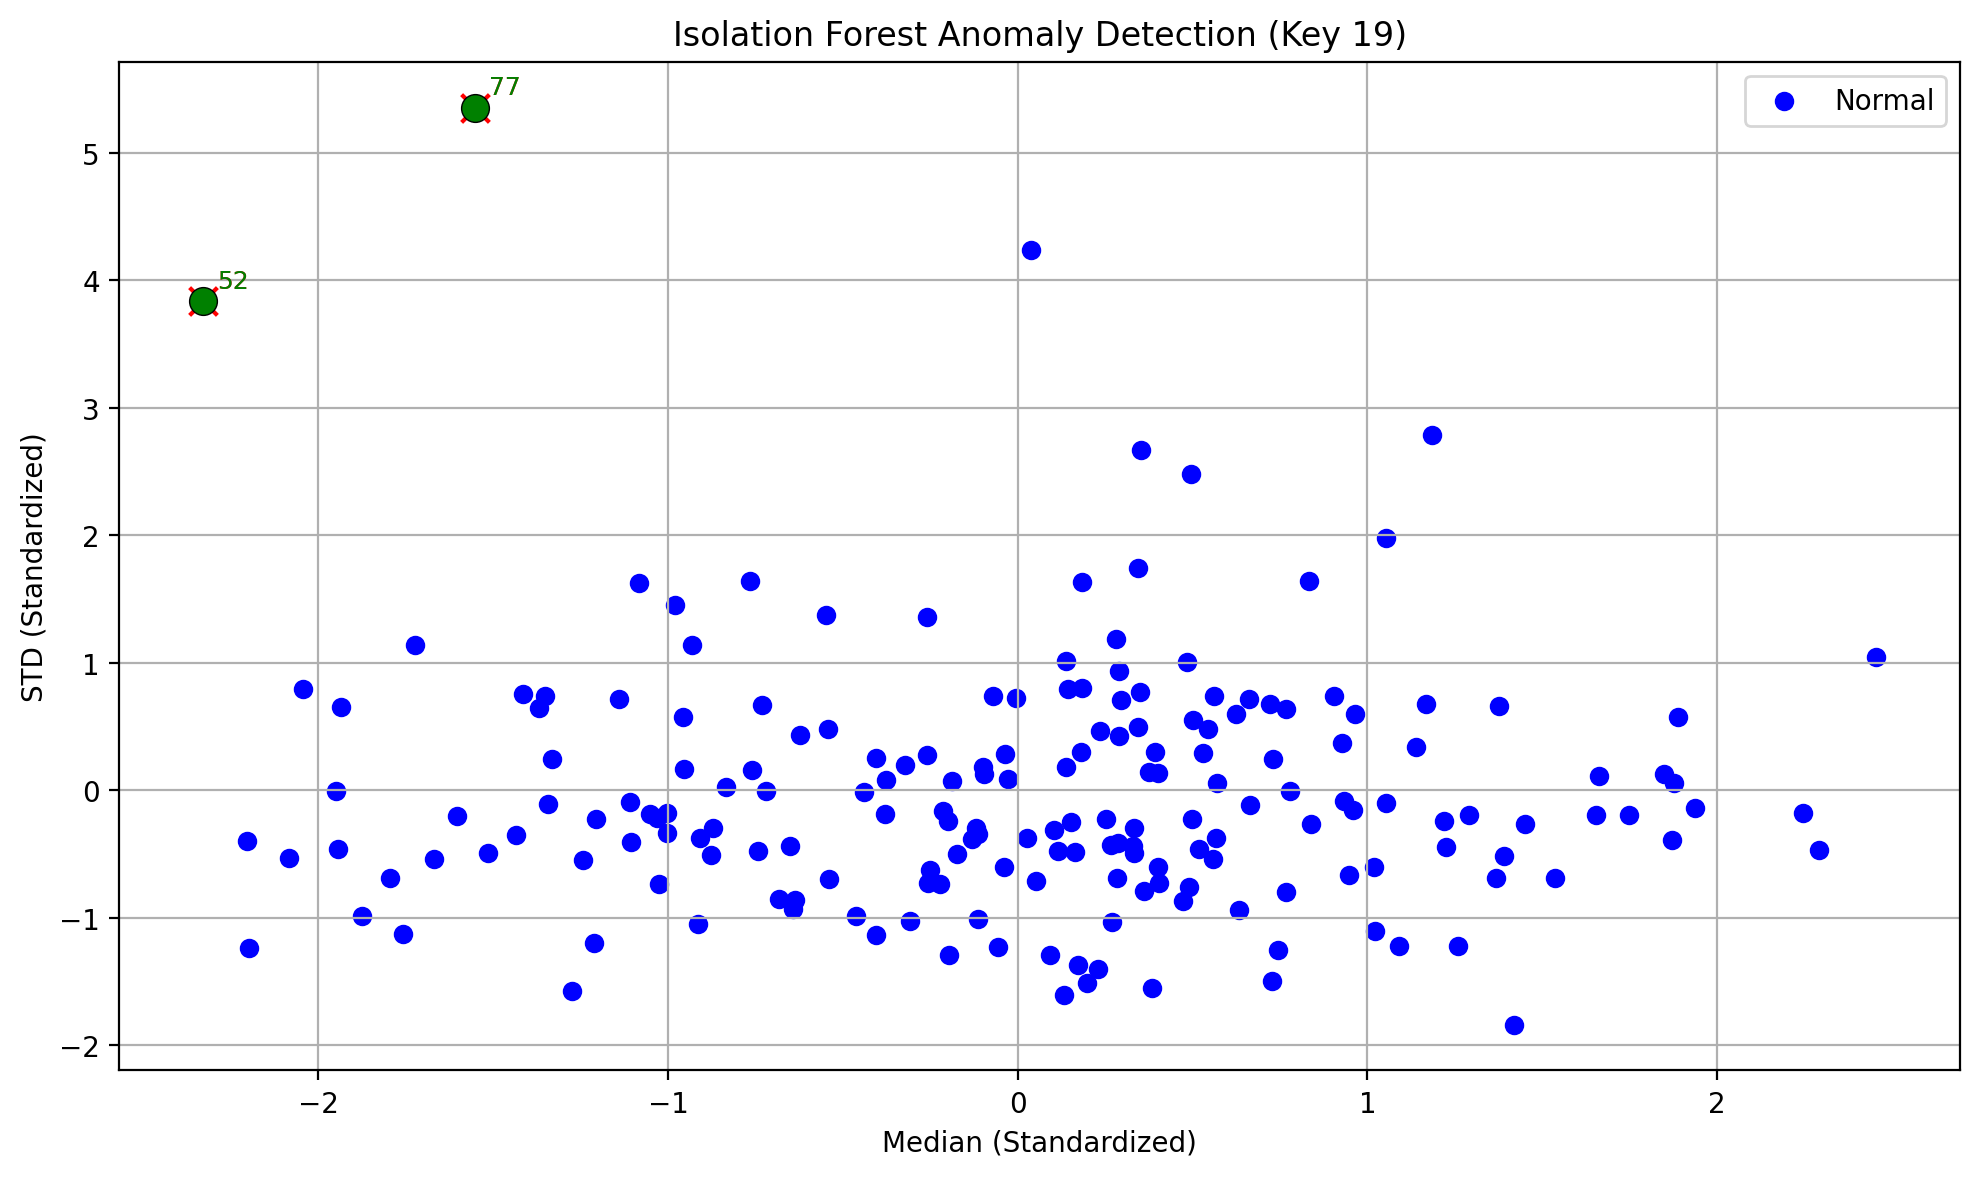

Anomalous sites detected for Key 19:
[52, 77]


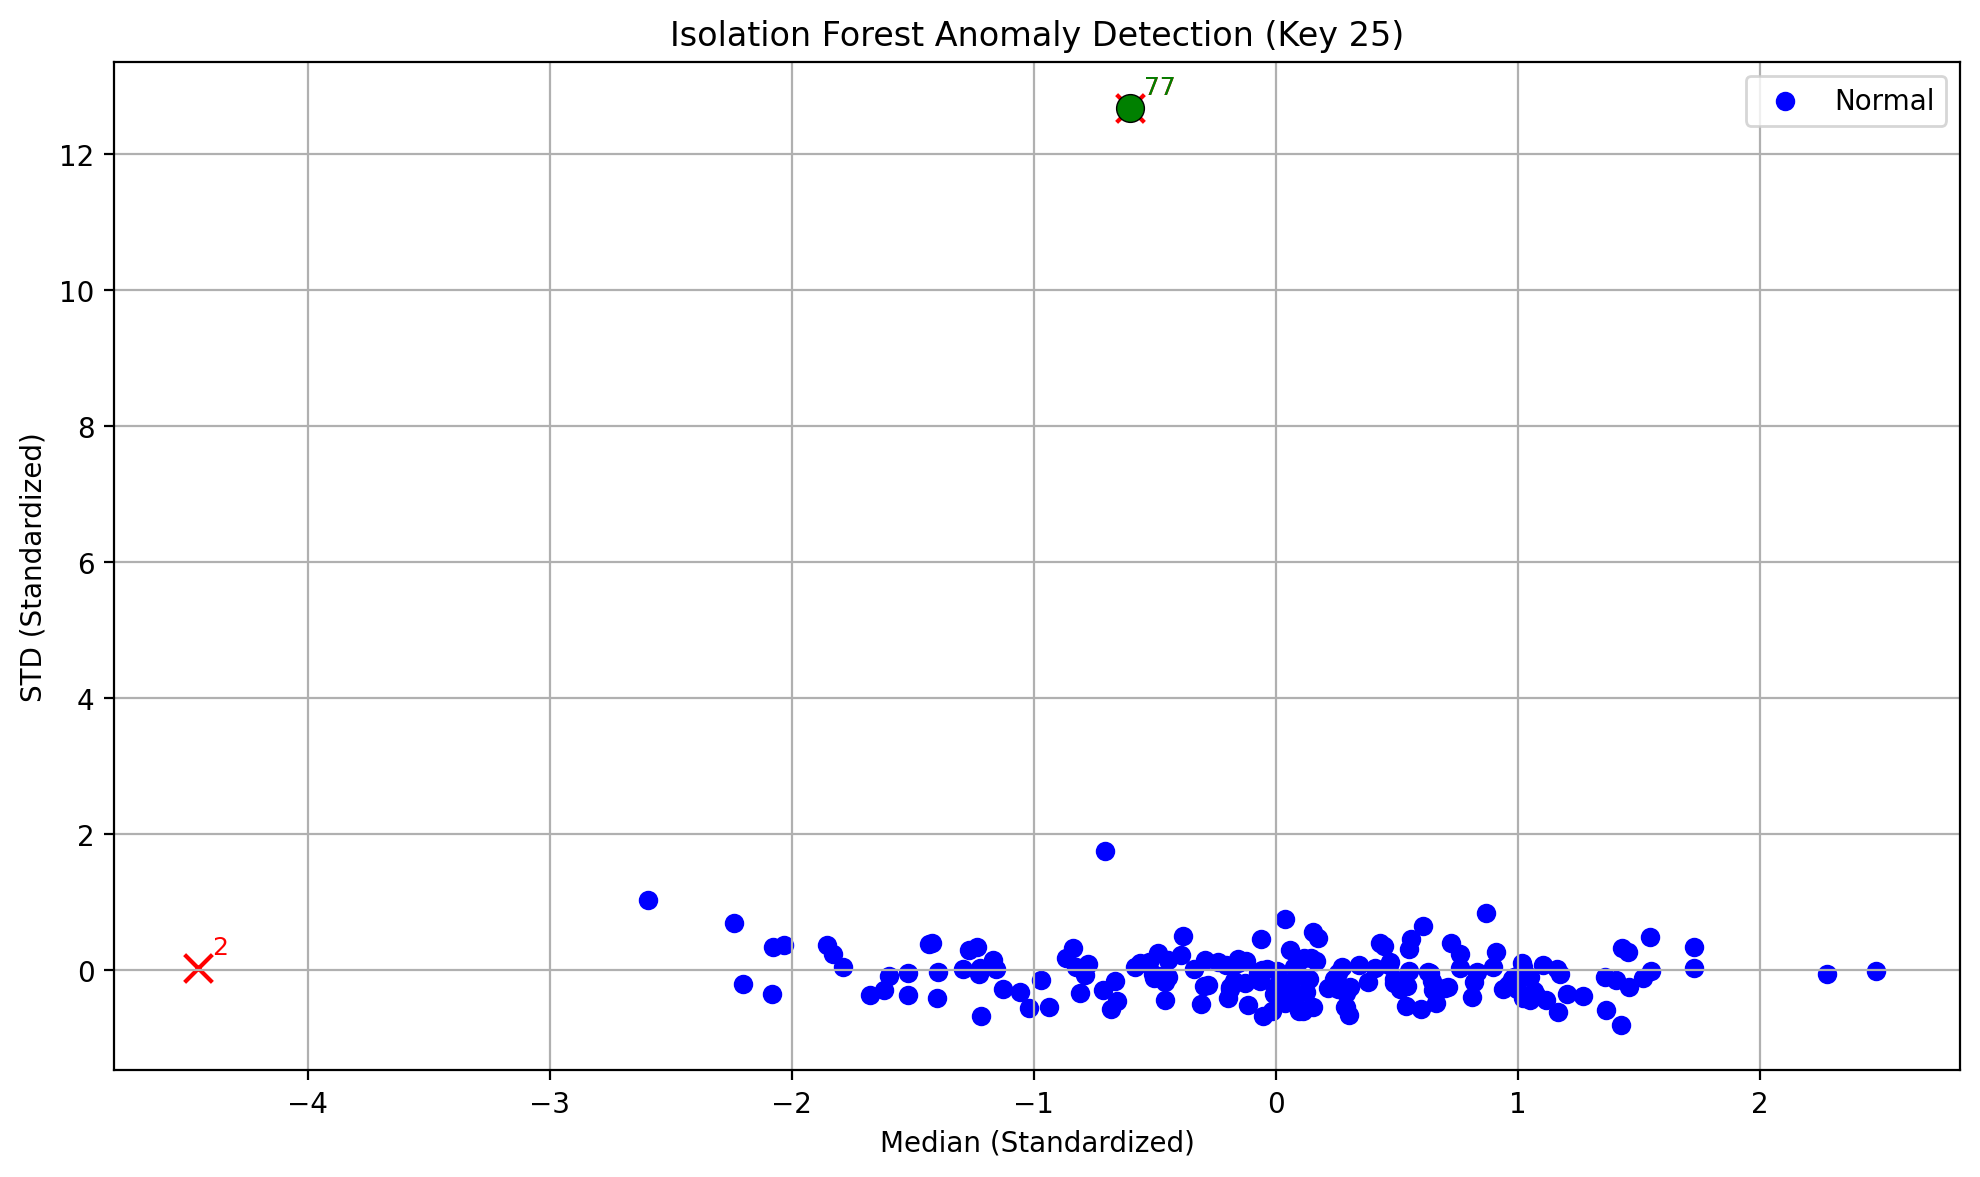

Anomalous sites detected for Key 25:
[2, 77]


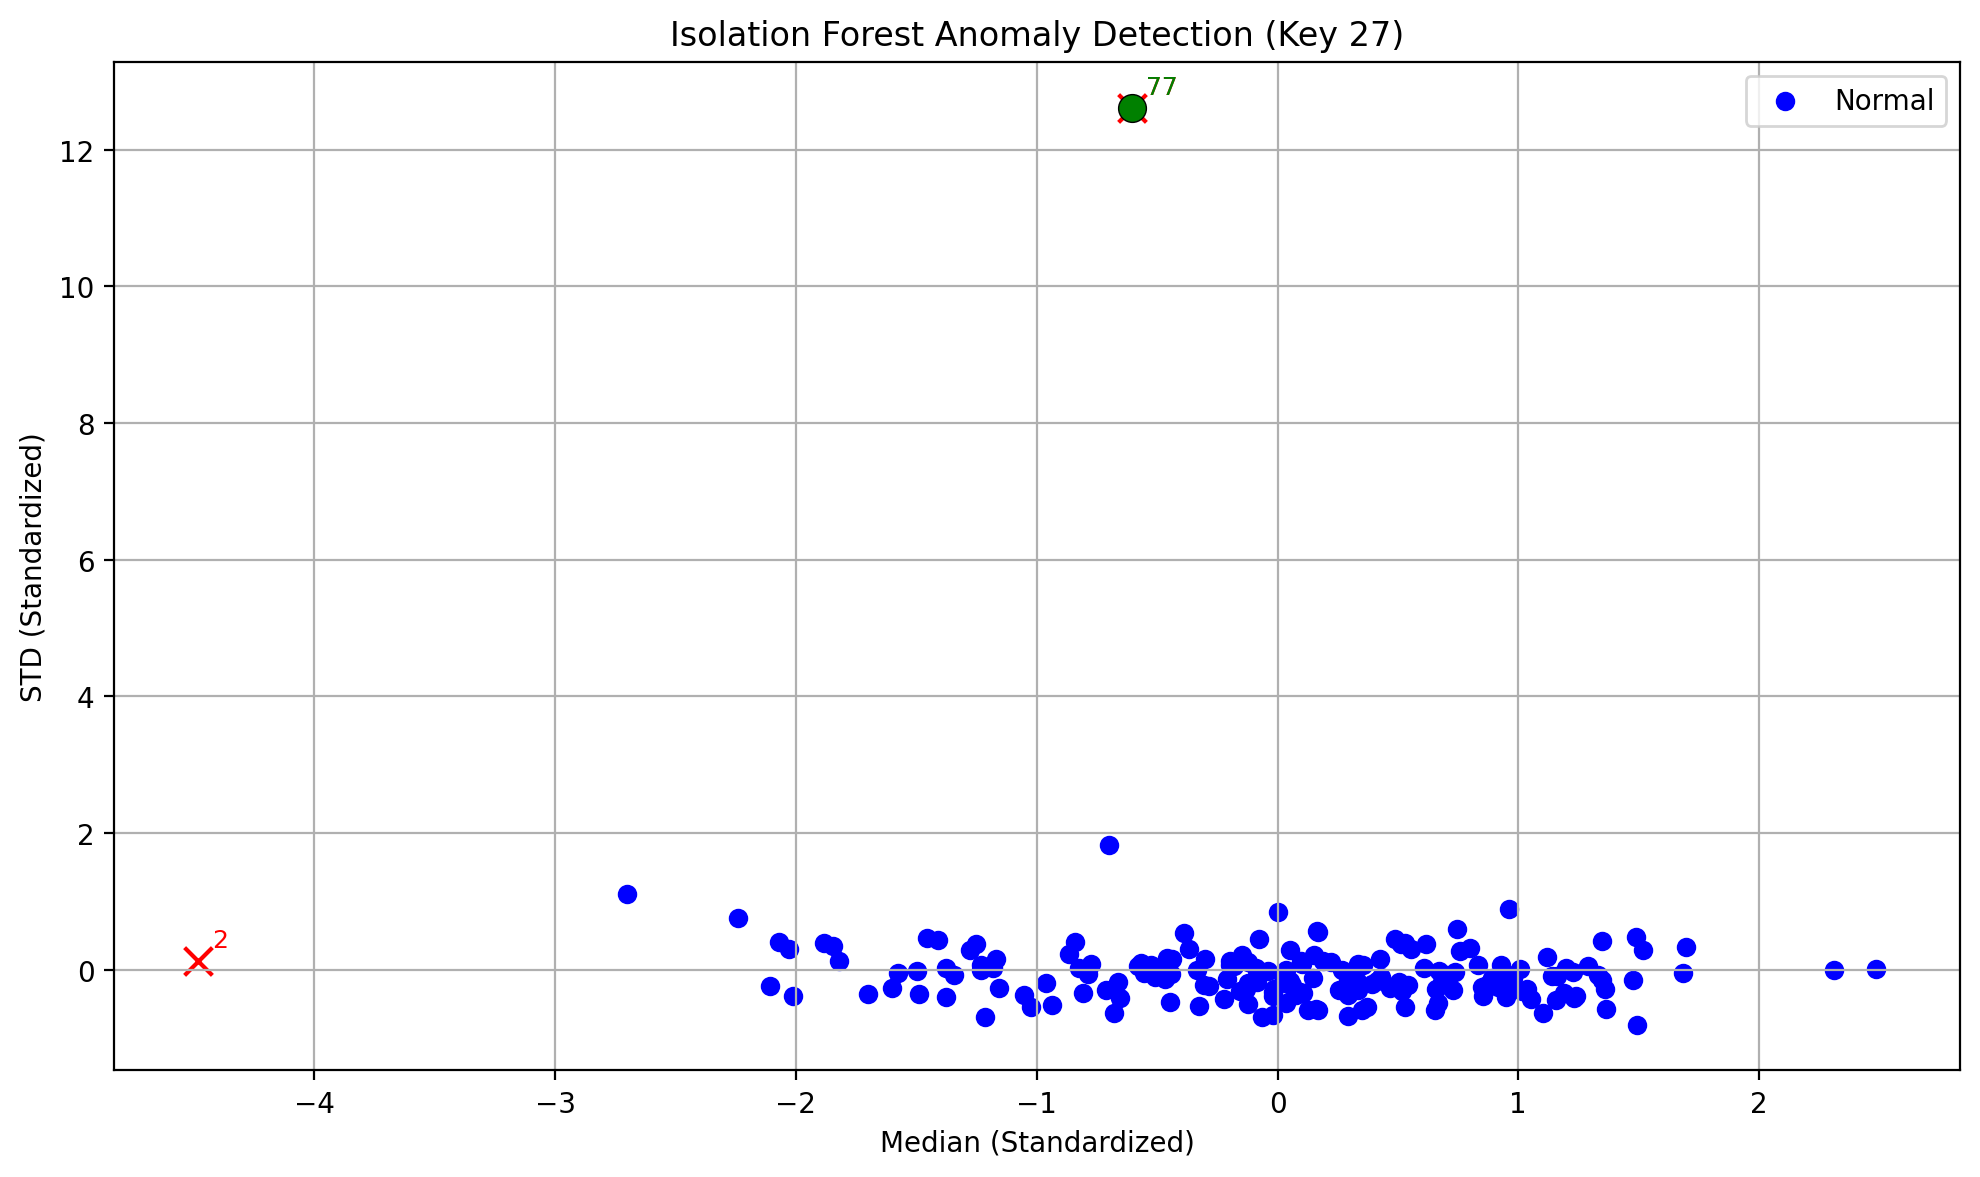

Anomalous sites detected for Key 27:
[2, 77]


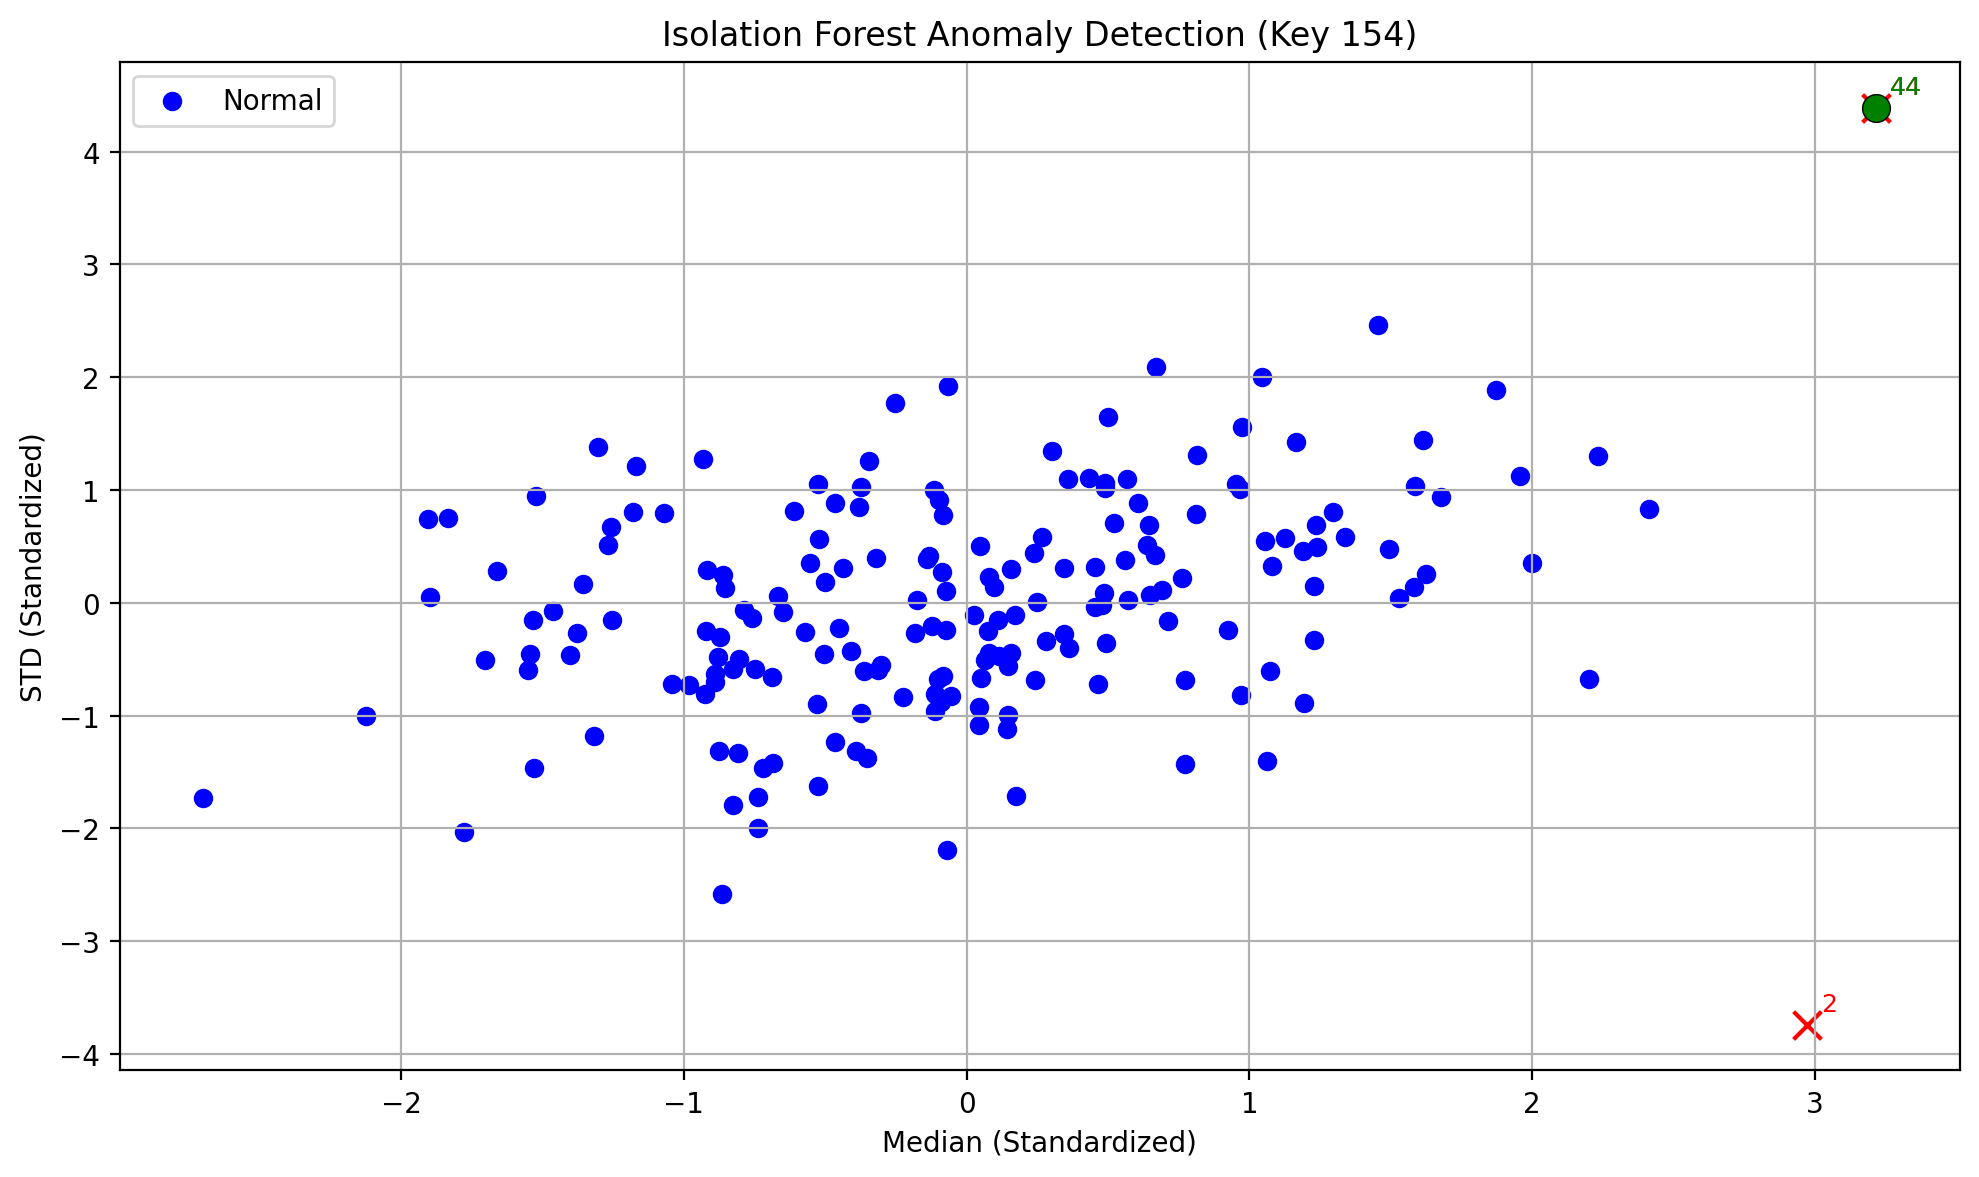

Anomalous sites detected for Key 154:
[2, 44]


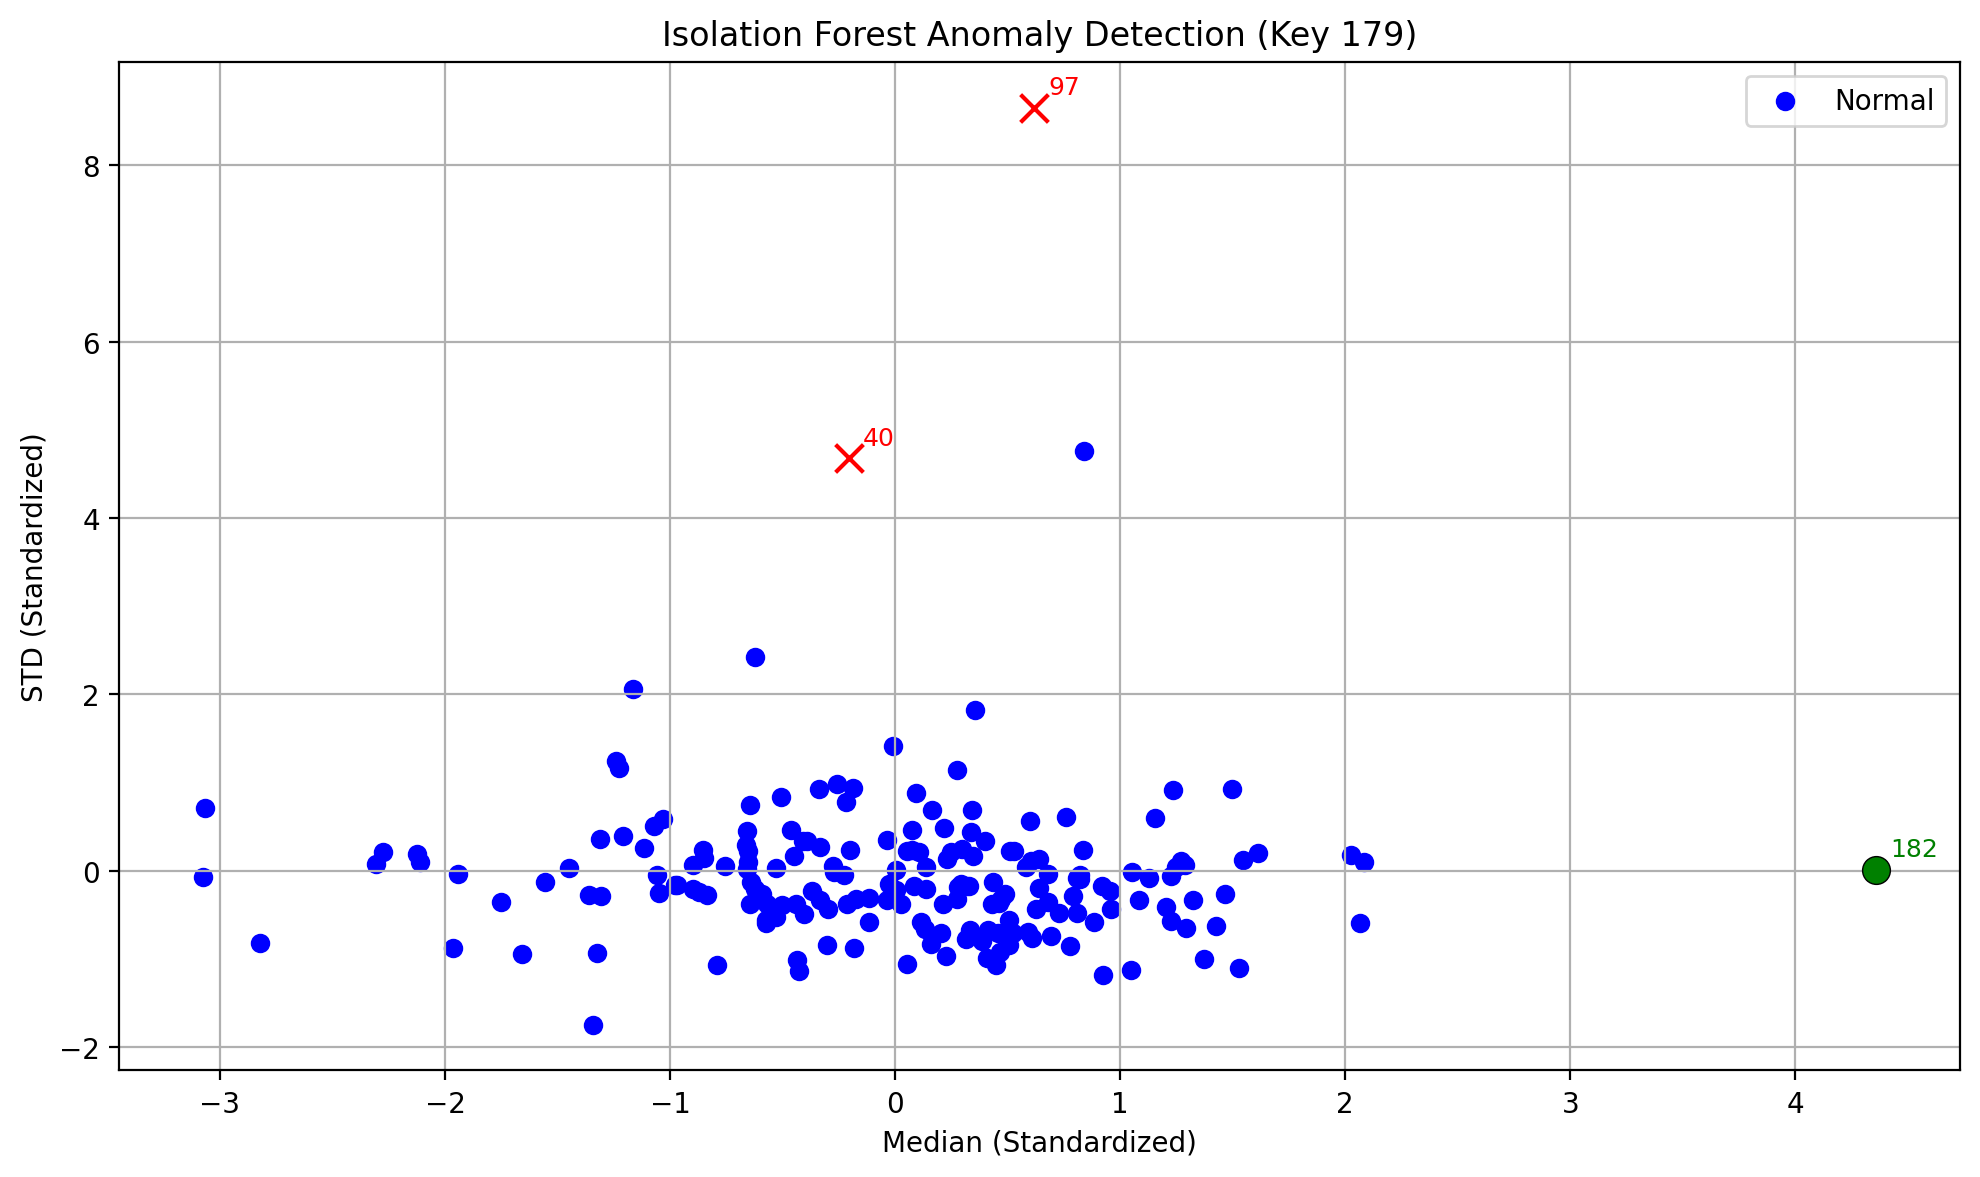

Anomalous sites detected for Key 179:
[40, 97]


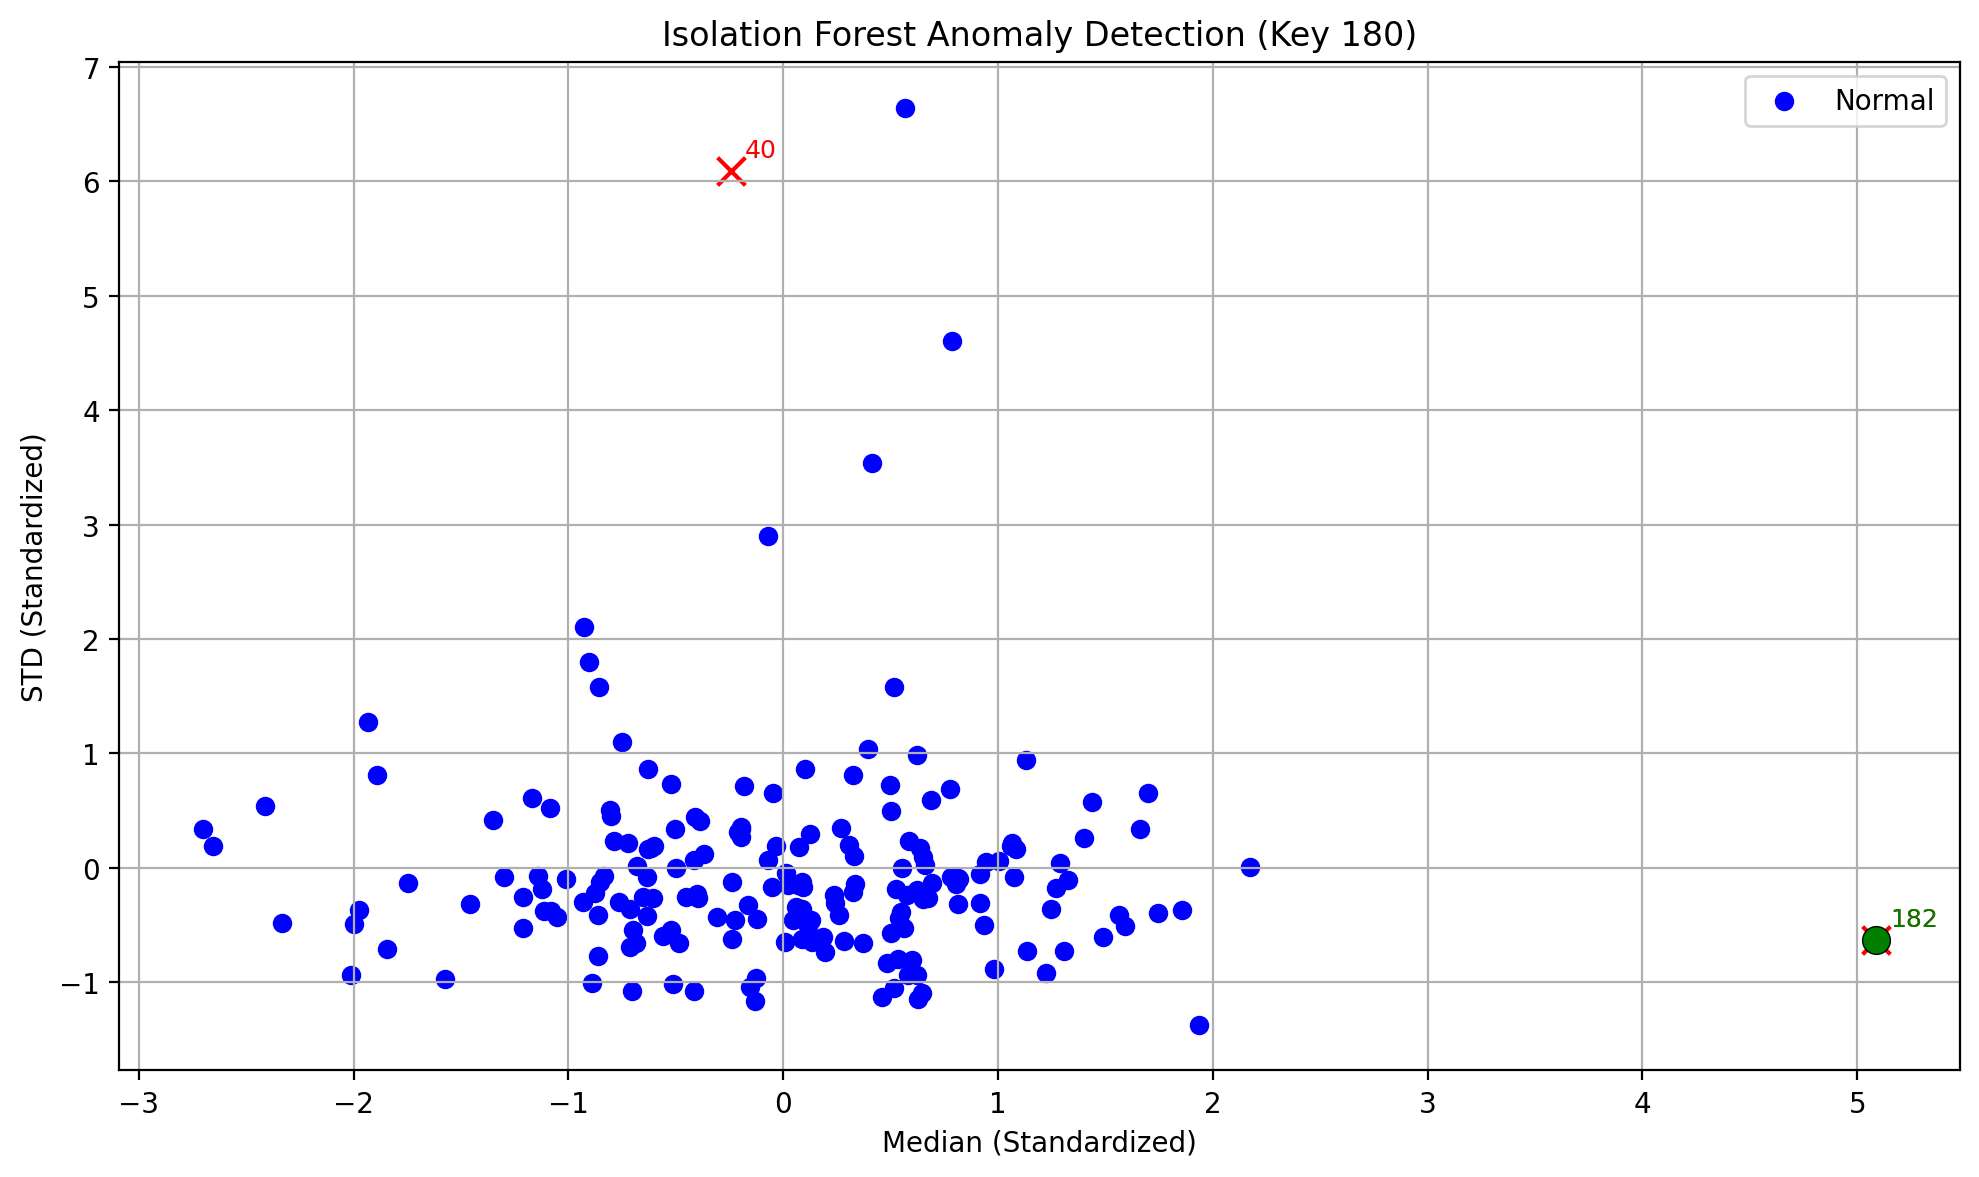

Anomalous sites detected for Key 180:
[40, 182]


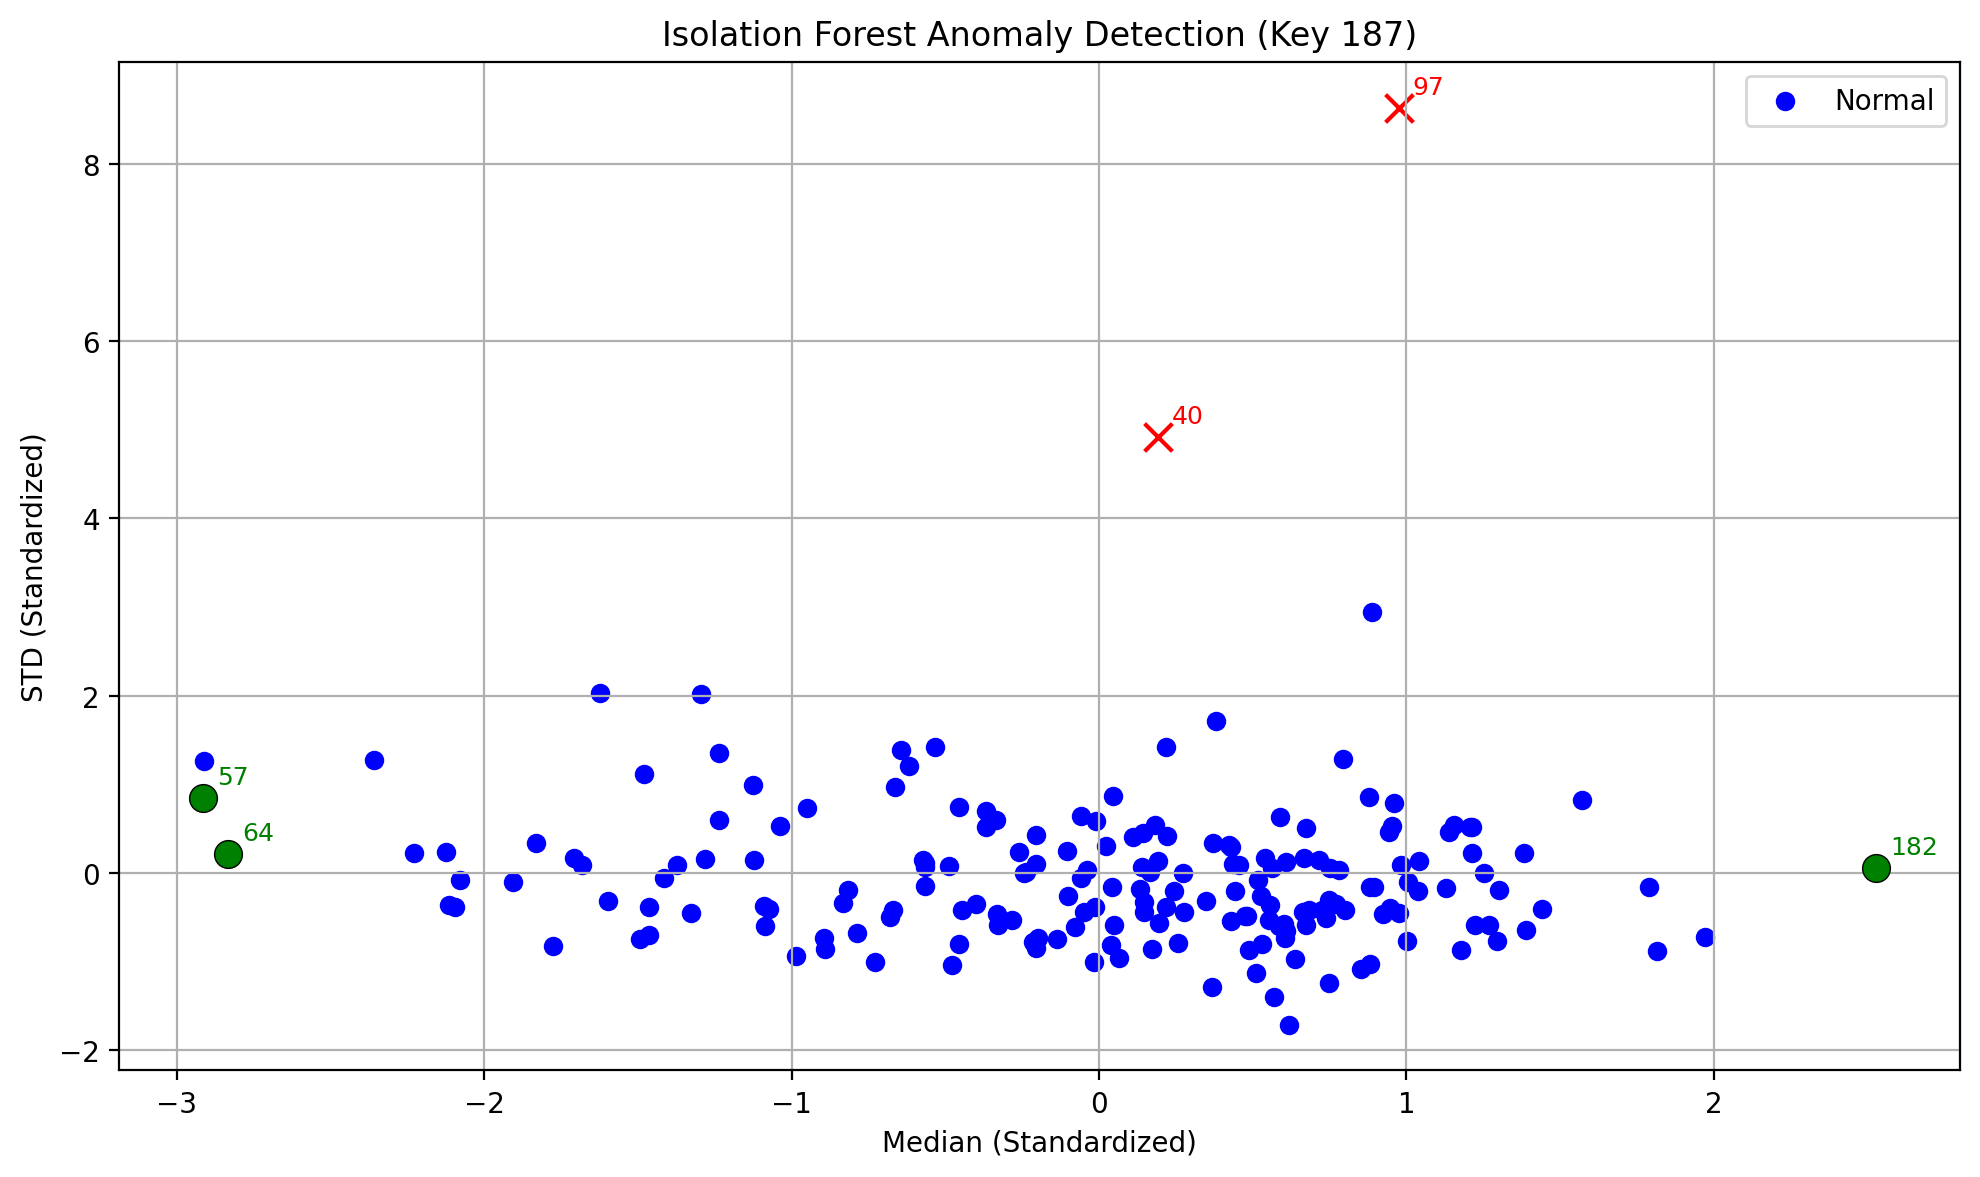

Anomalous sites detected for Key 187:
[40, 97]


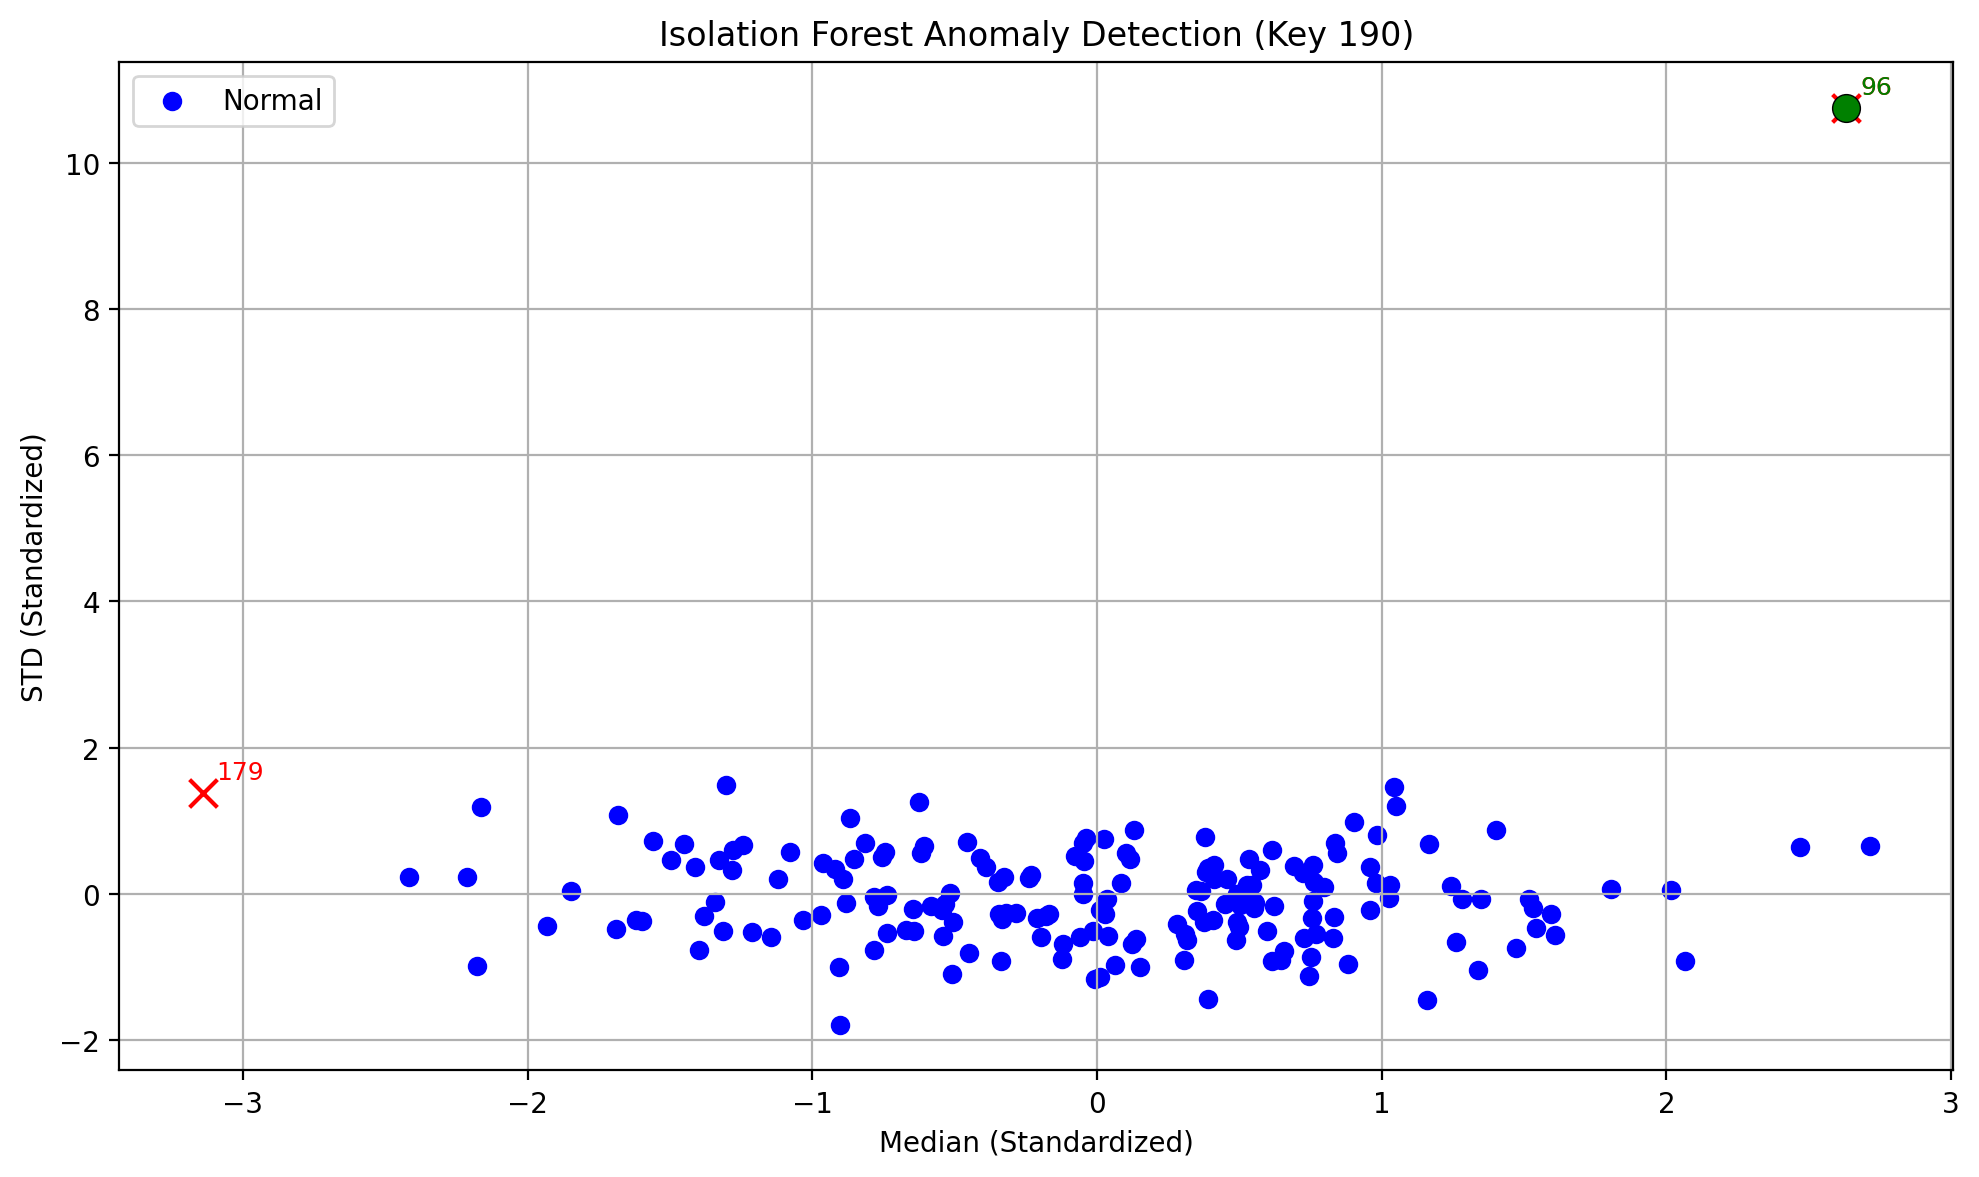

Anomalous sites detected for Key 190:
[96, 179]


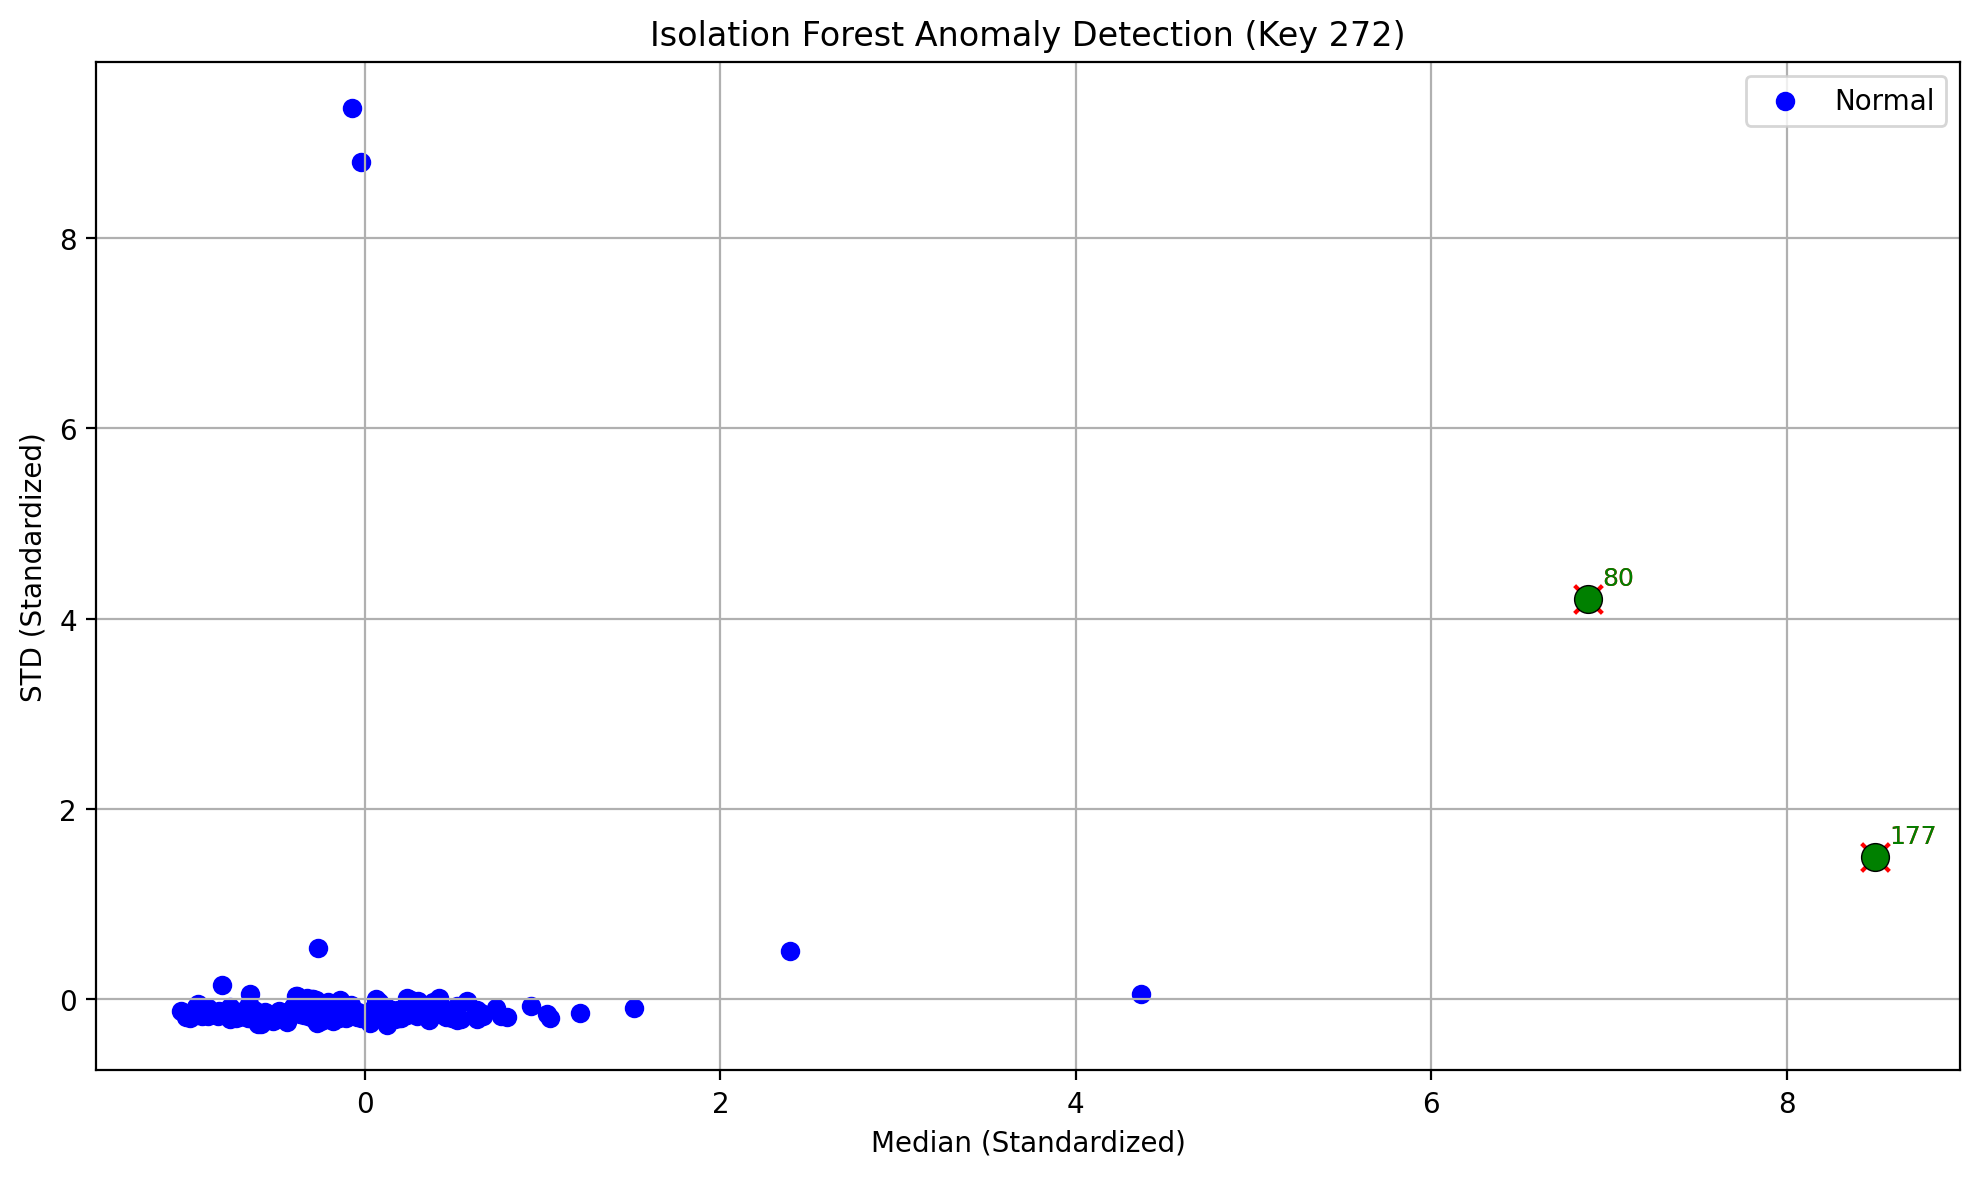

Anomalous sites detected for Key 272:
[80, 177]


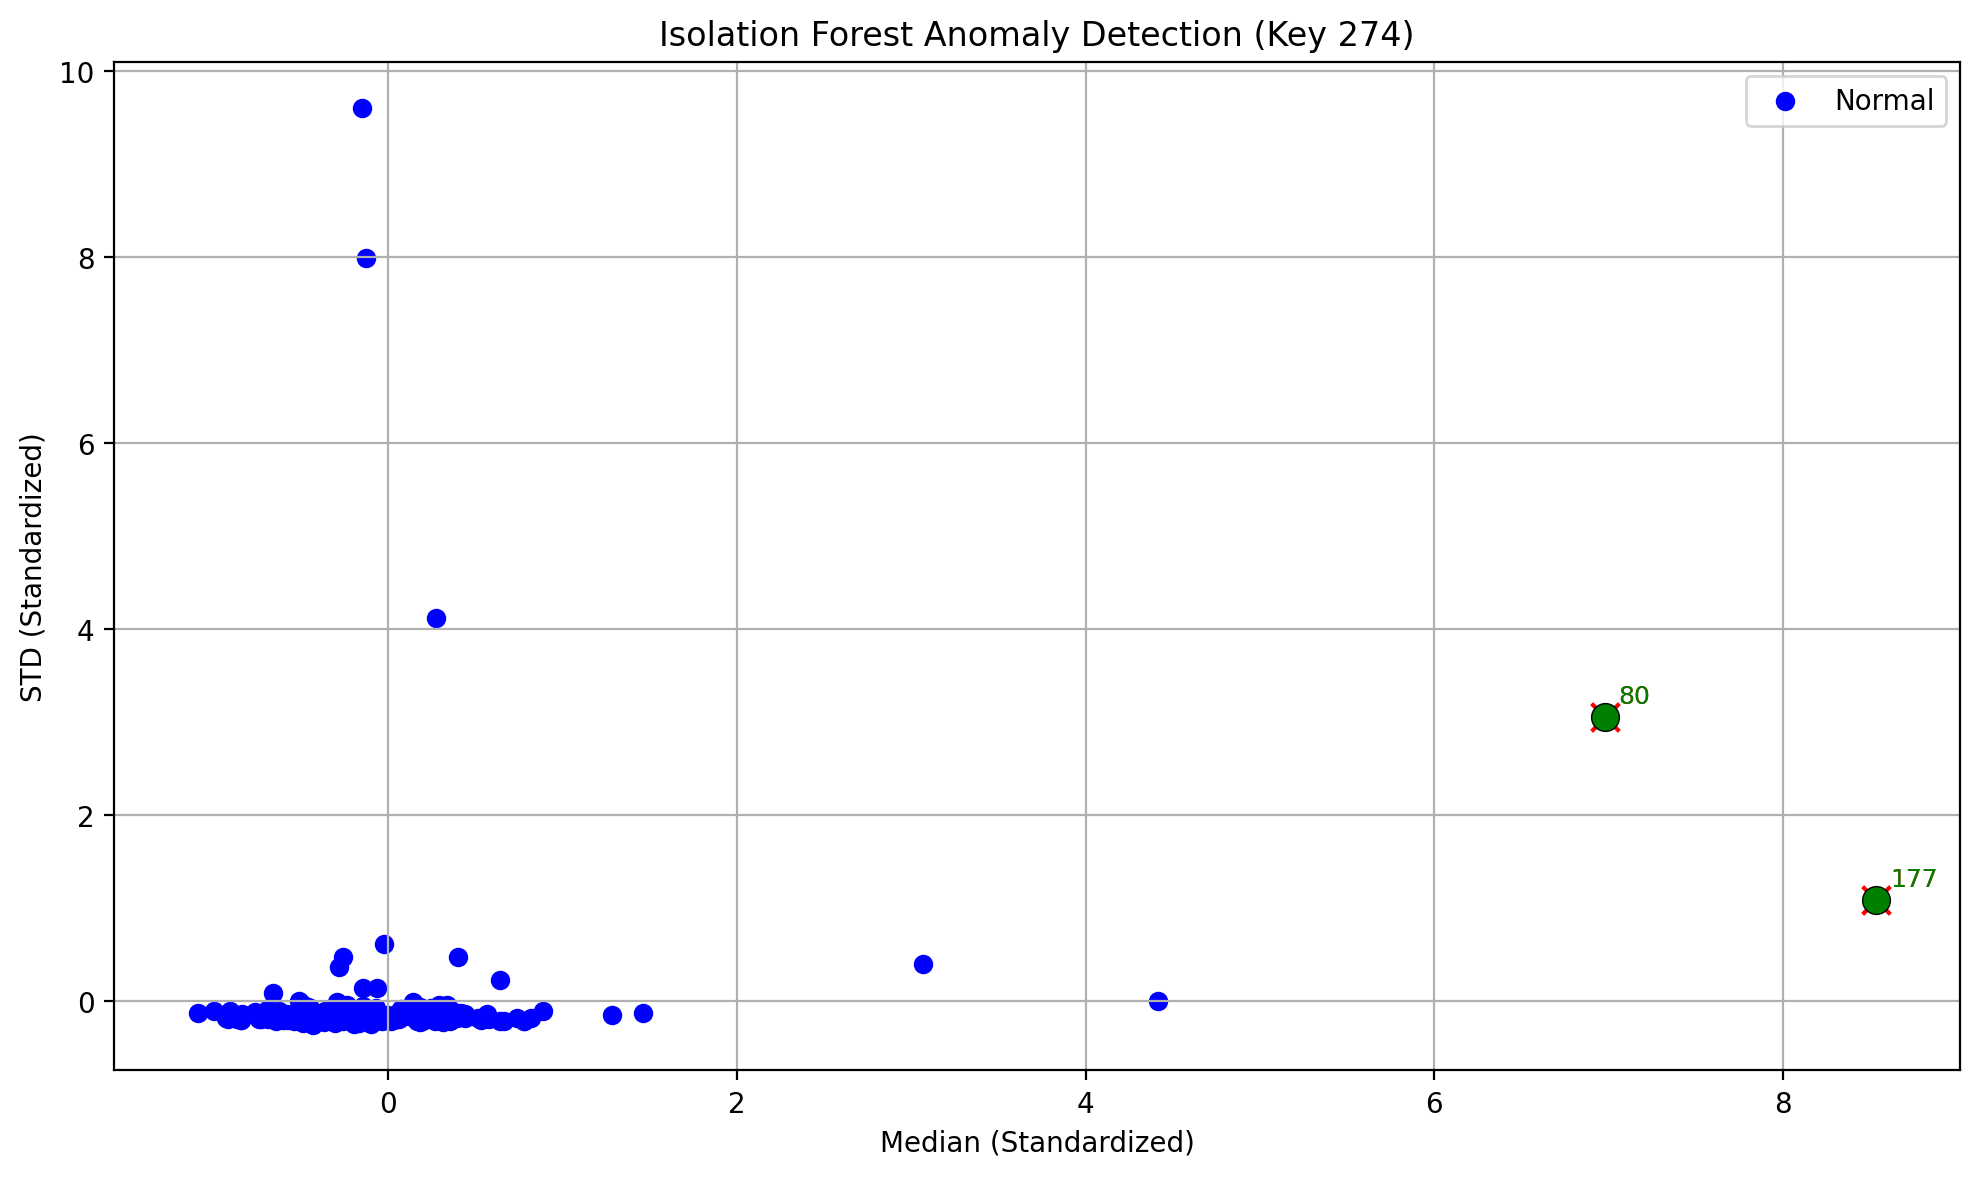

Anomalous sites detected for Key 274:
[80, 177]


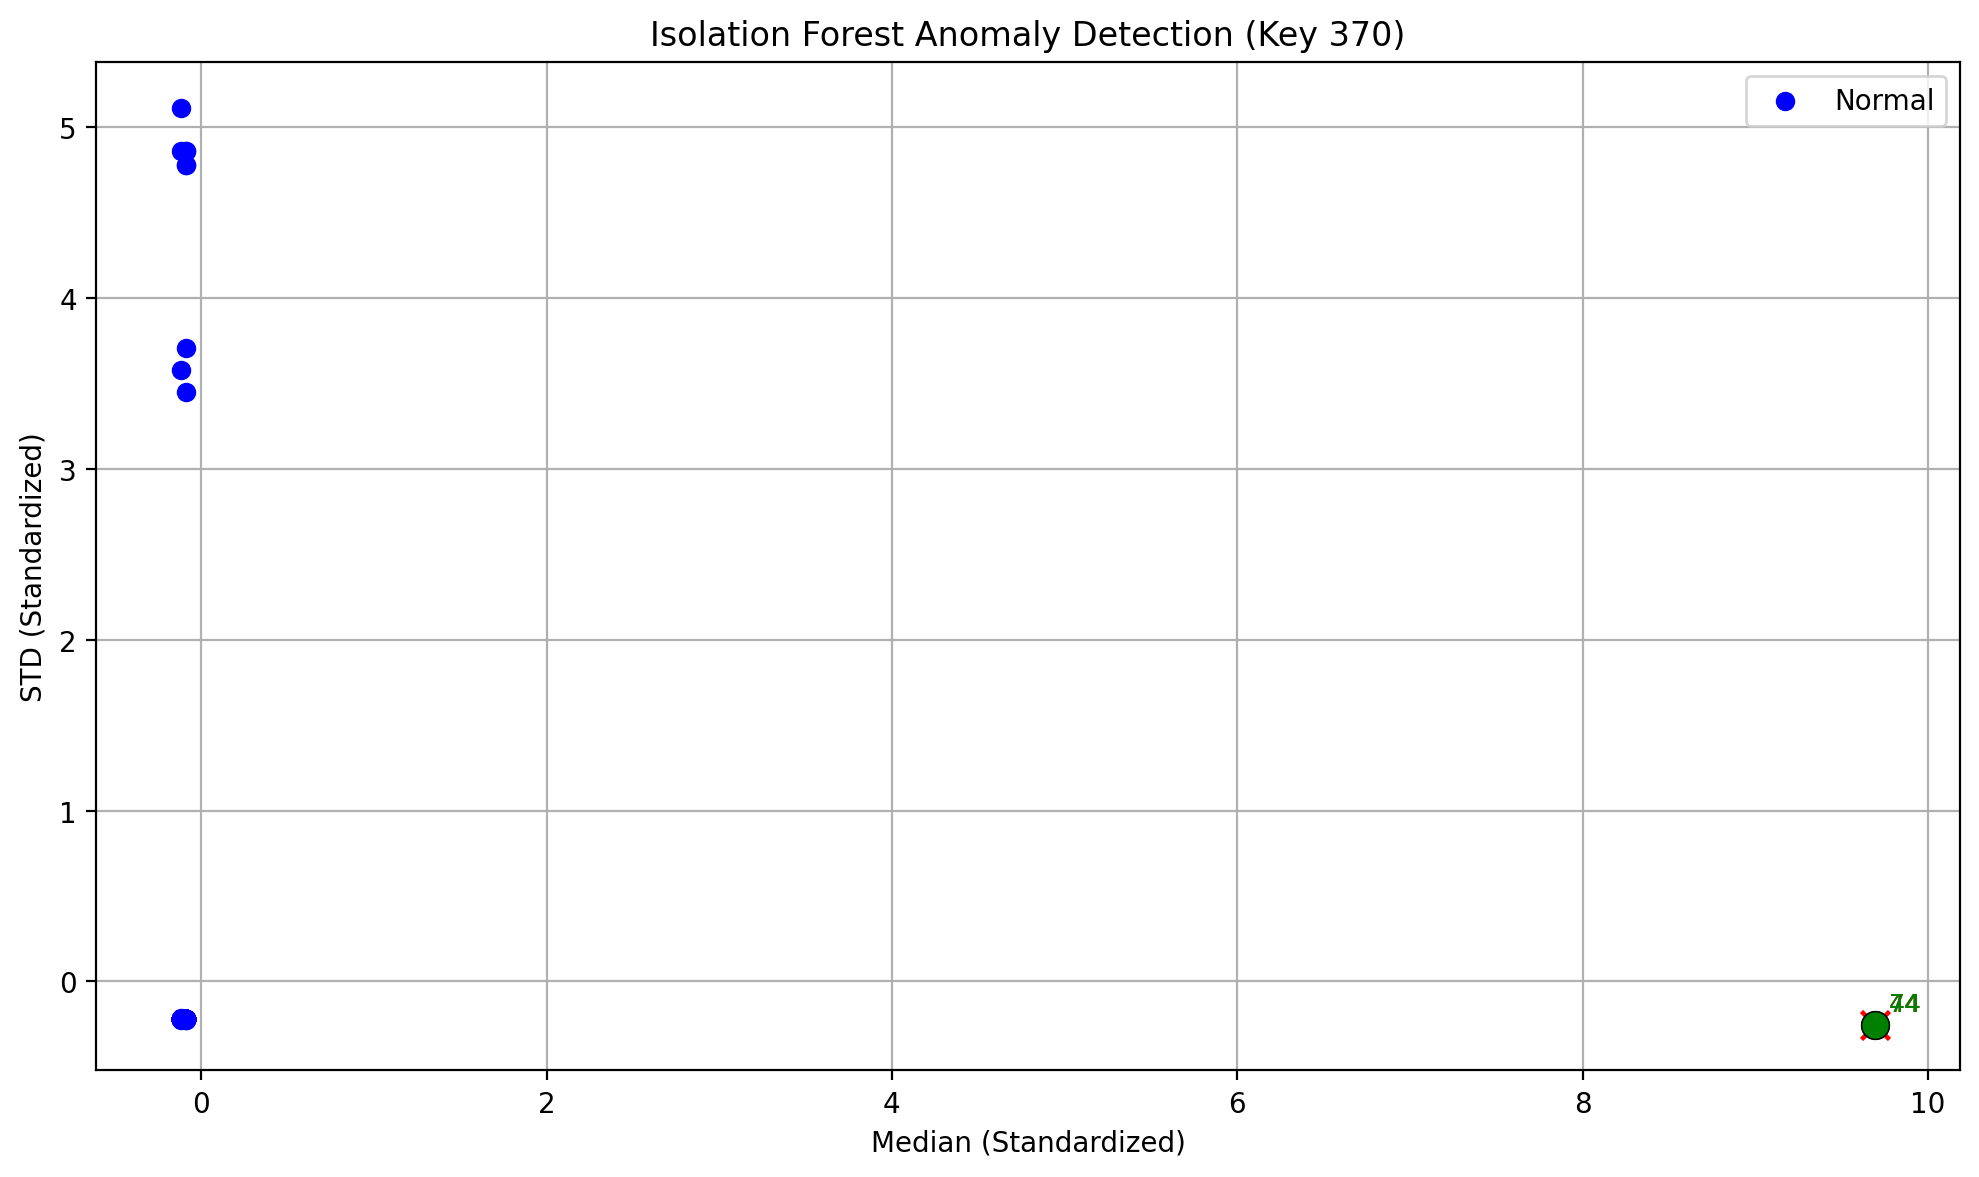

Anomalous sites detected for Key 370:
[44, 74]


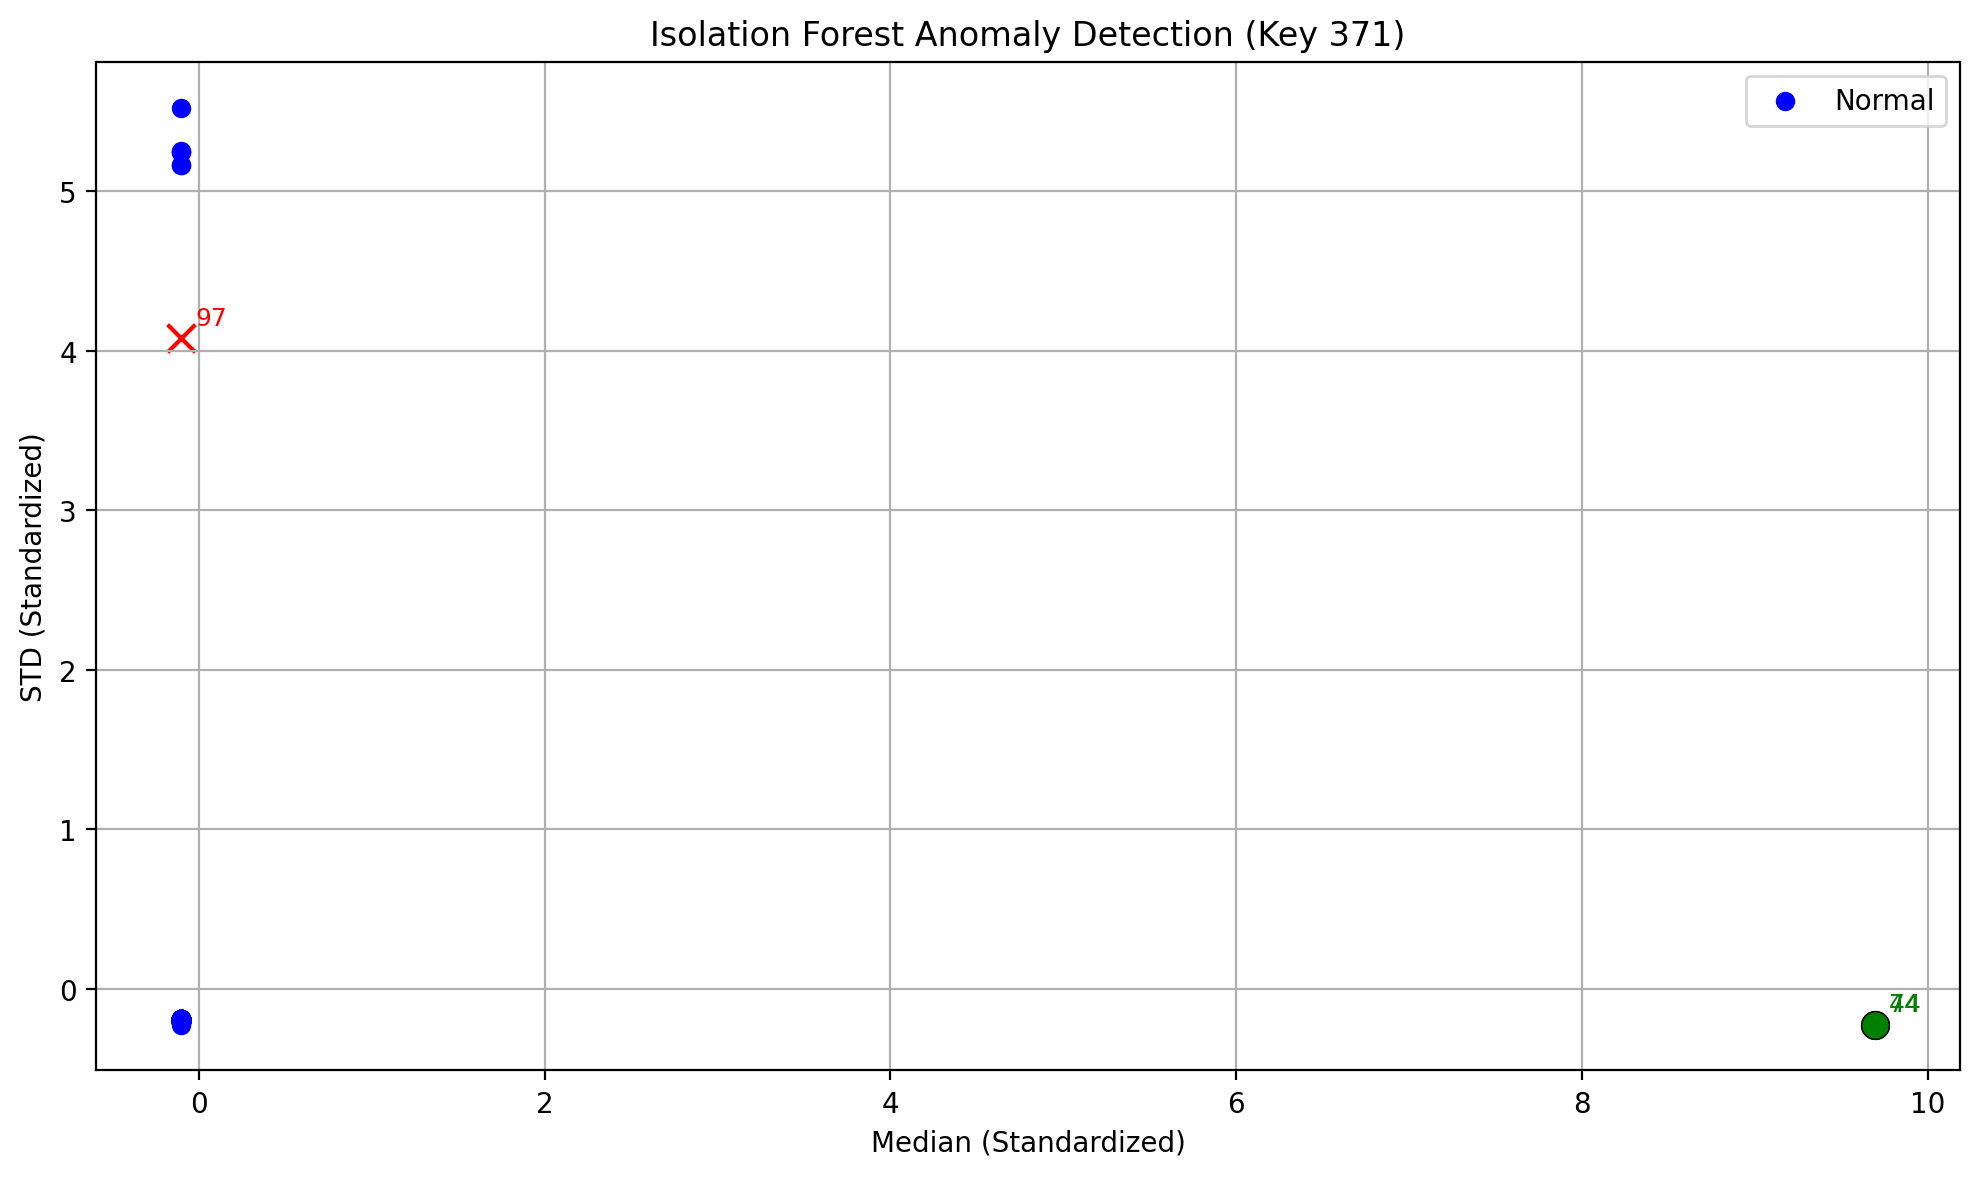

Anomalous sites detected for Key 371:
[97]


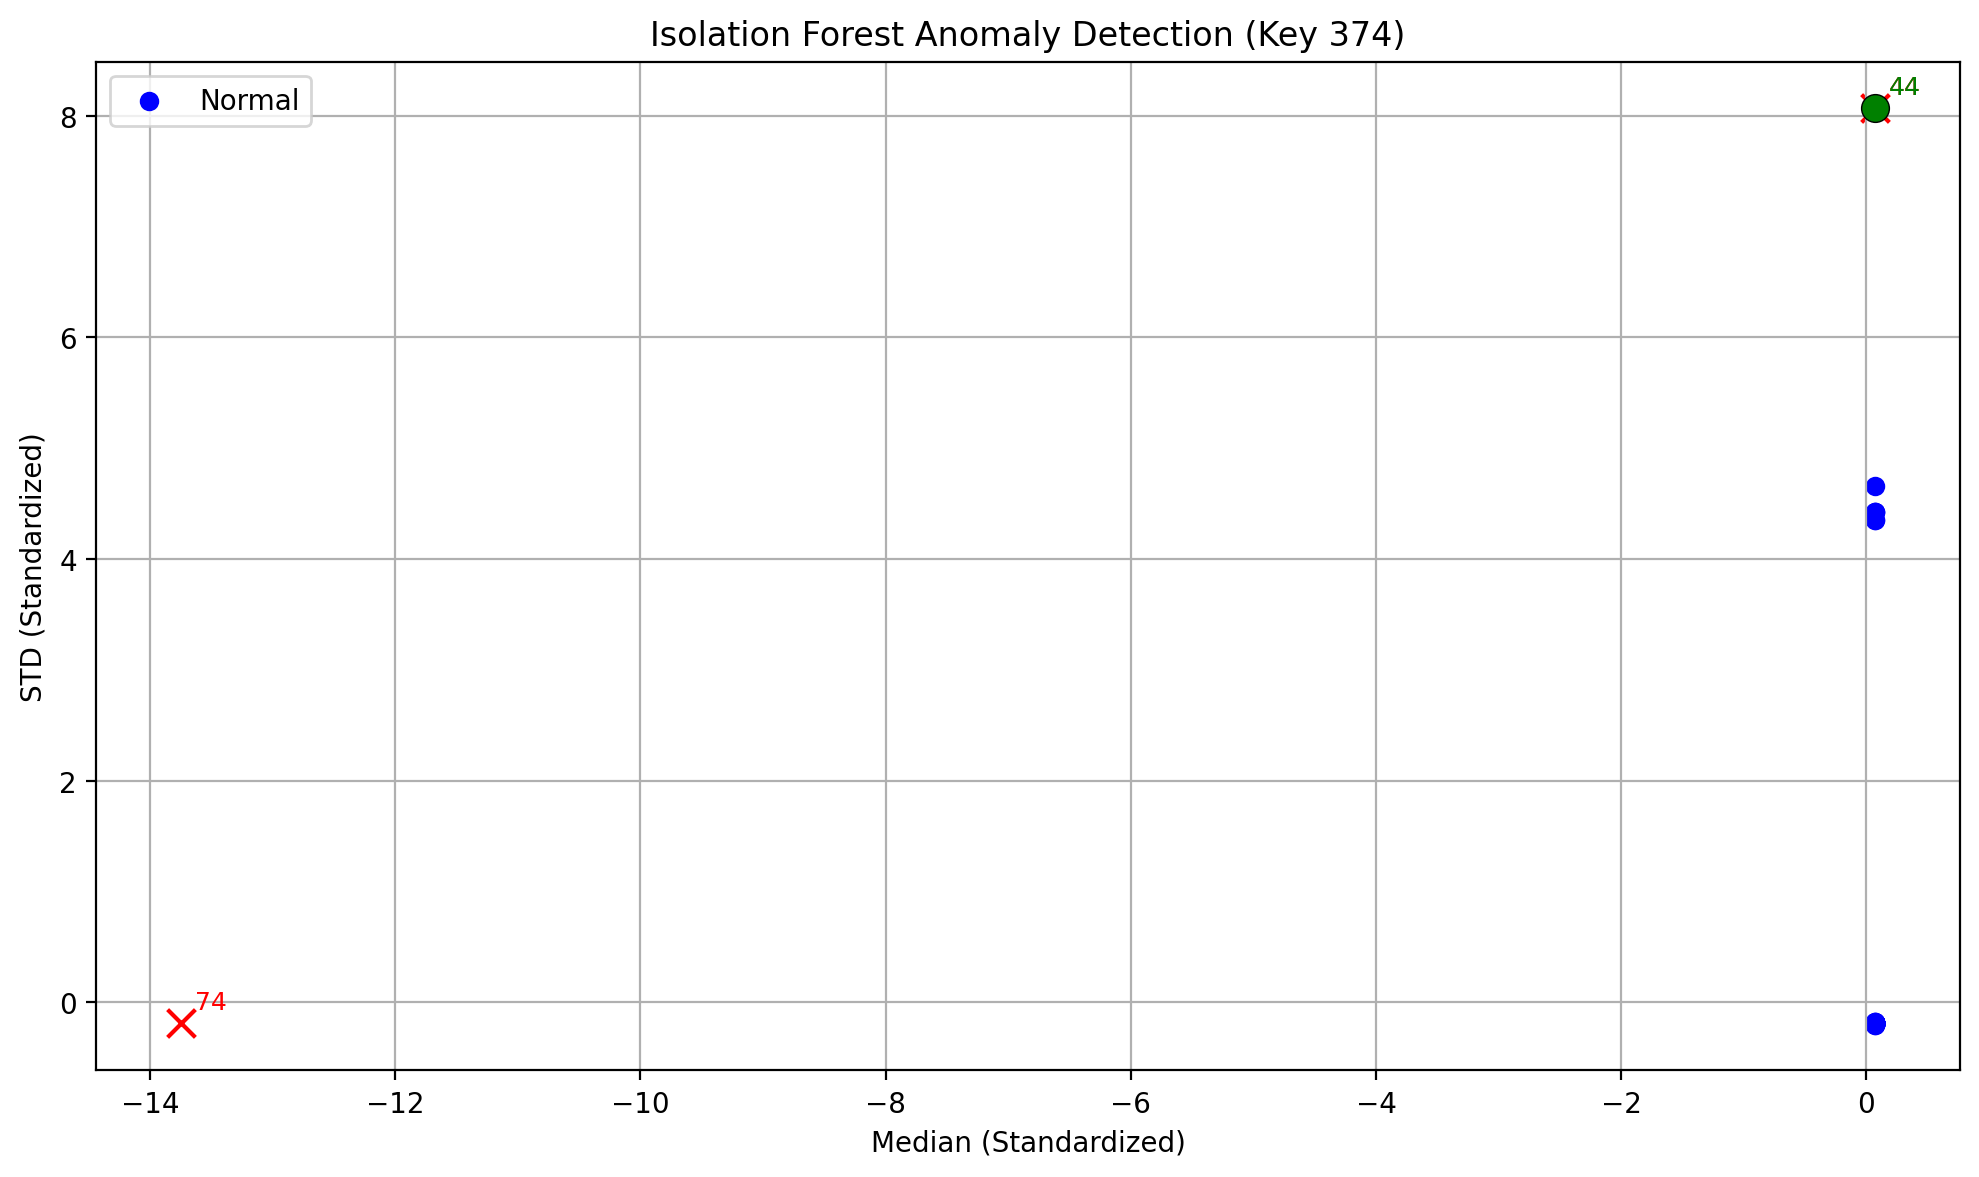

Anomalous sites detected for Key 374:
[44, 74]


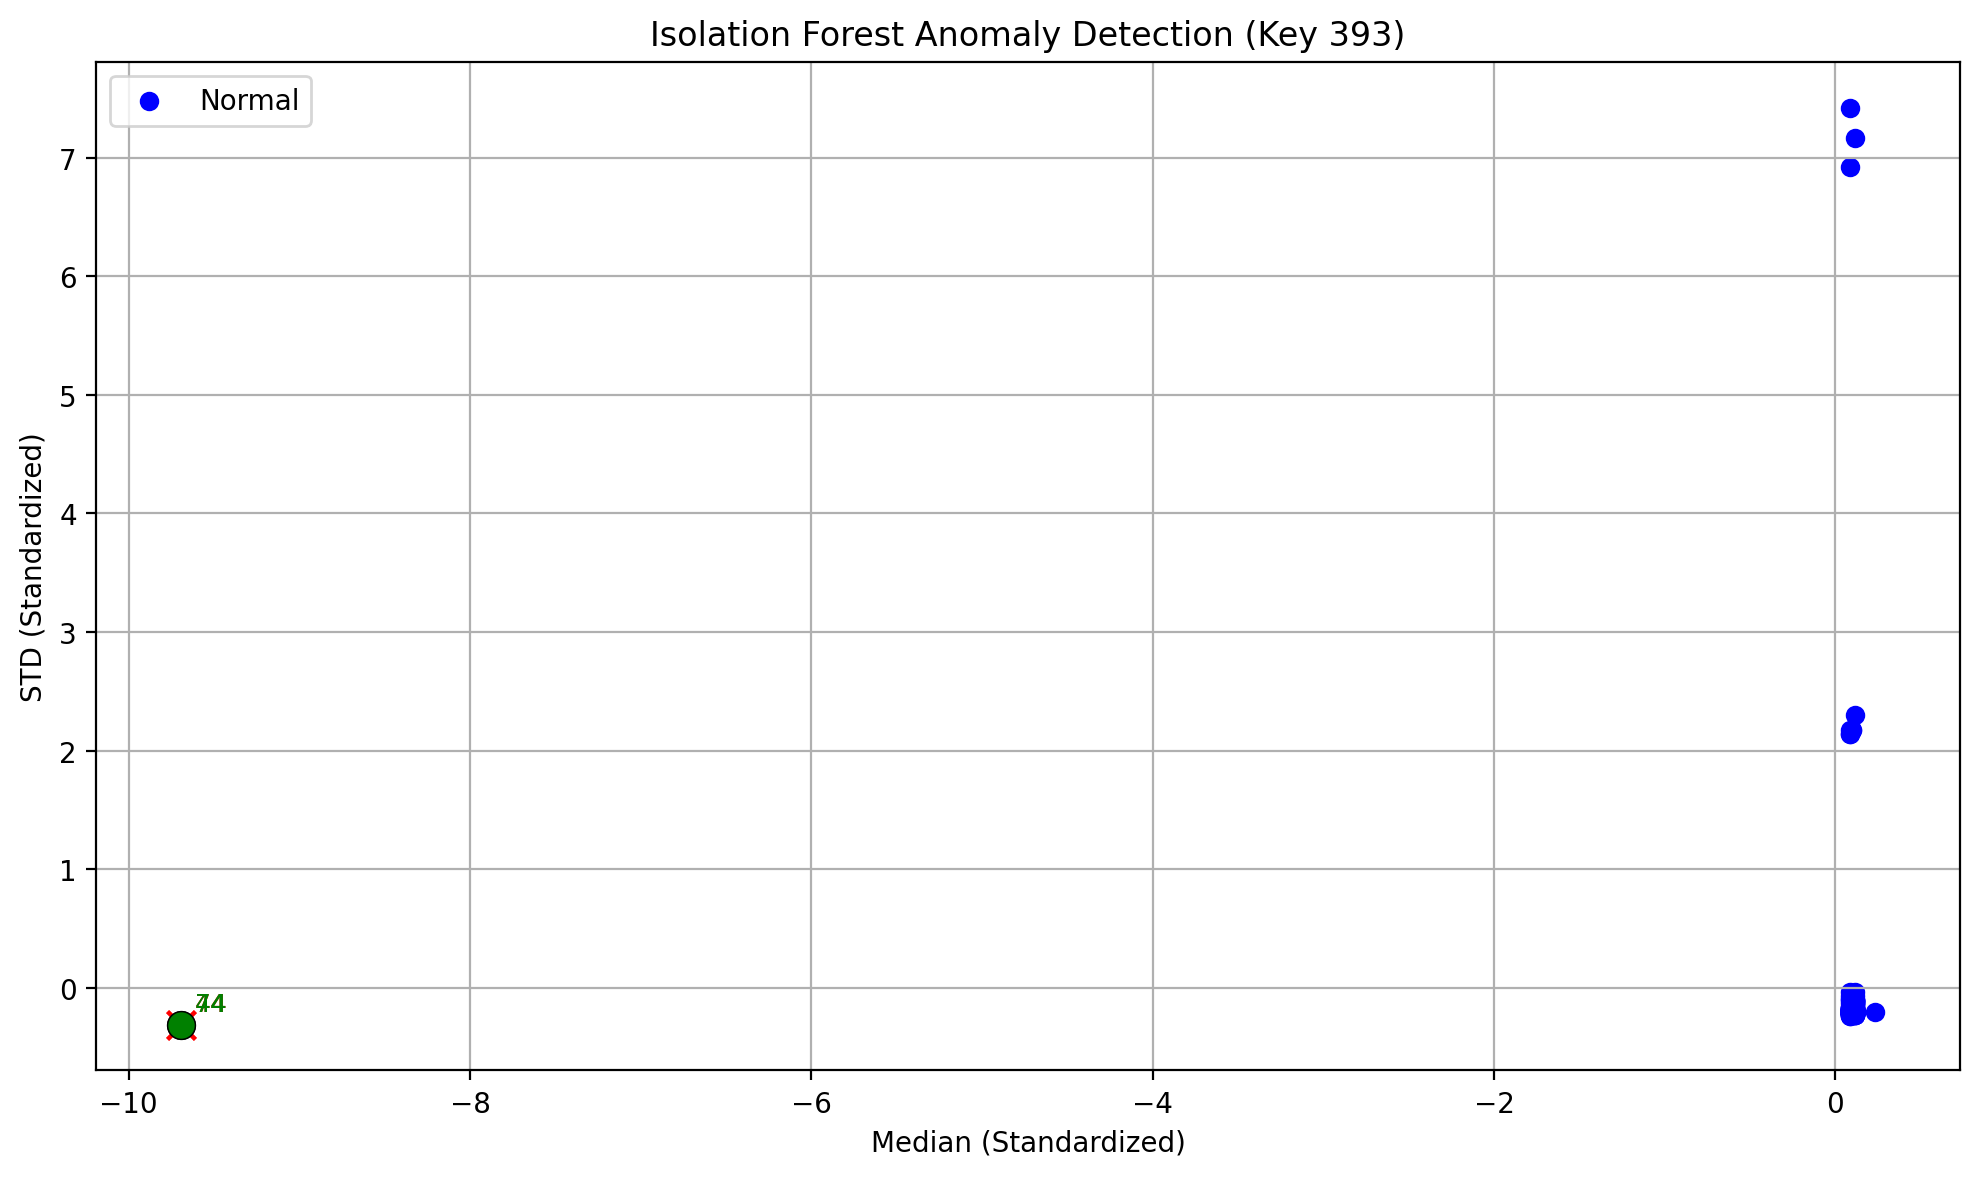

Anomalous sites detected for Key 393:
[44, 74]


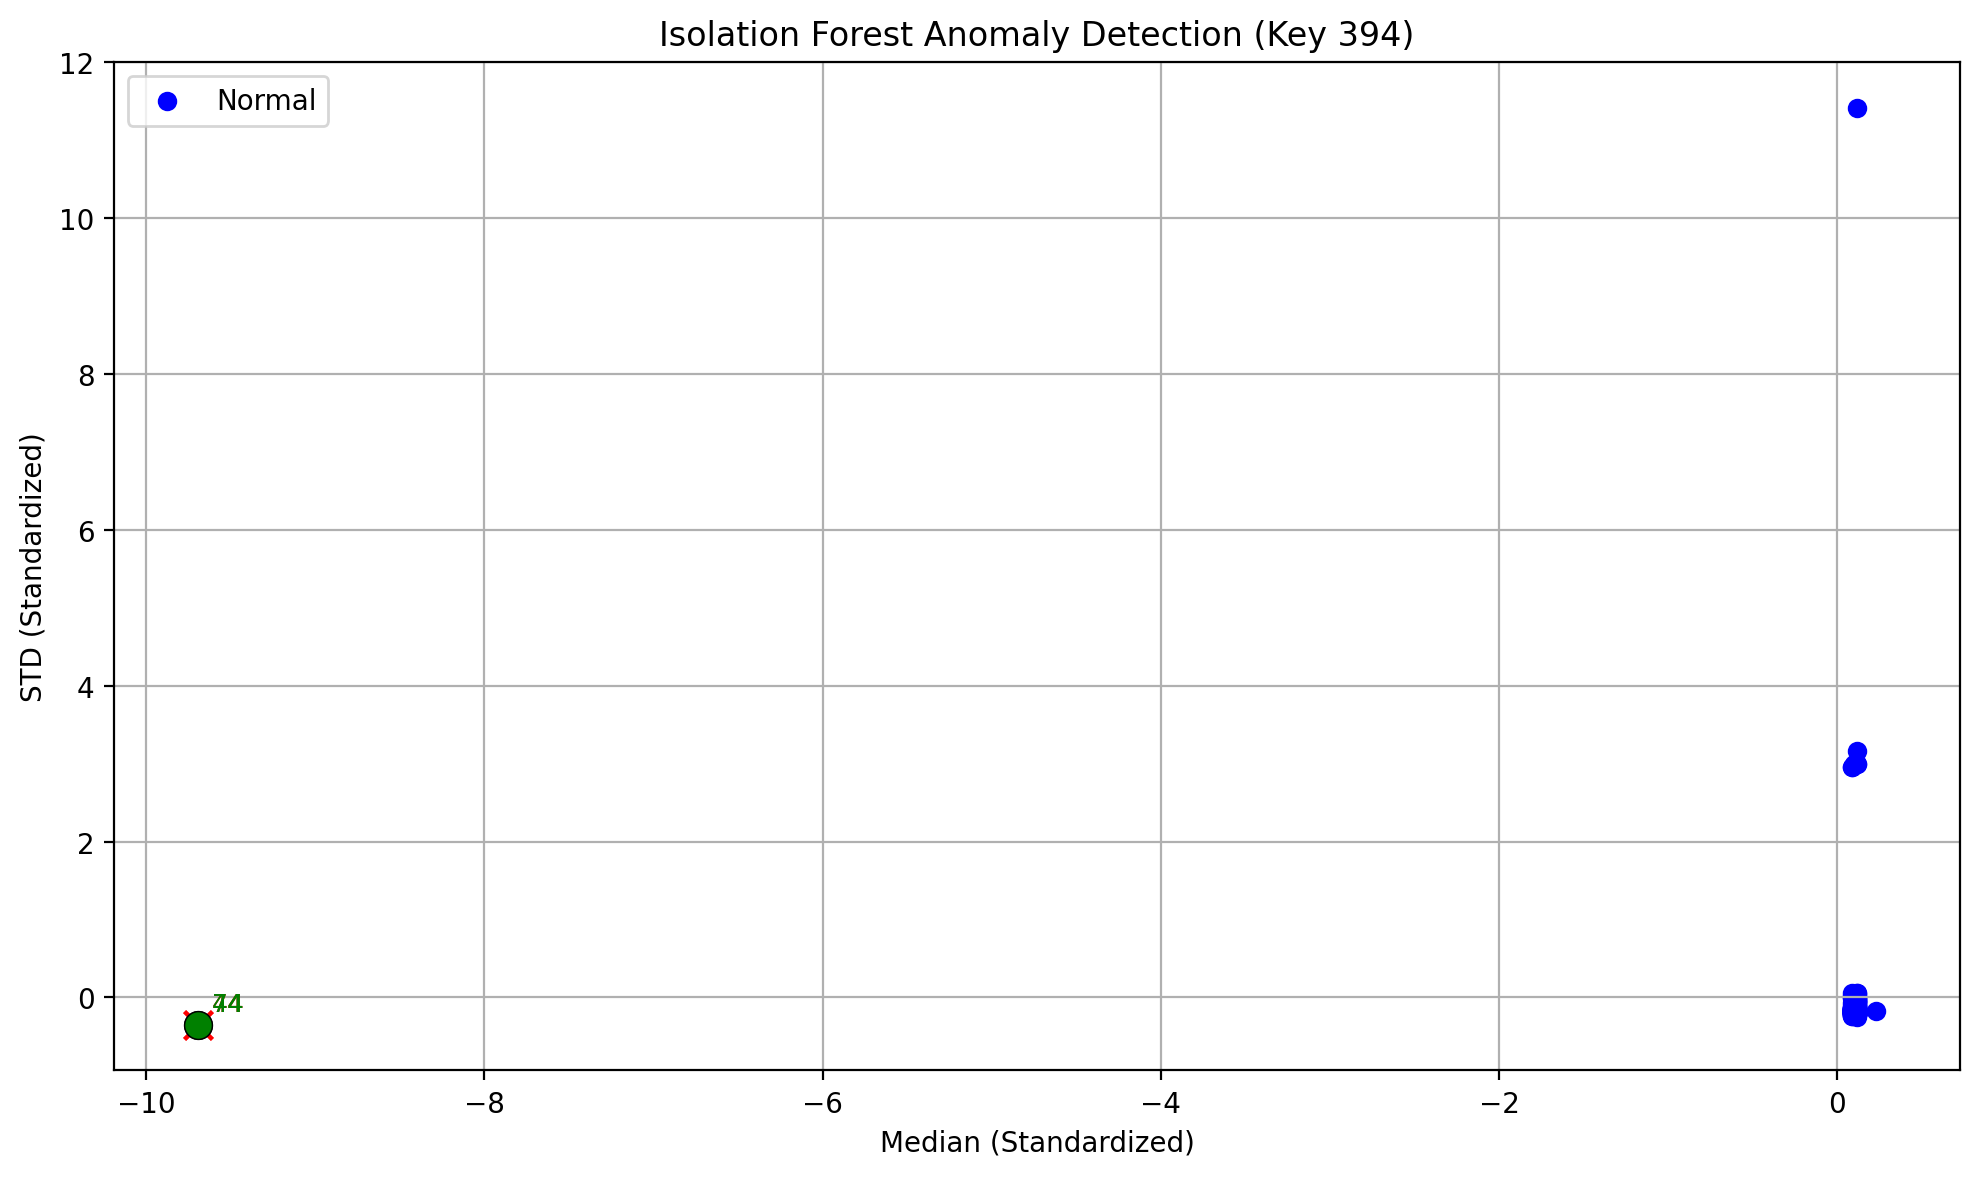

Anomalous sites detected for Key 394:
[44, 74]


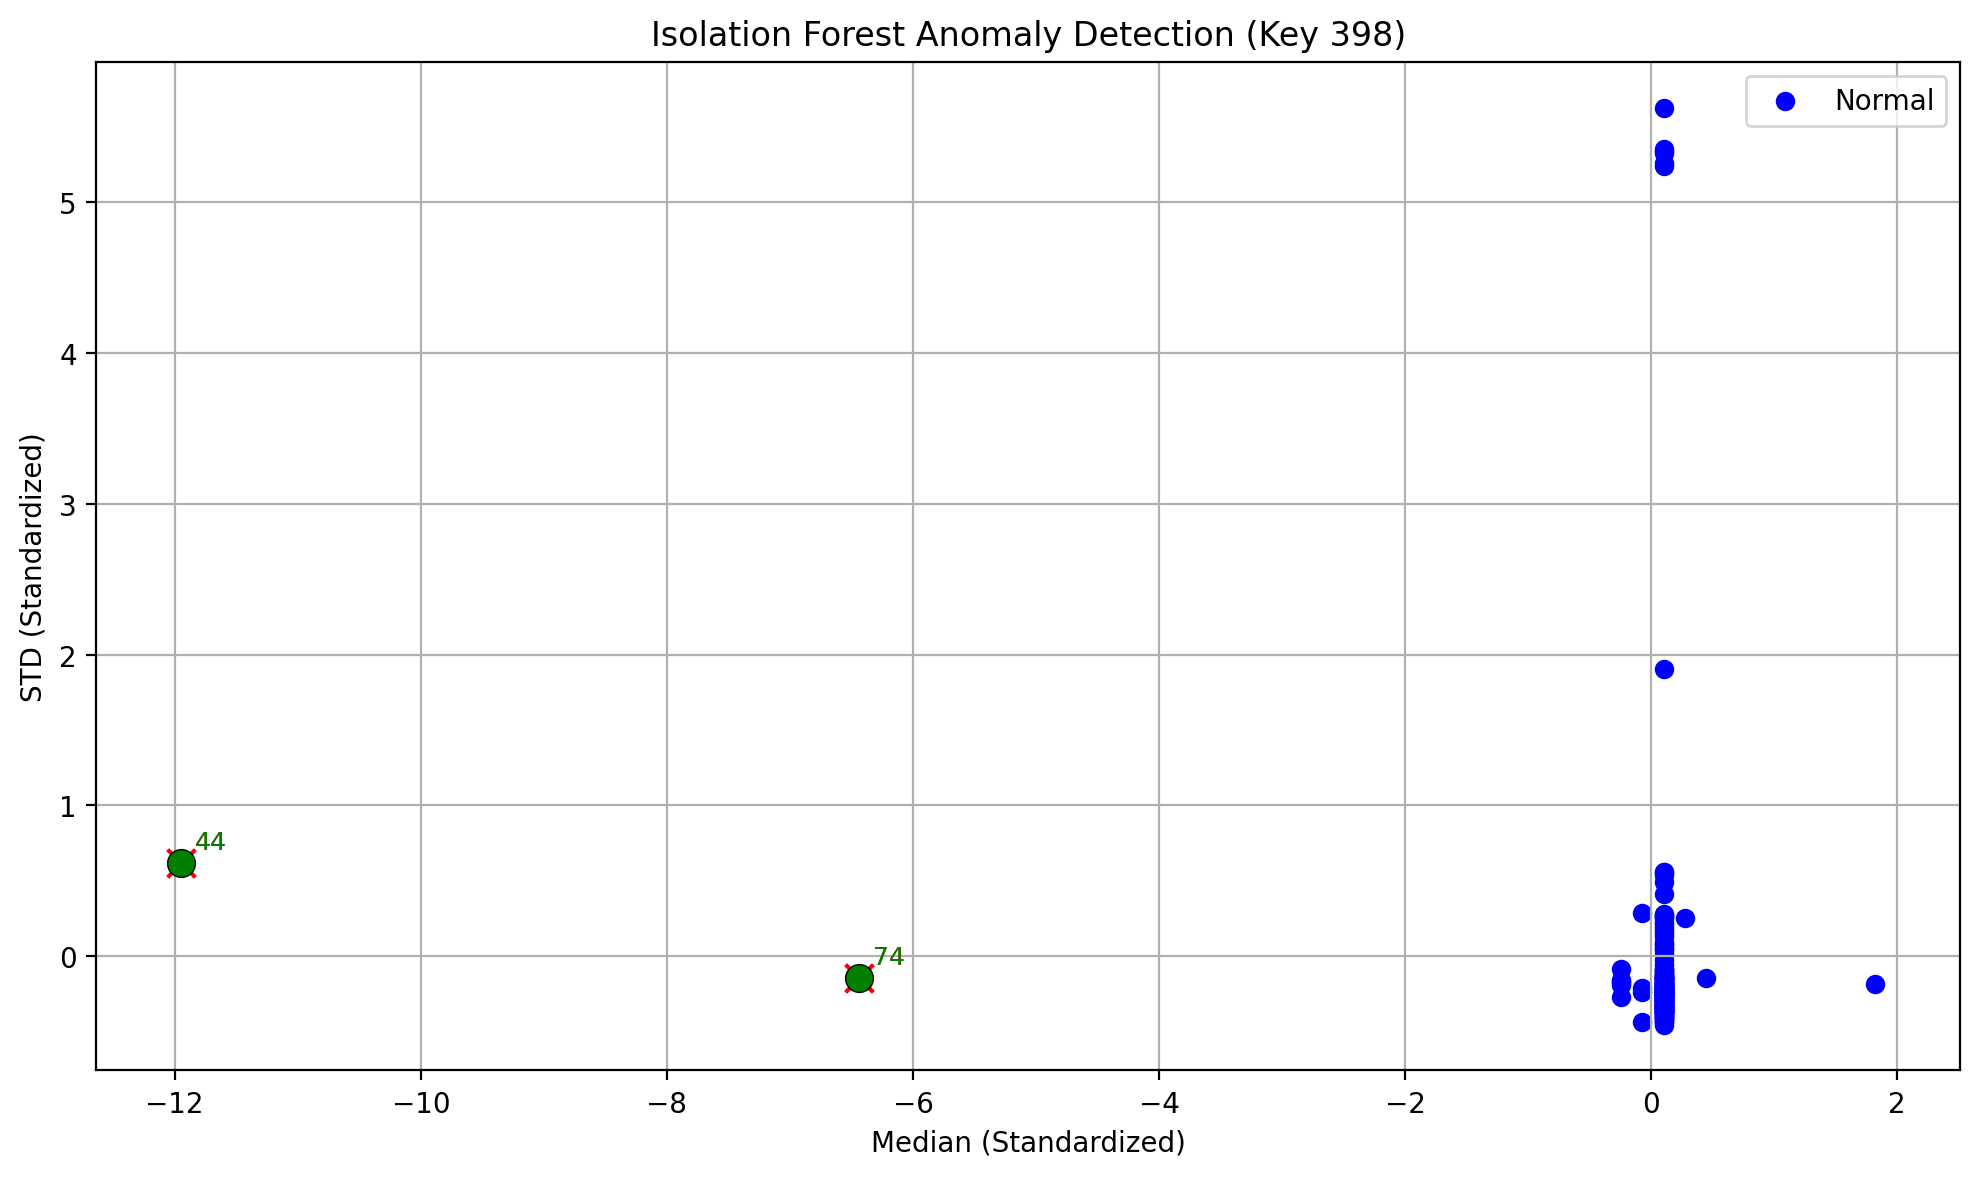

Anomalous sites detected for Key 398:
[44, 74]


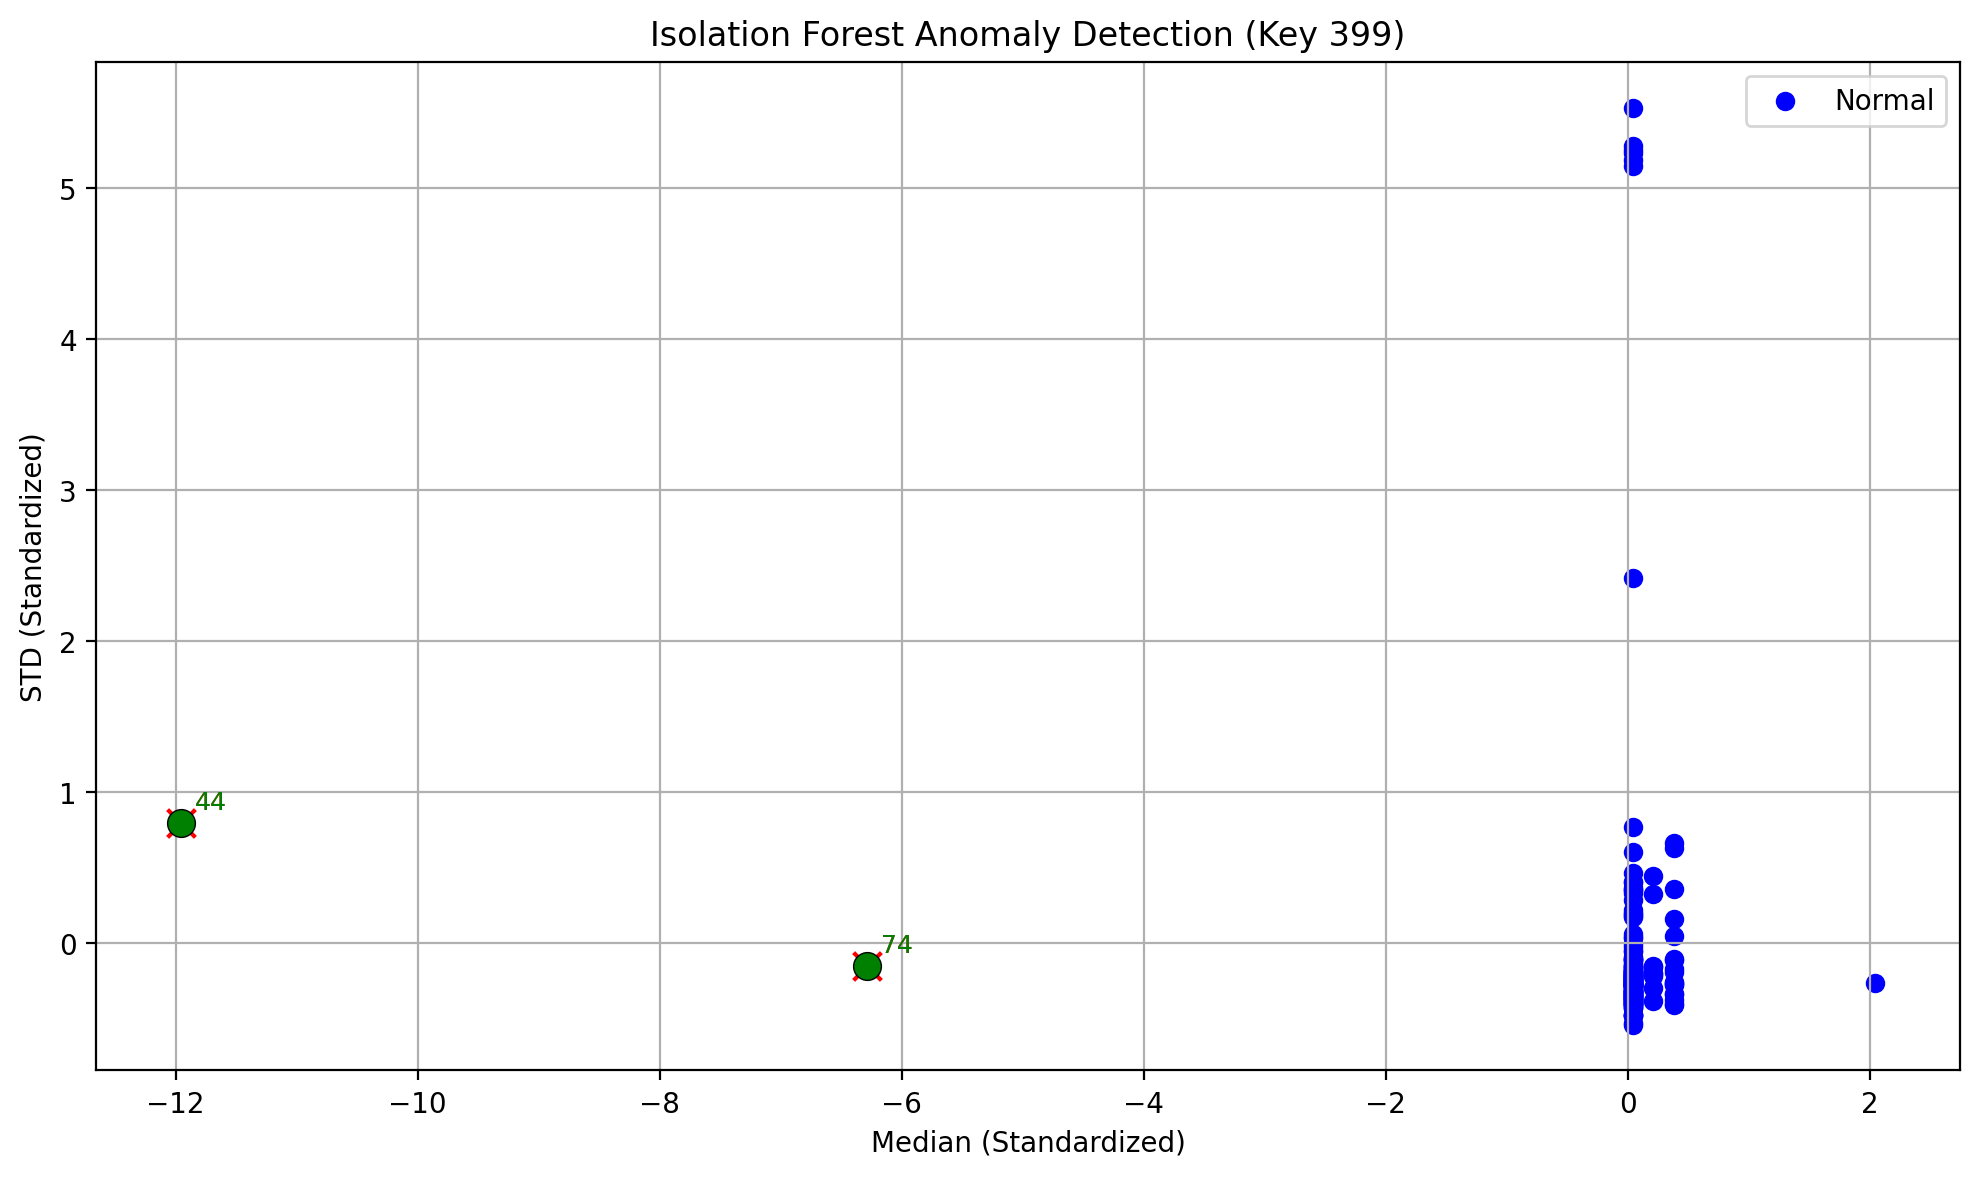

Anomalous sites detected for Key 399:
[44, 74]


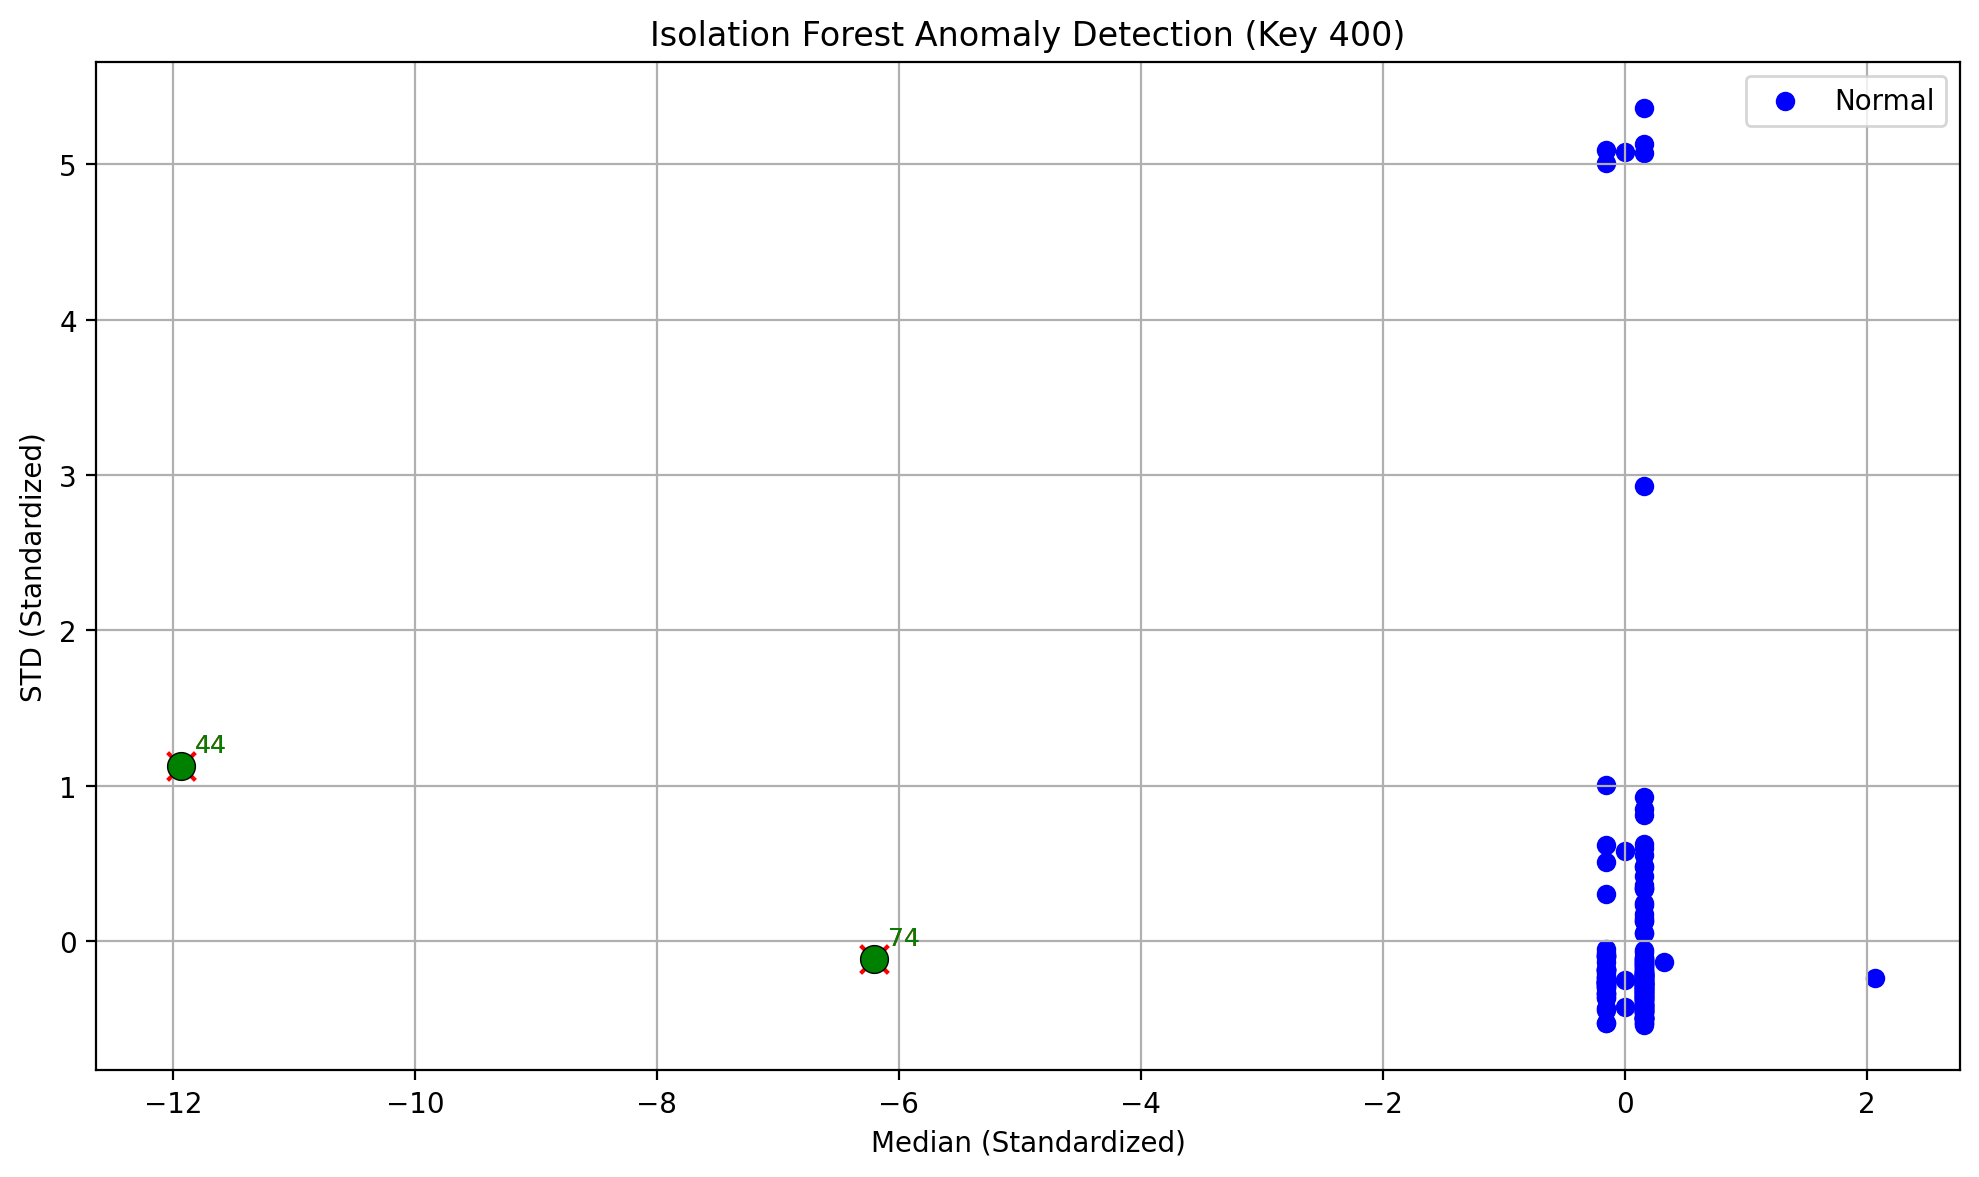

Anomalous sites detected for Key 400:
[44, 74]


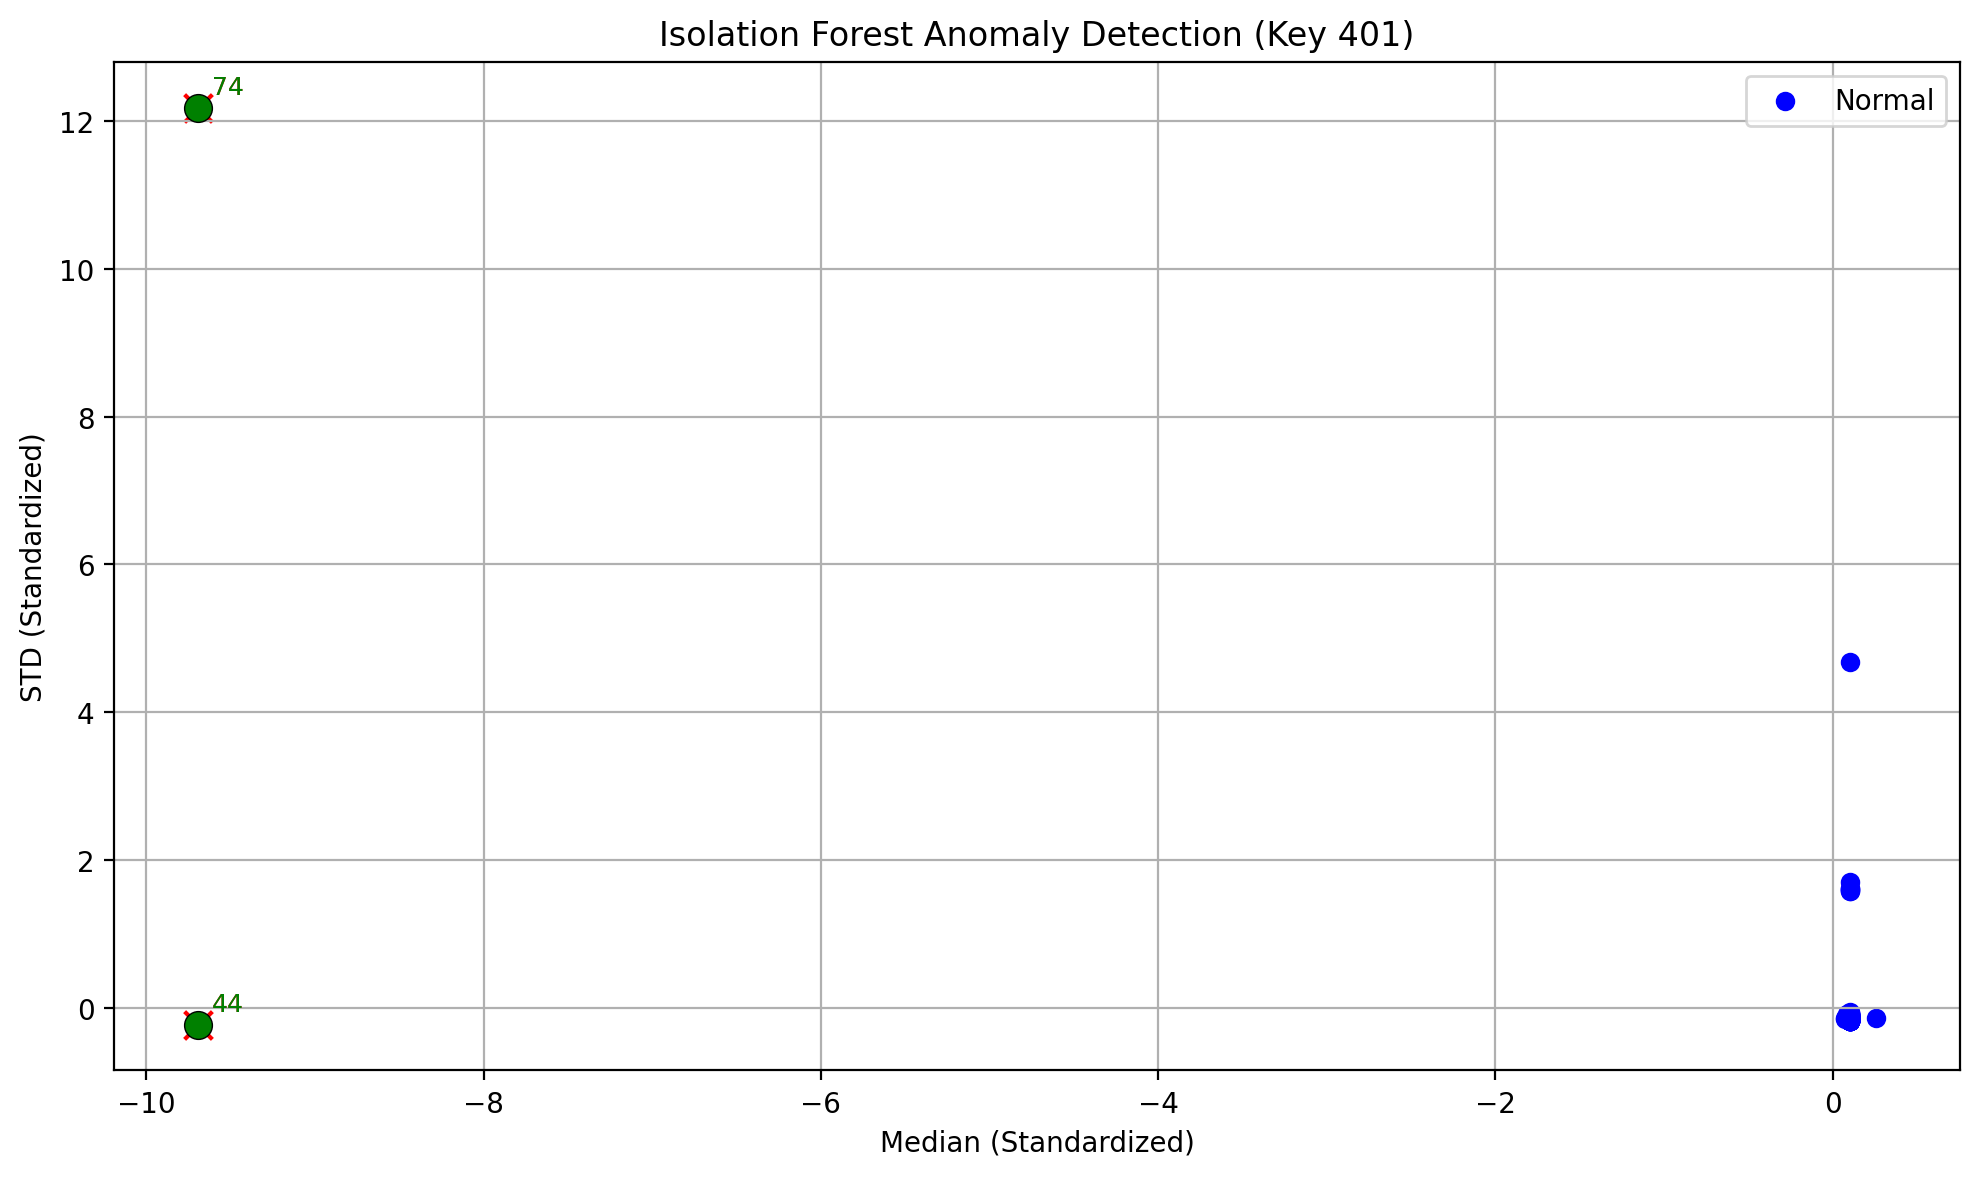

Anomalous sites detected for Key 401:
[44, 74]


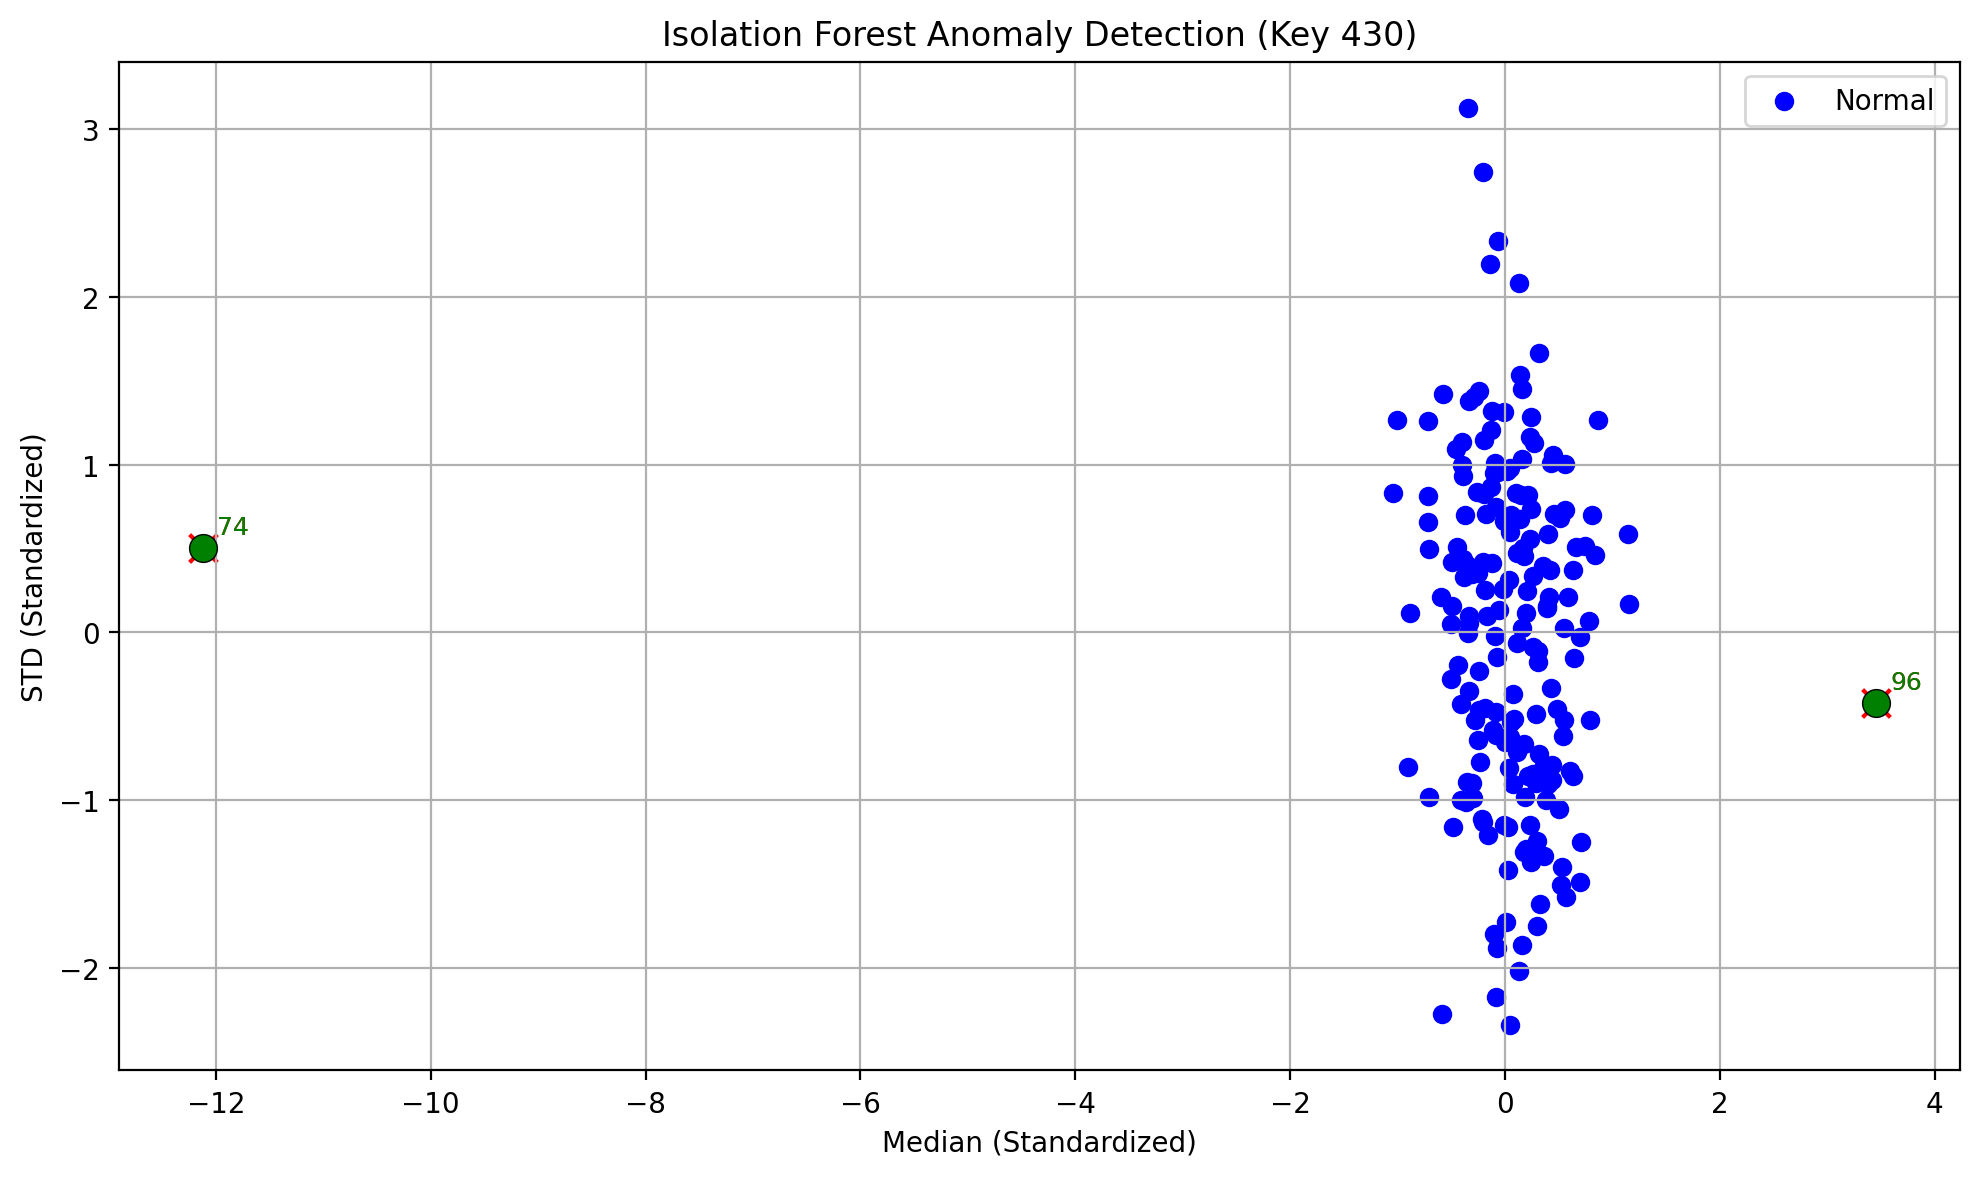

Anomalous sites detected for Key 430:
[74, 96]


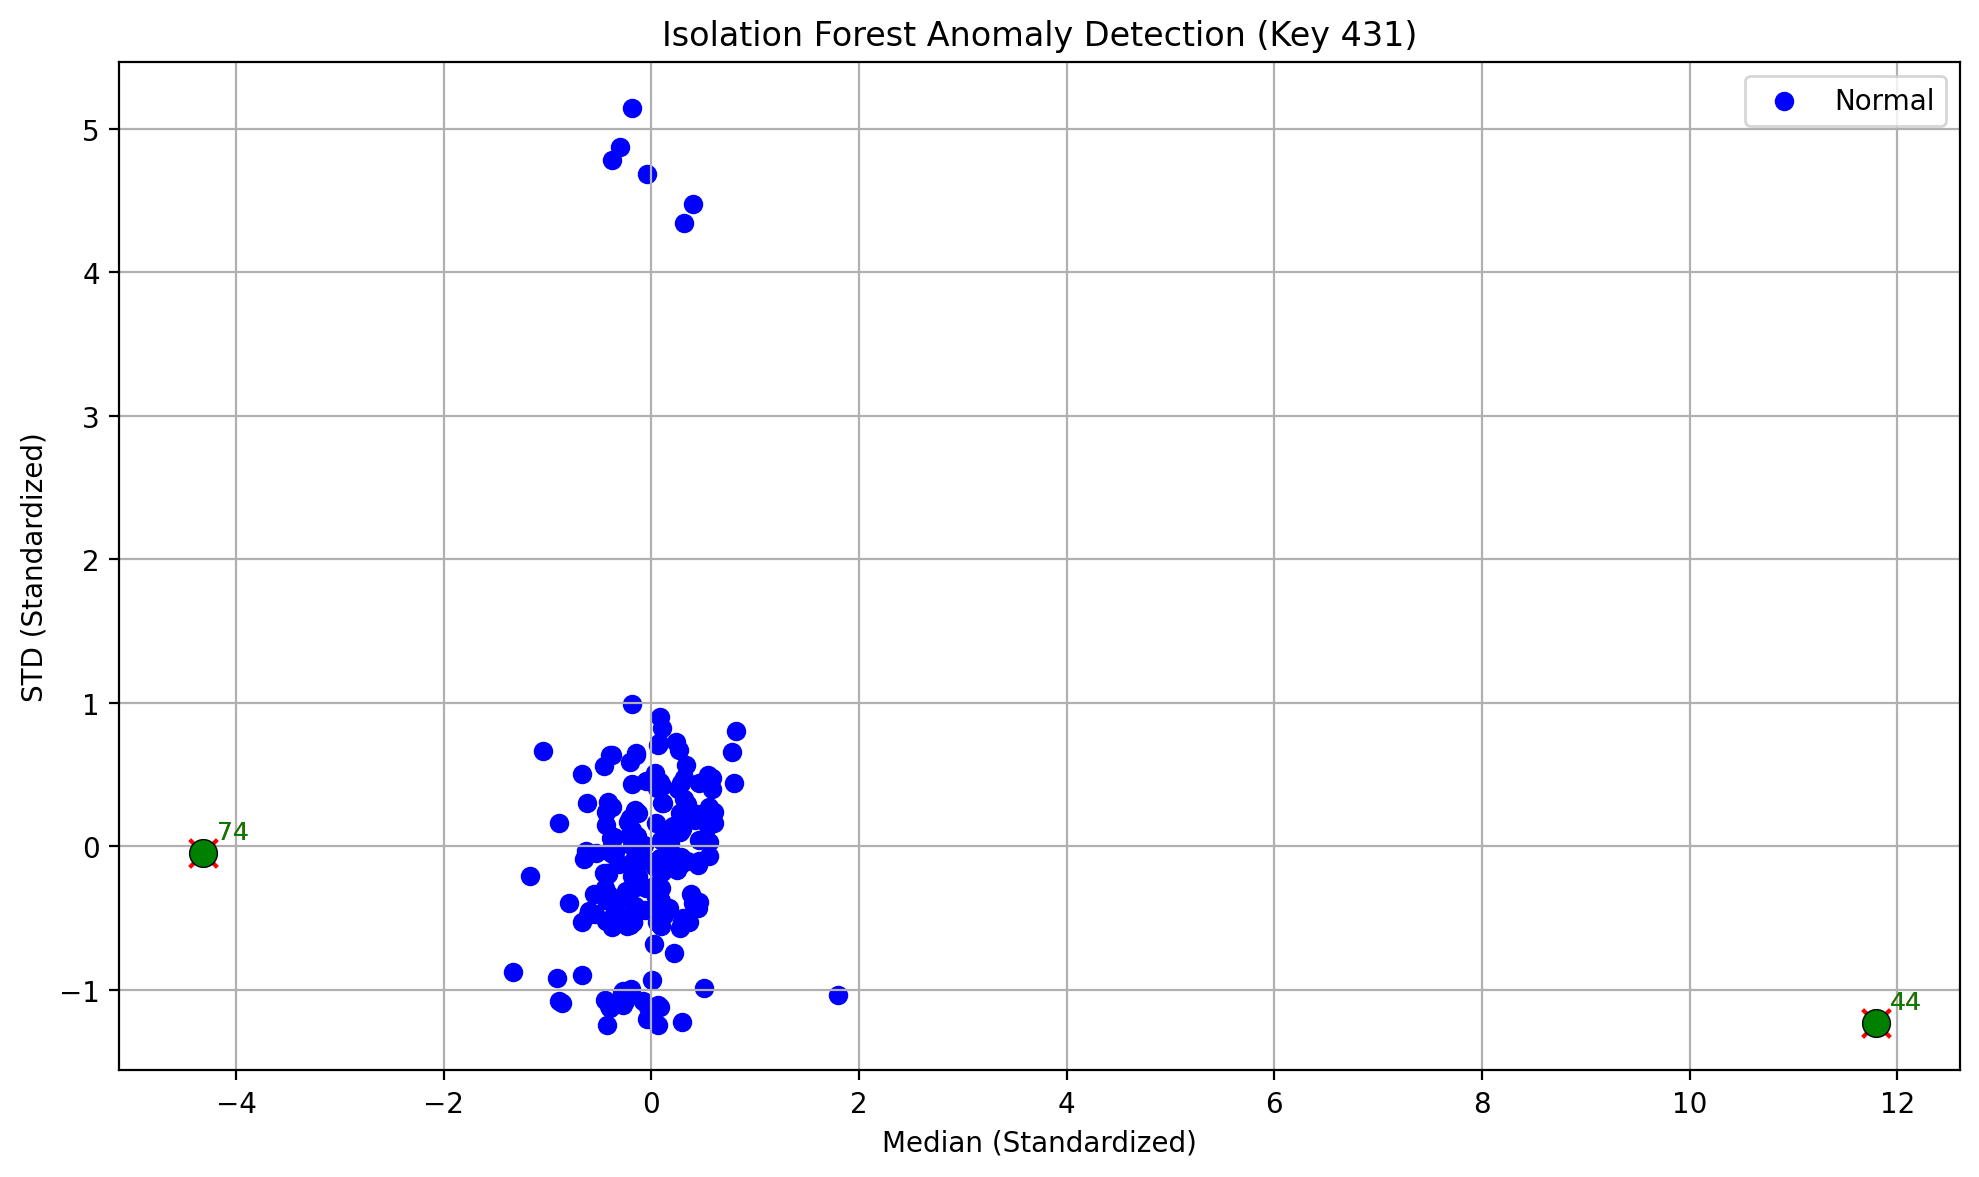

Anomalous sites detected for Key 431:
[44, 74]


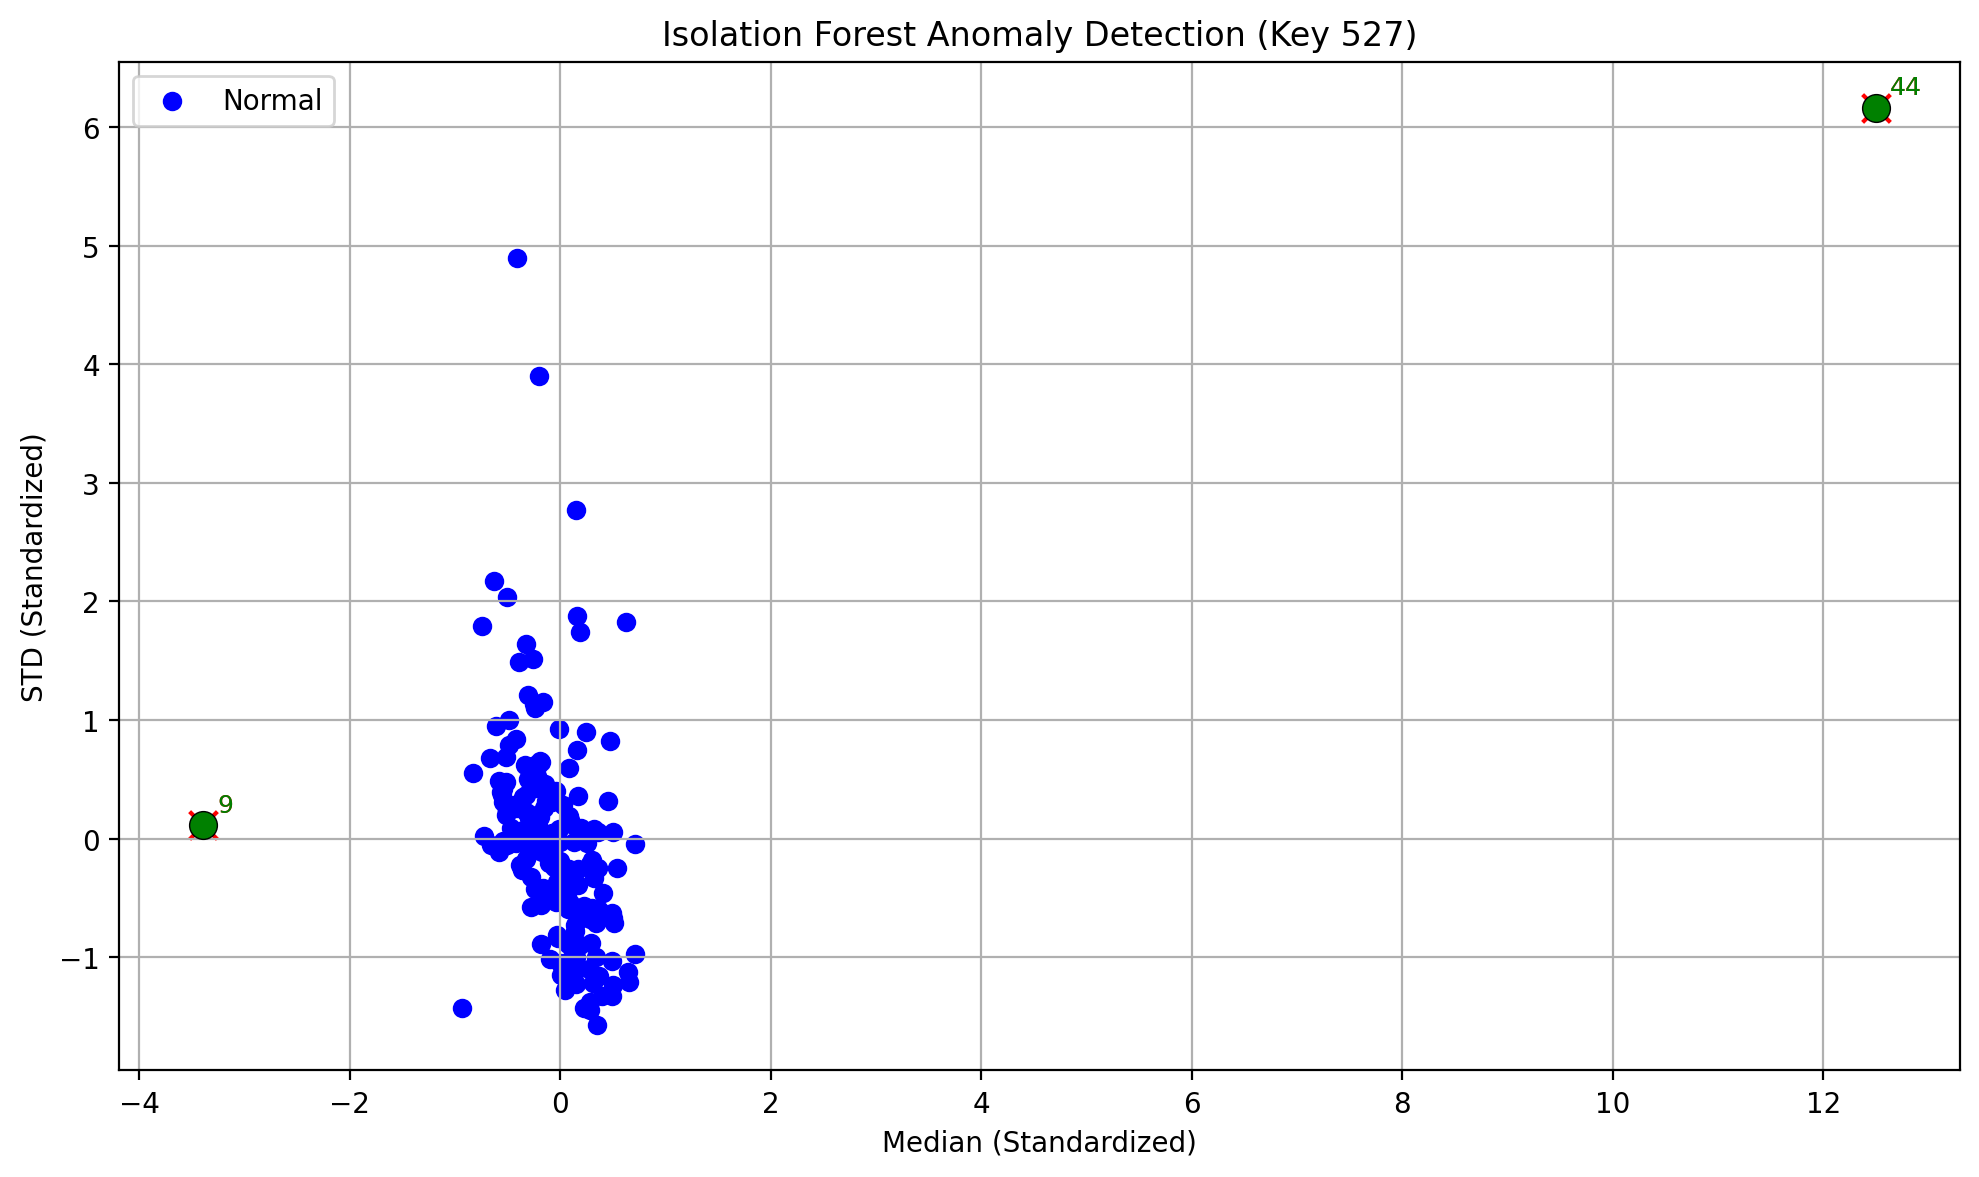

Anomalous sites detected for Key 527:
[9, 44]


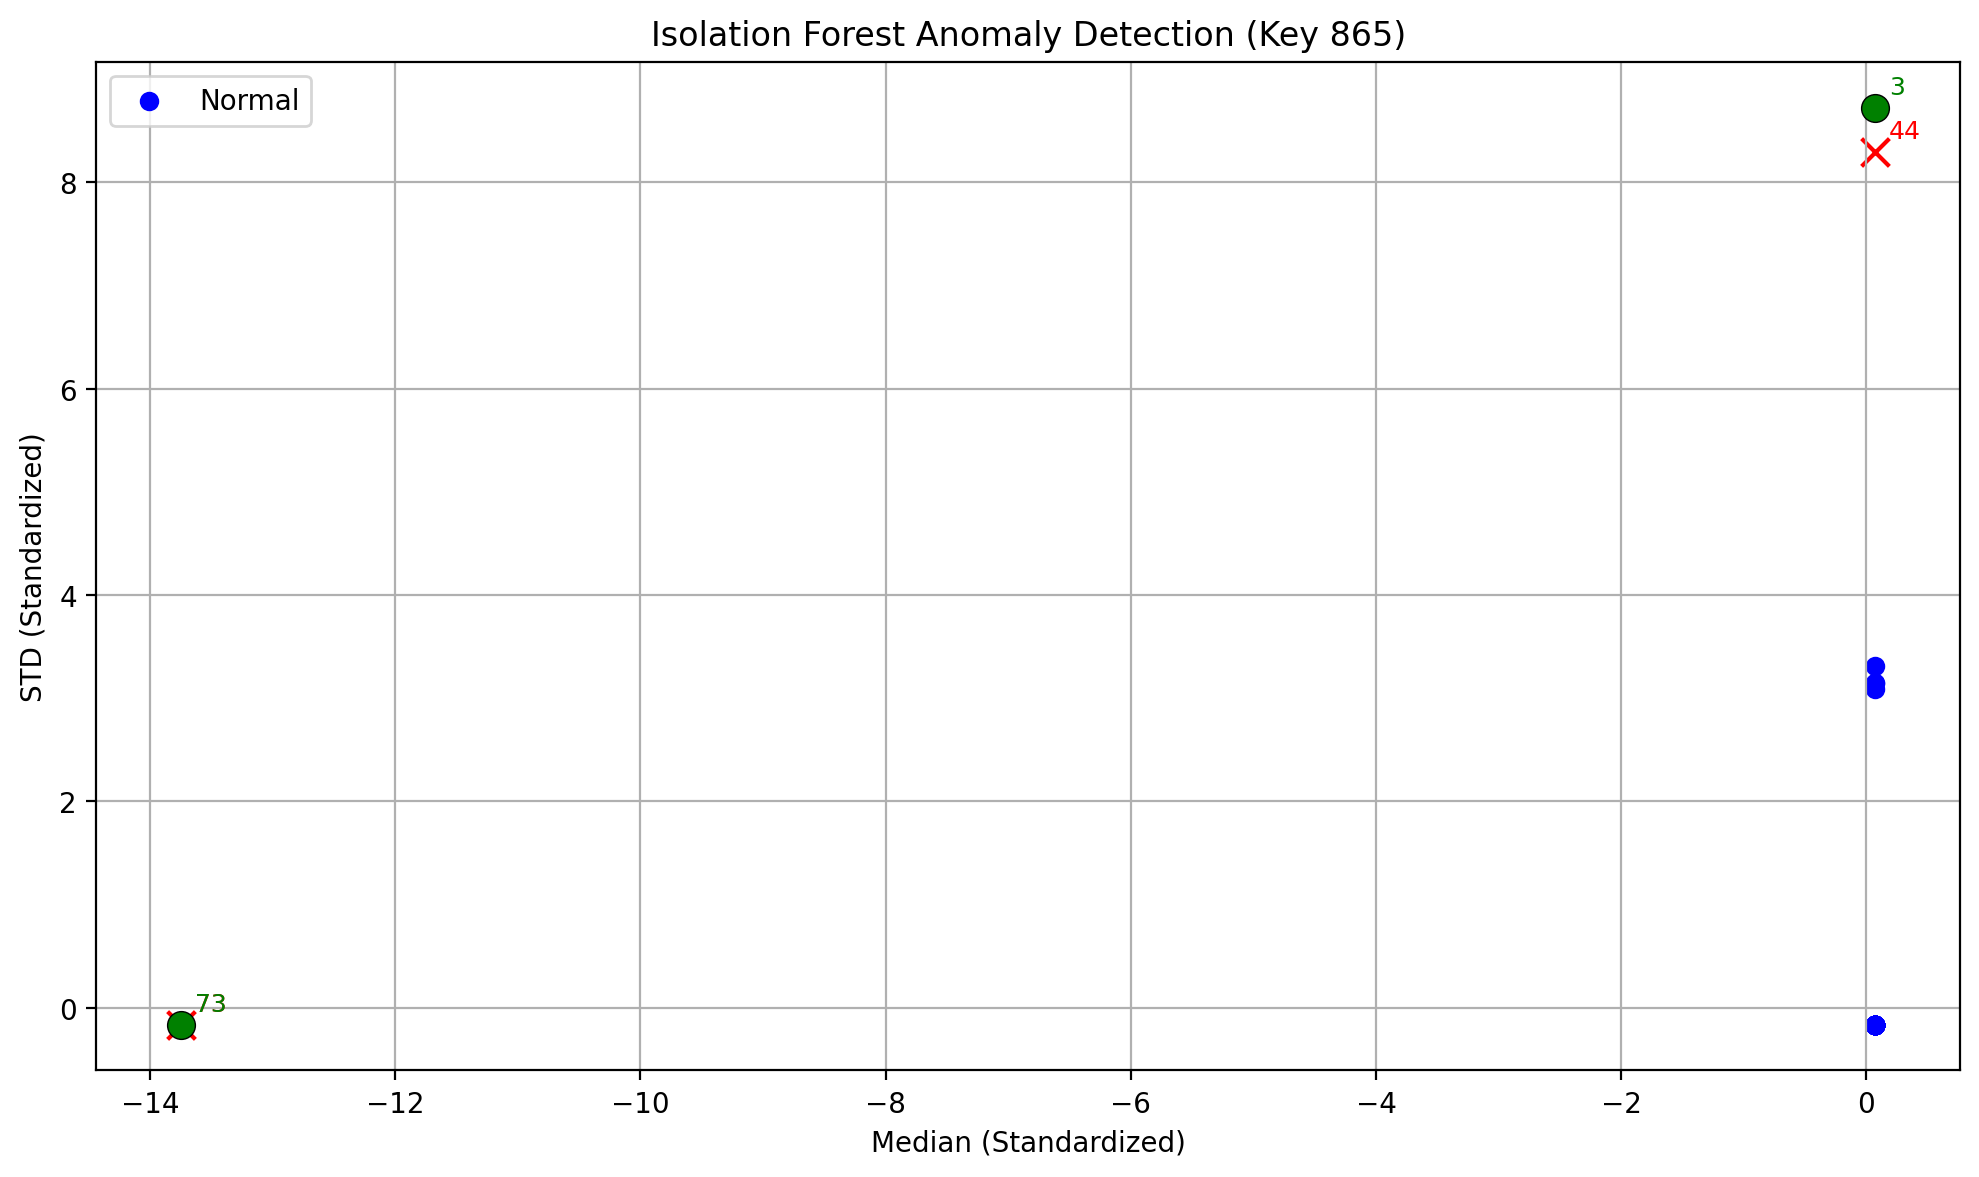

Anomalous sites detected for Key 865:
[44, 73]


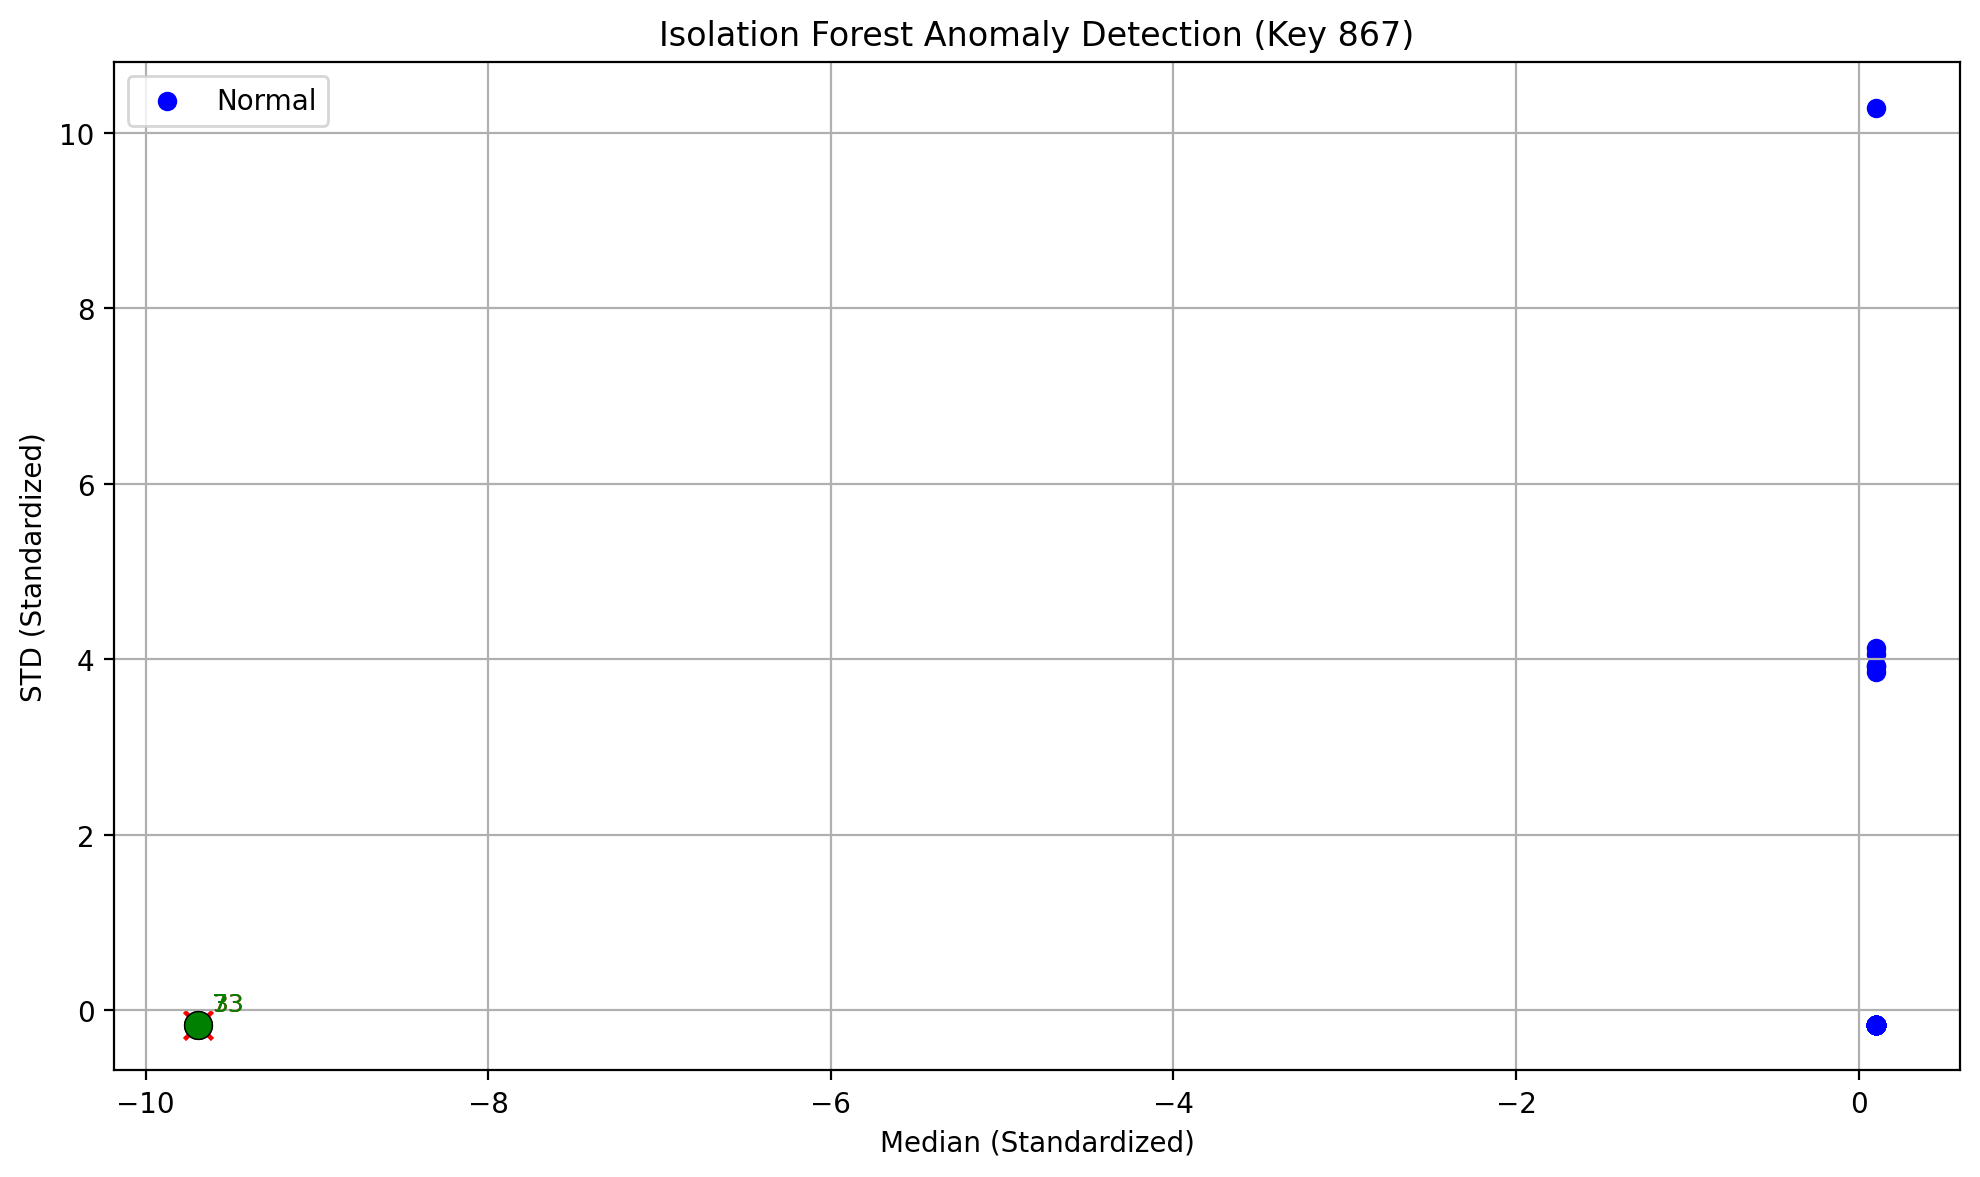

Anomalous sites detected for Key 867:
[3, 73]


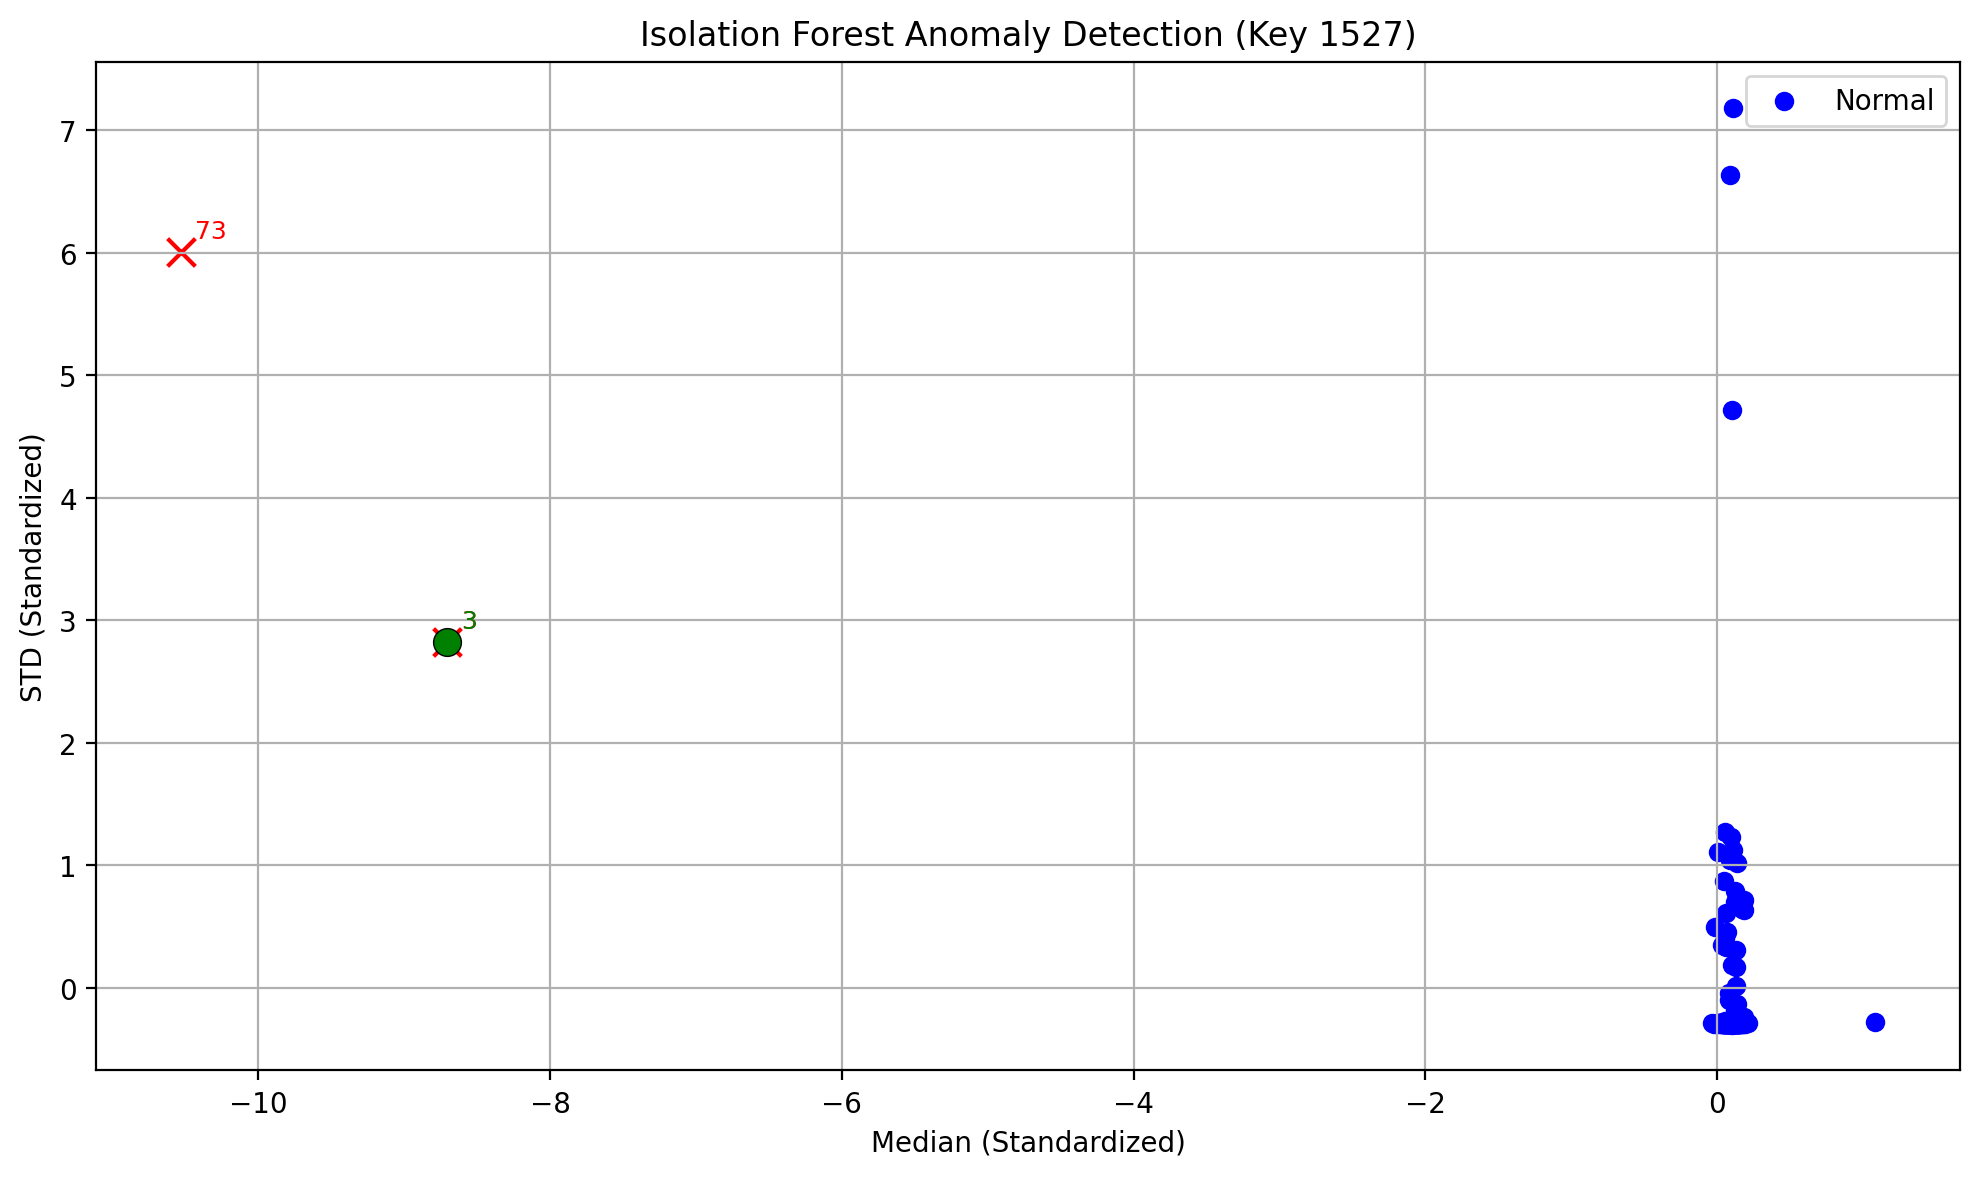

Anomalous sites detected for Key 1527:
[3, 73]


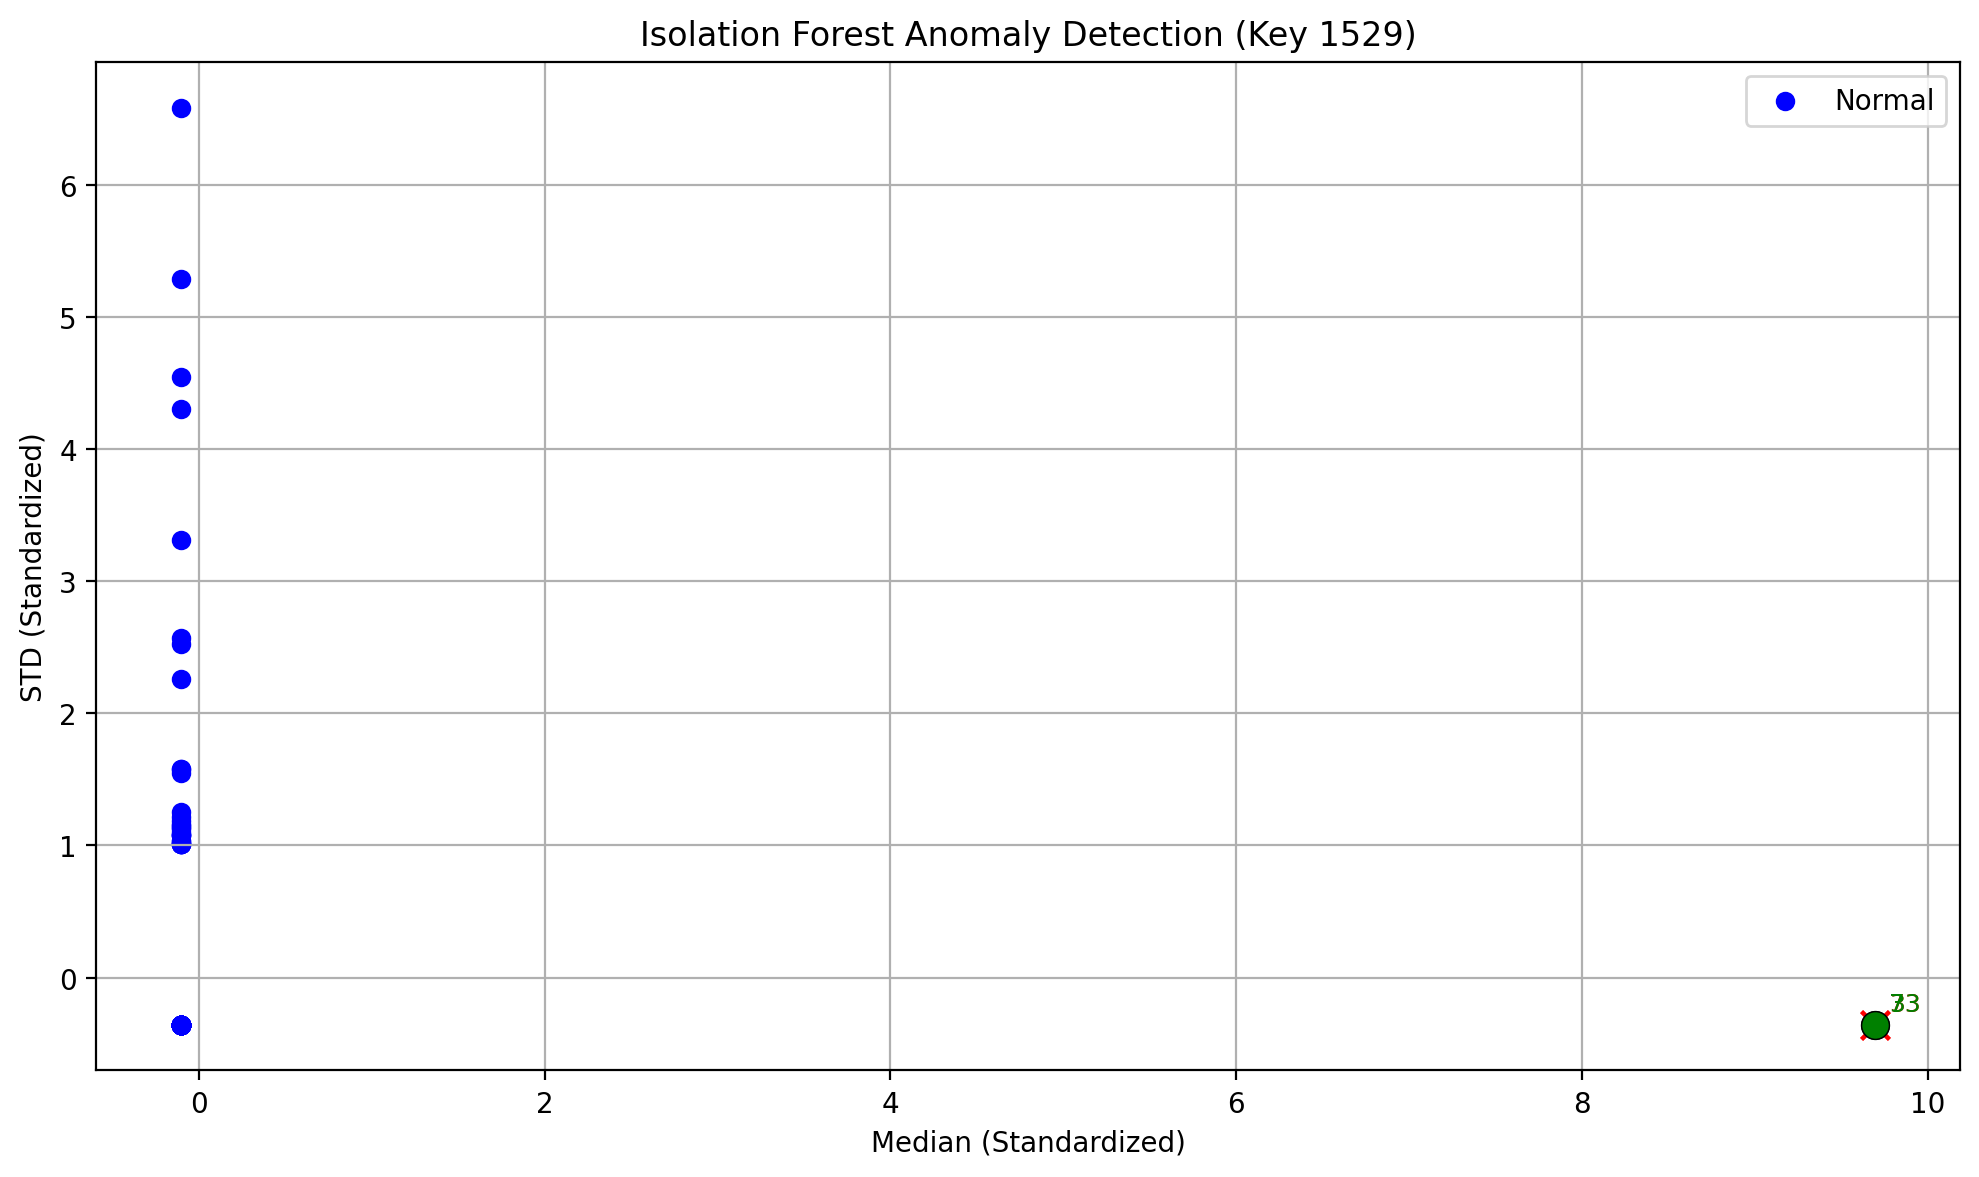

Anomalous sites detected for Key 1529:
[3, 73]


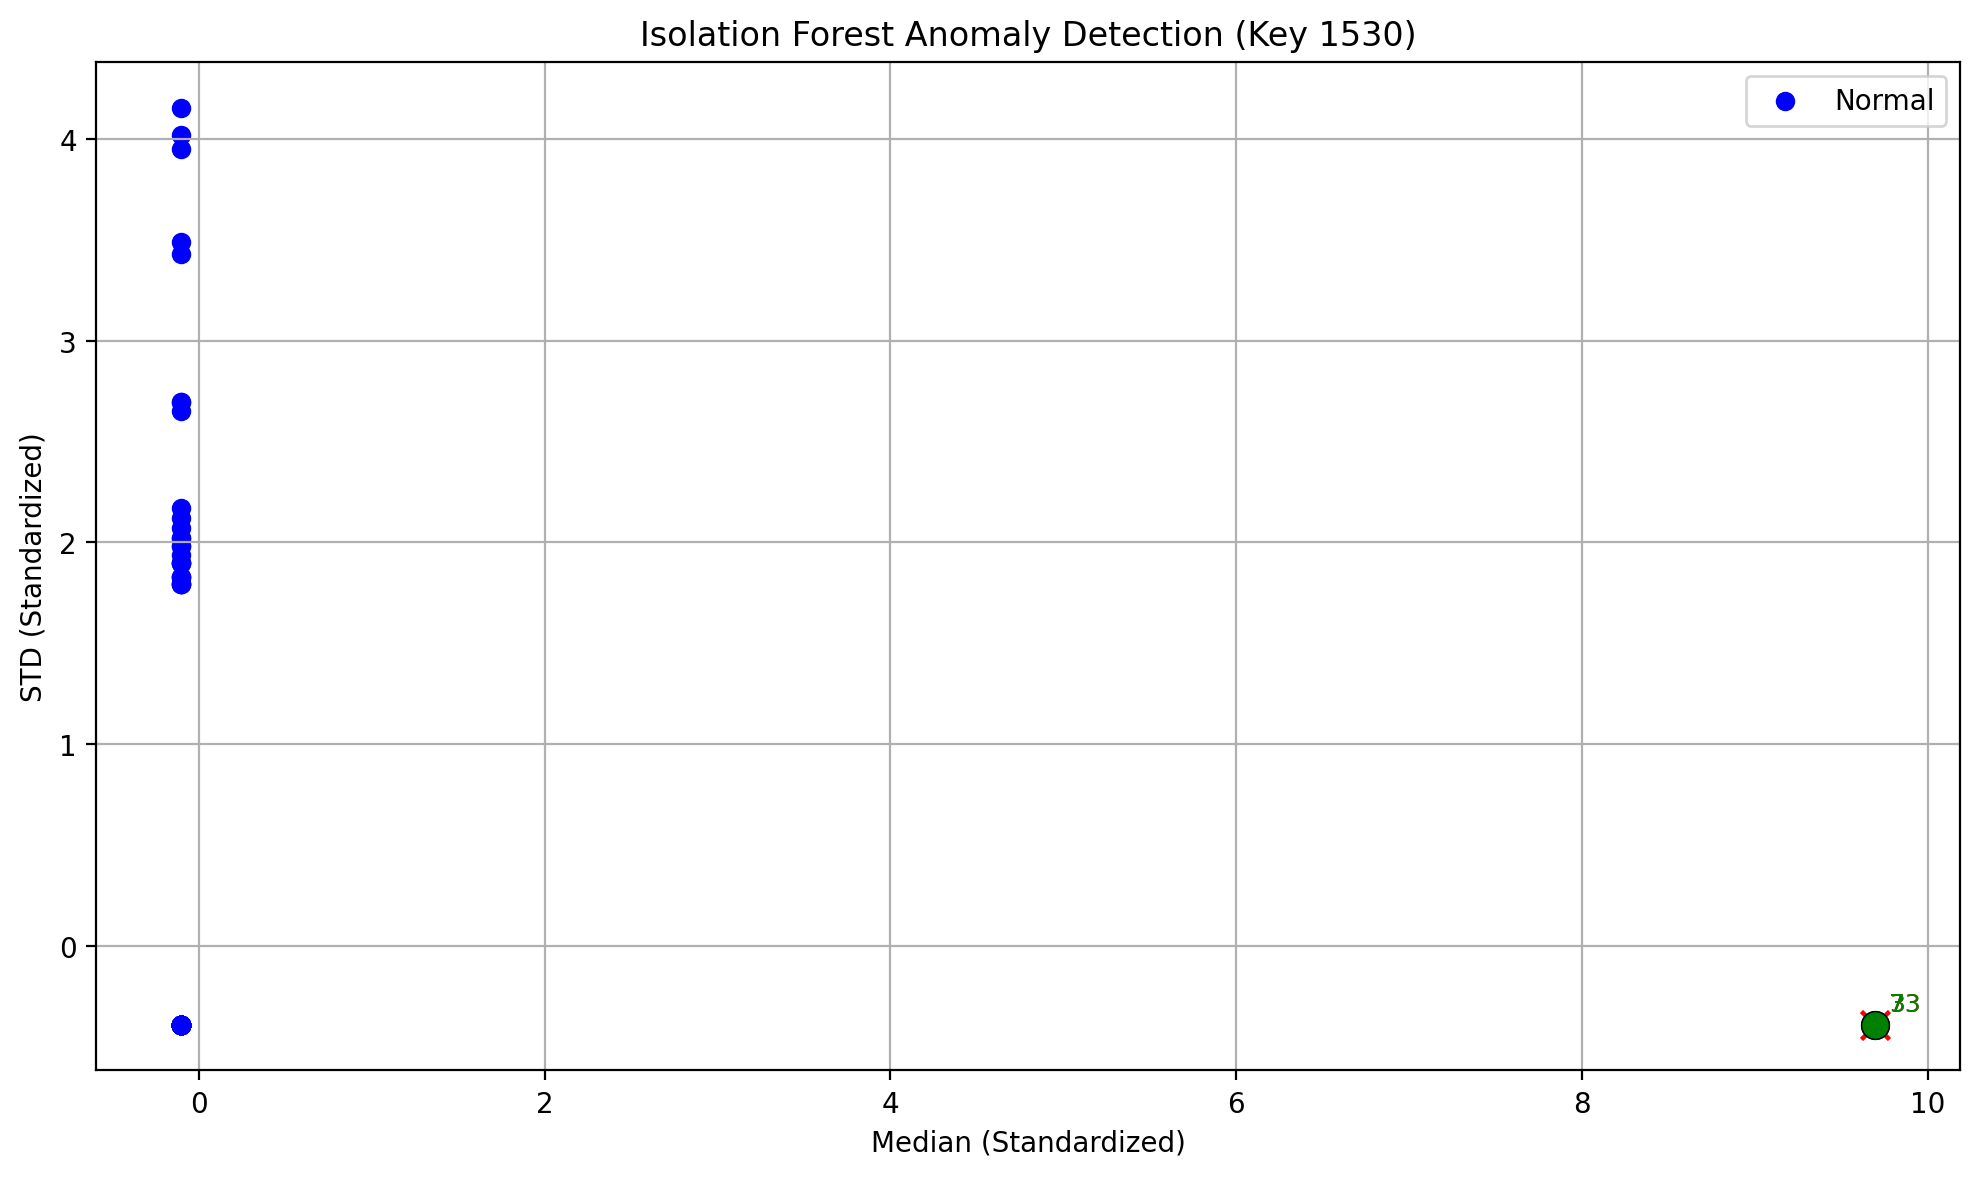

Anomalous sites detected for Key 1530:
[3, 73]


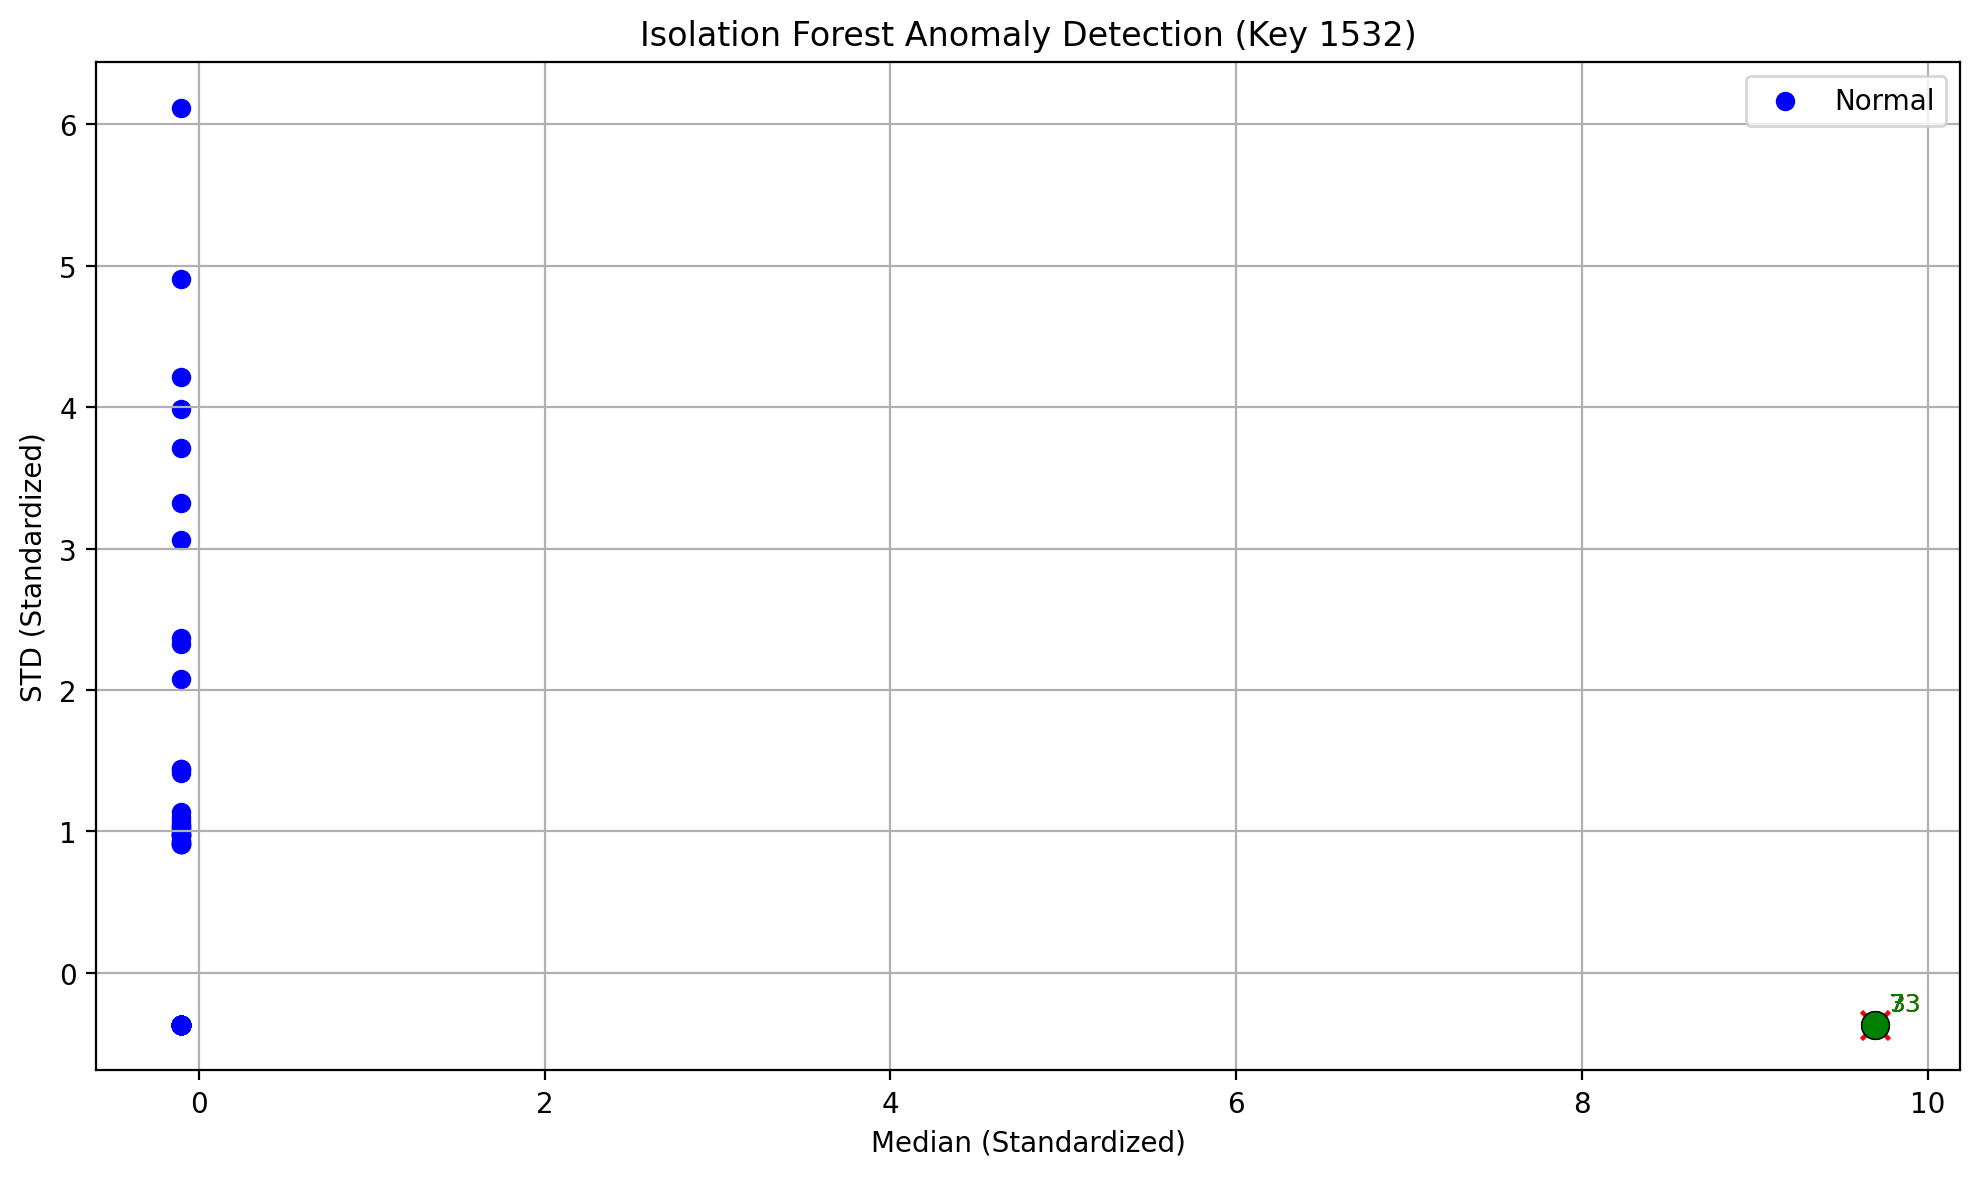

Anomalous sites detected for Key 1532:
[3, 73]


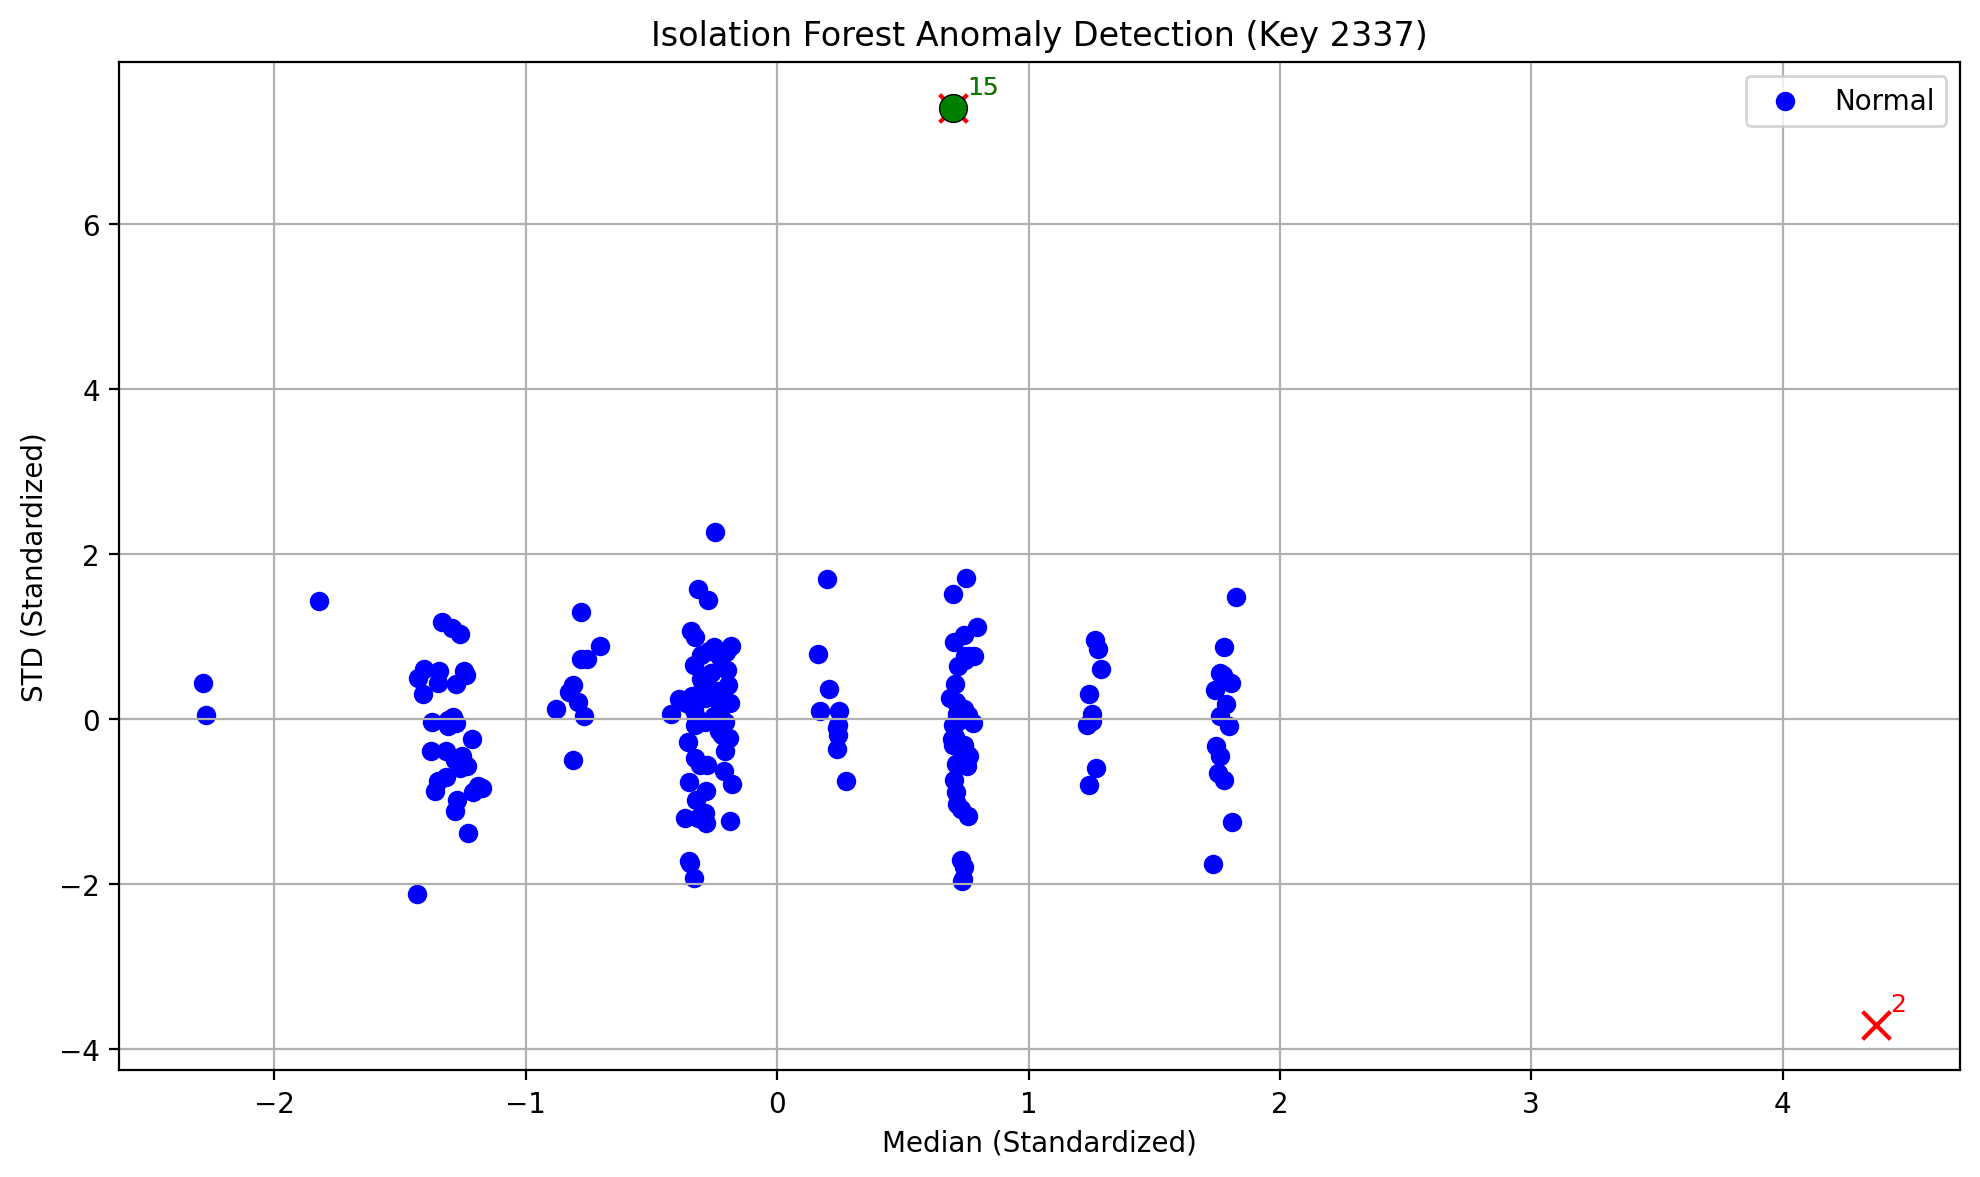

Anomalous sites detected for Key 2337:
[2, 15]


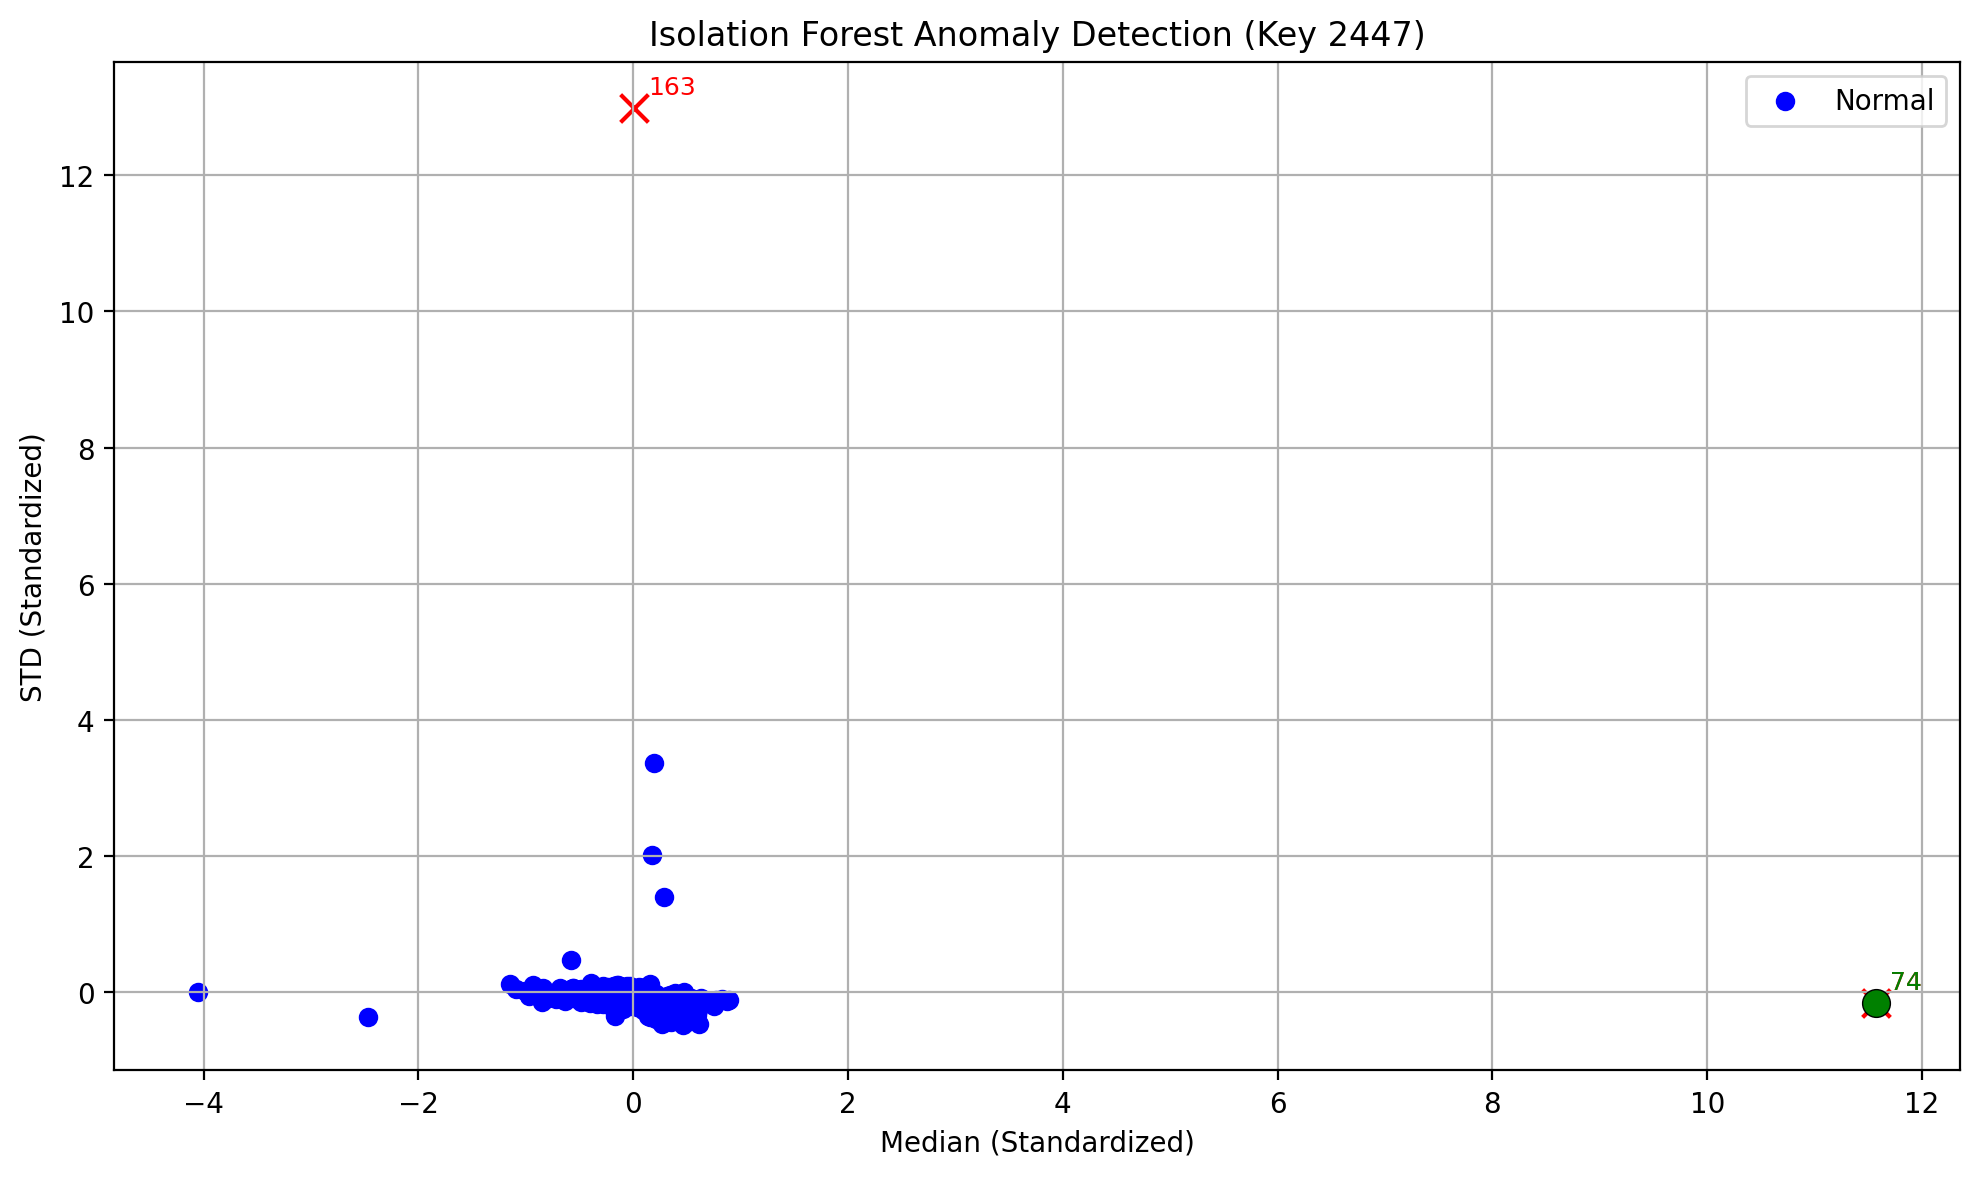

Anomalous sites detected for Key 2447:
[74, 163]


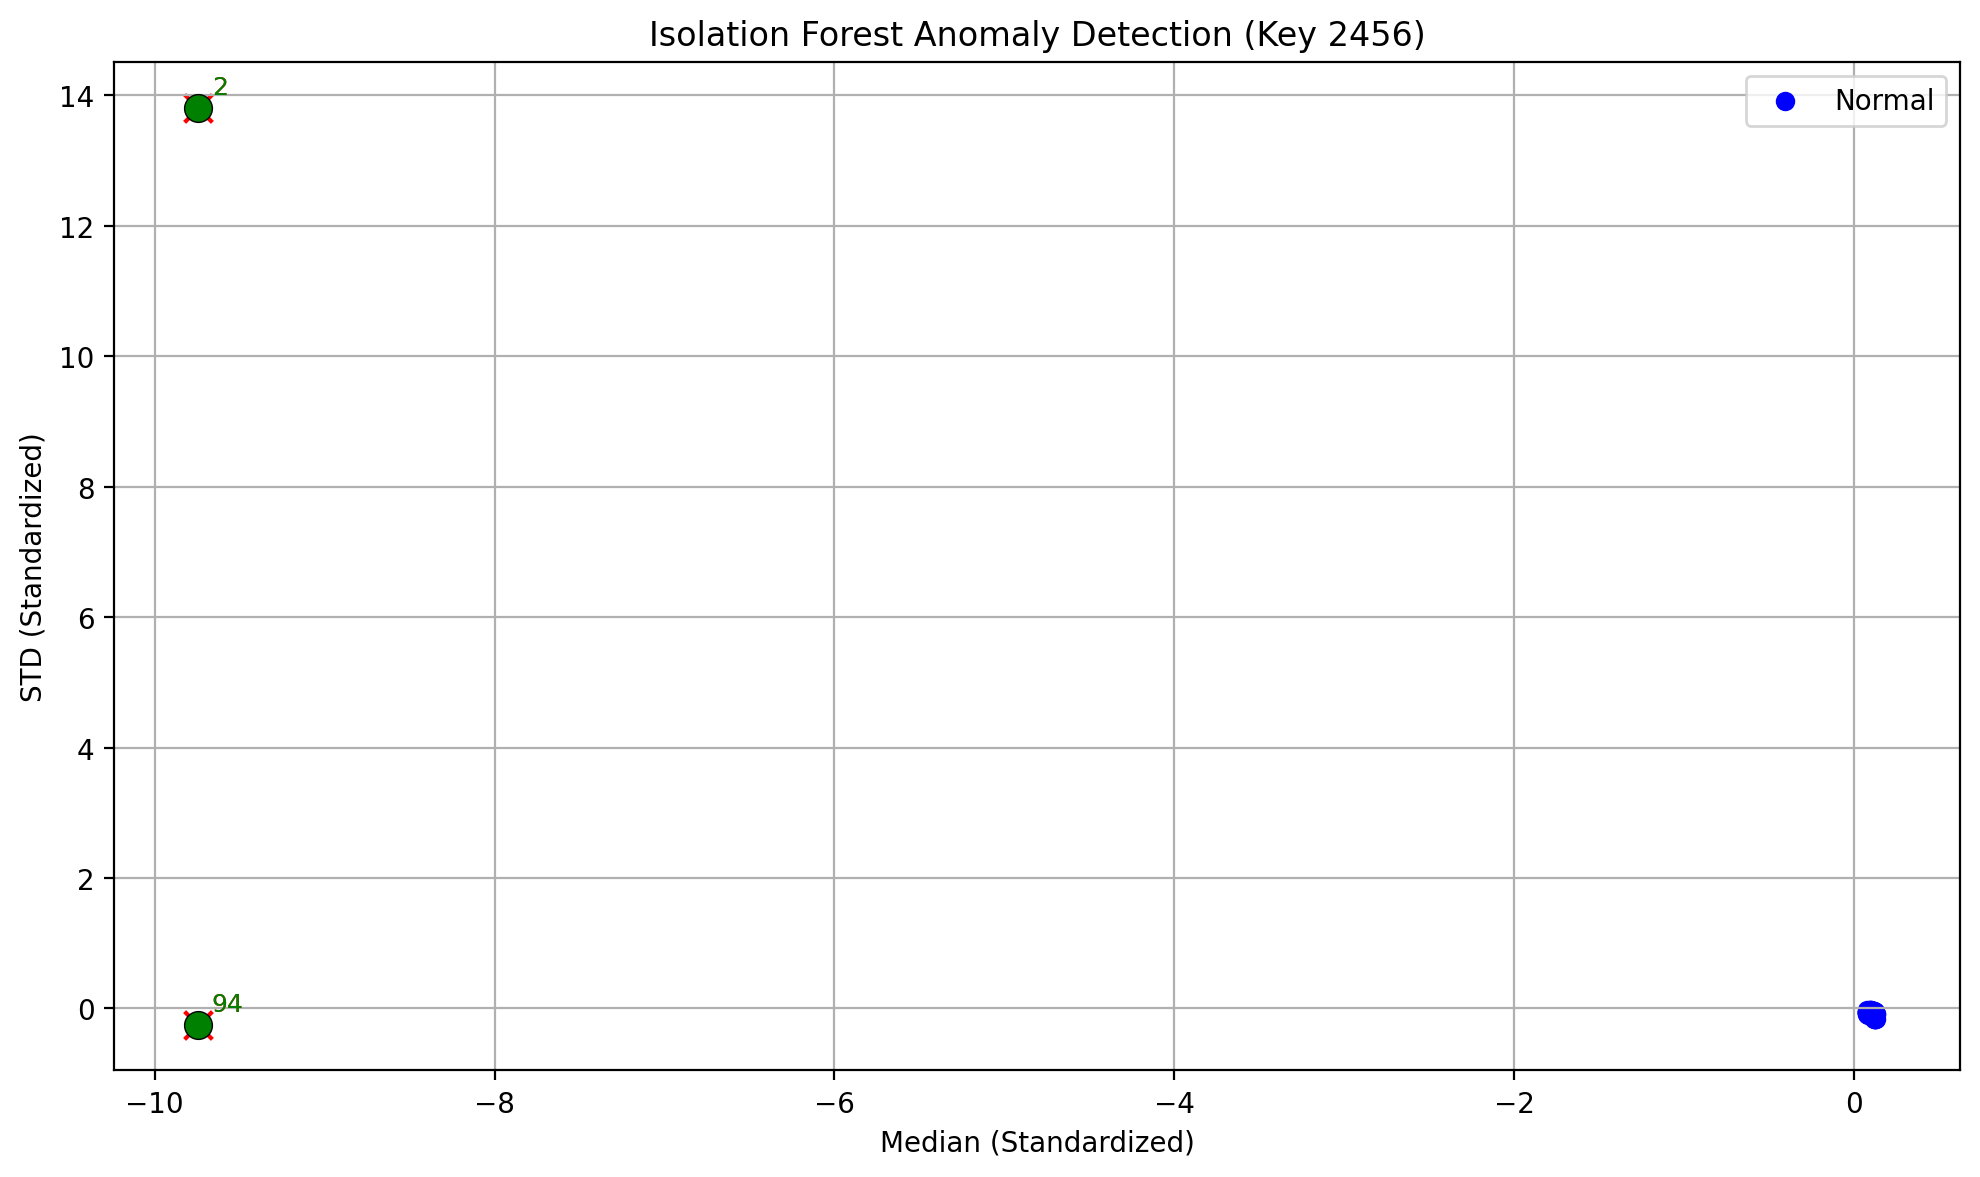

Anomalous sites detected for Key 2456:
[2, 94]


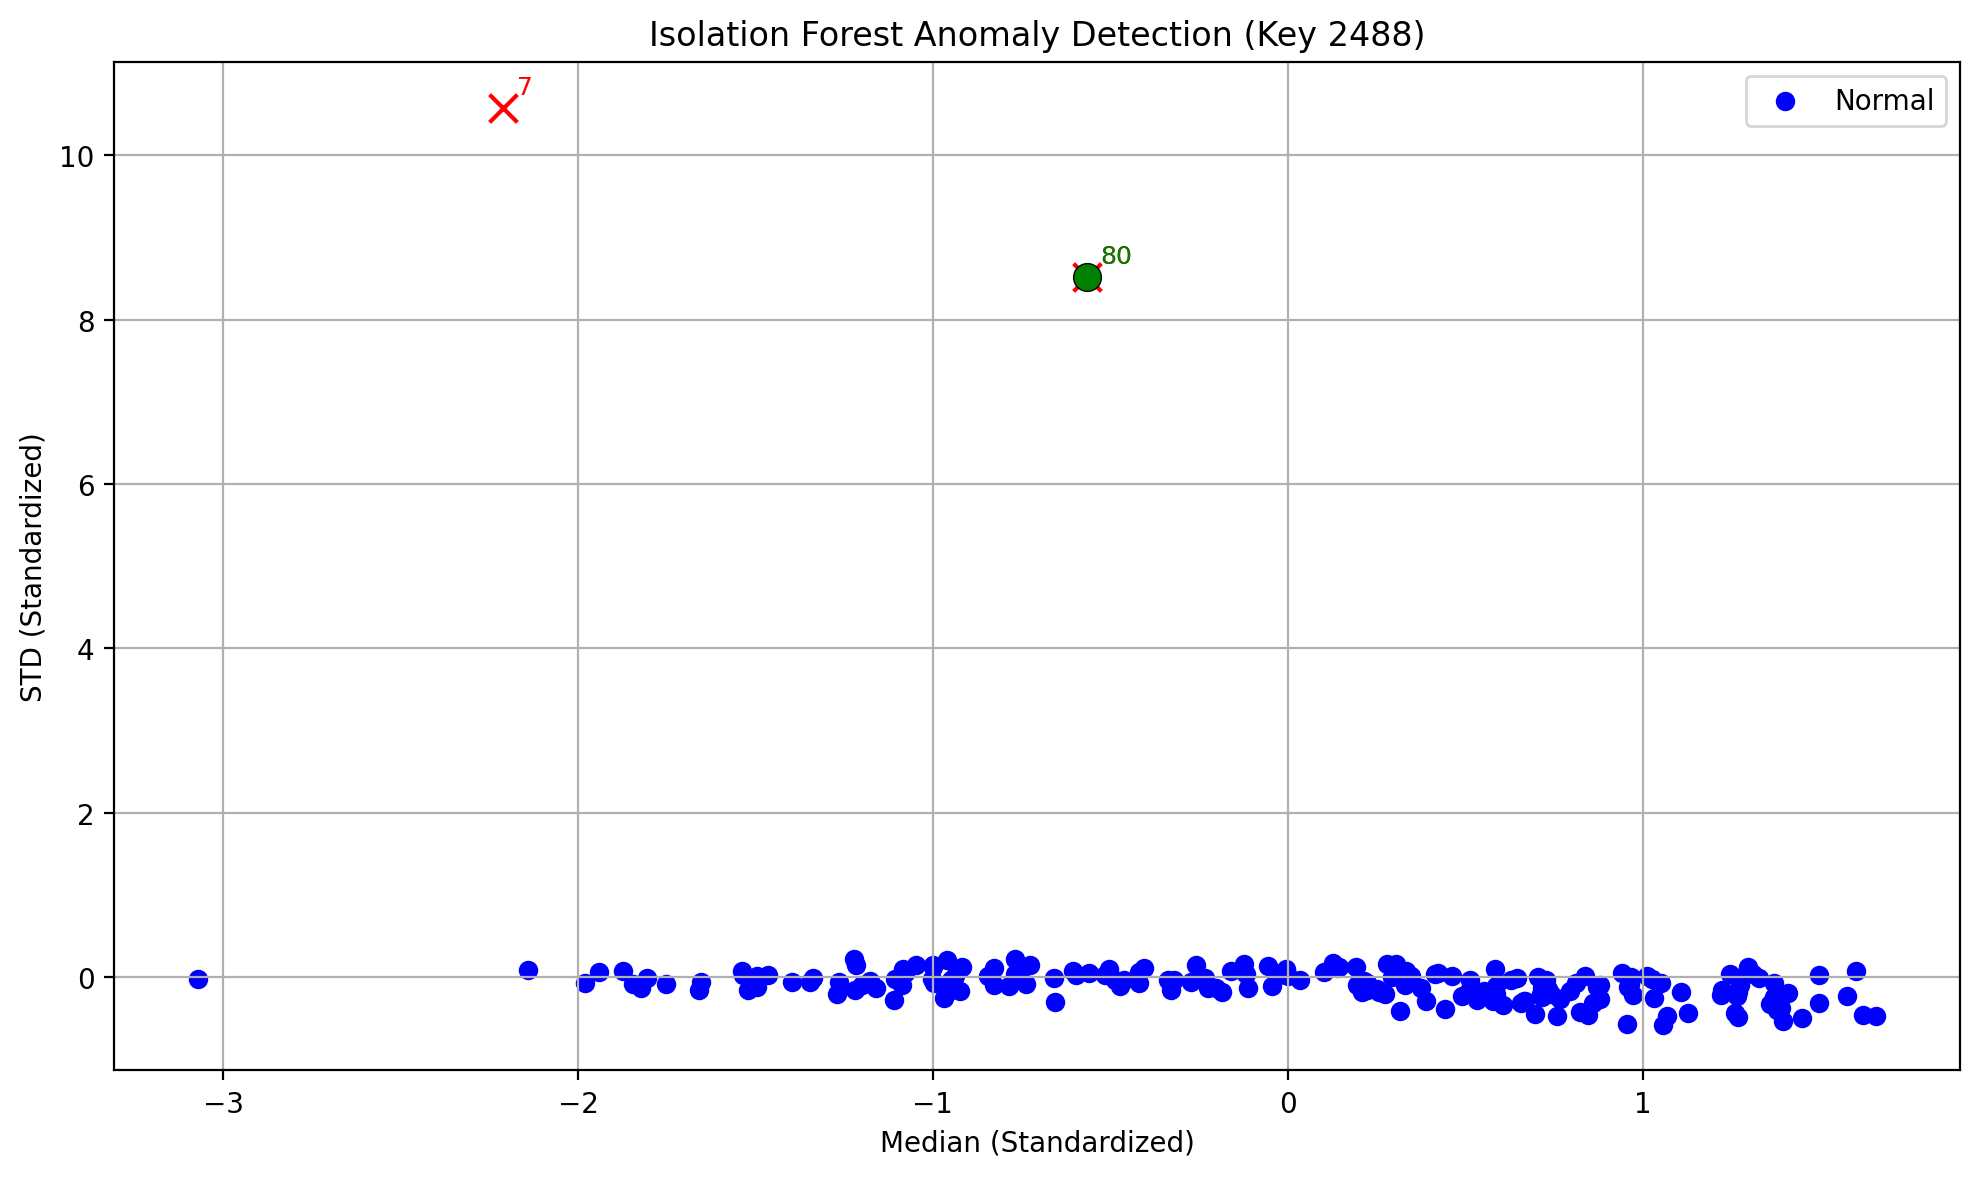

Anomalous sites detected for Key 2488:
[7, 80]


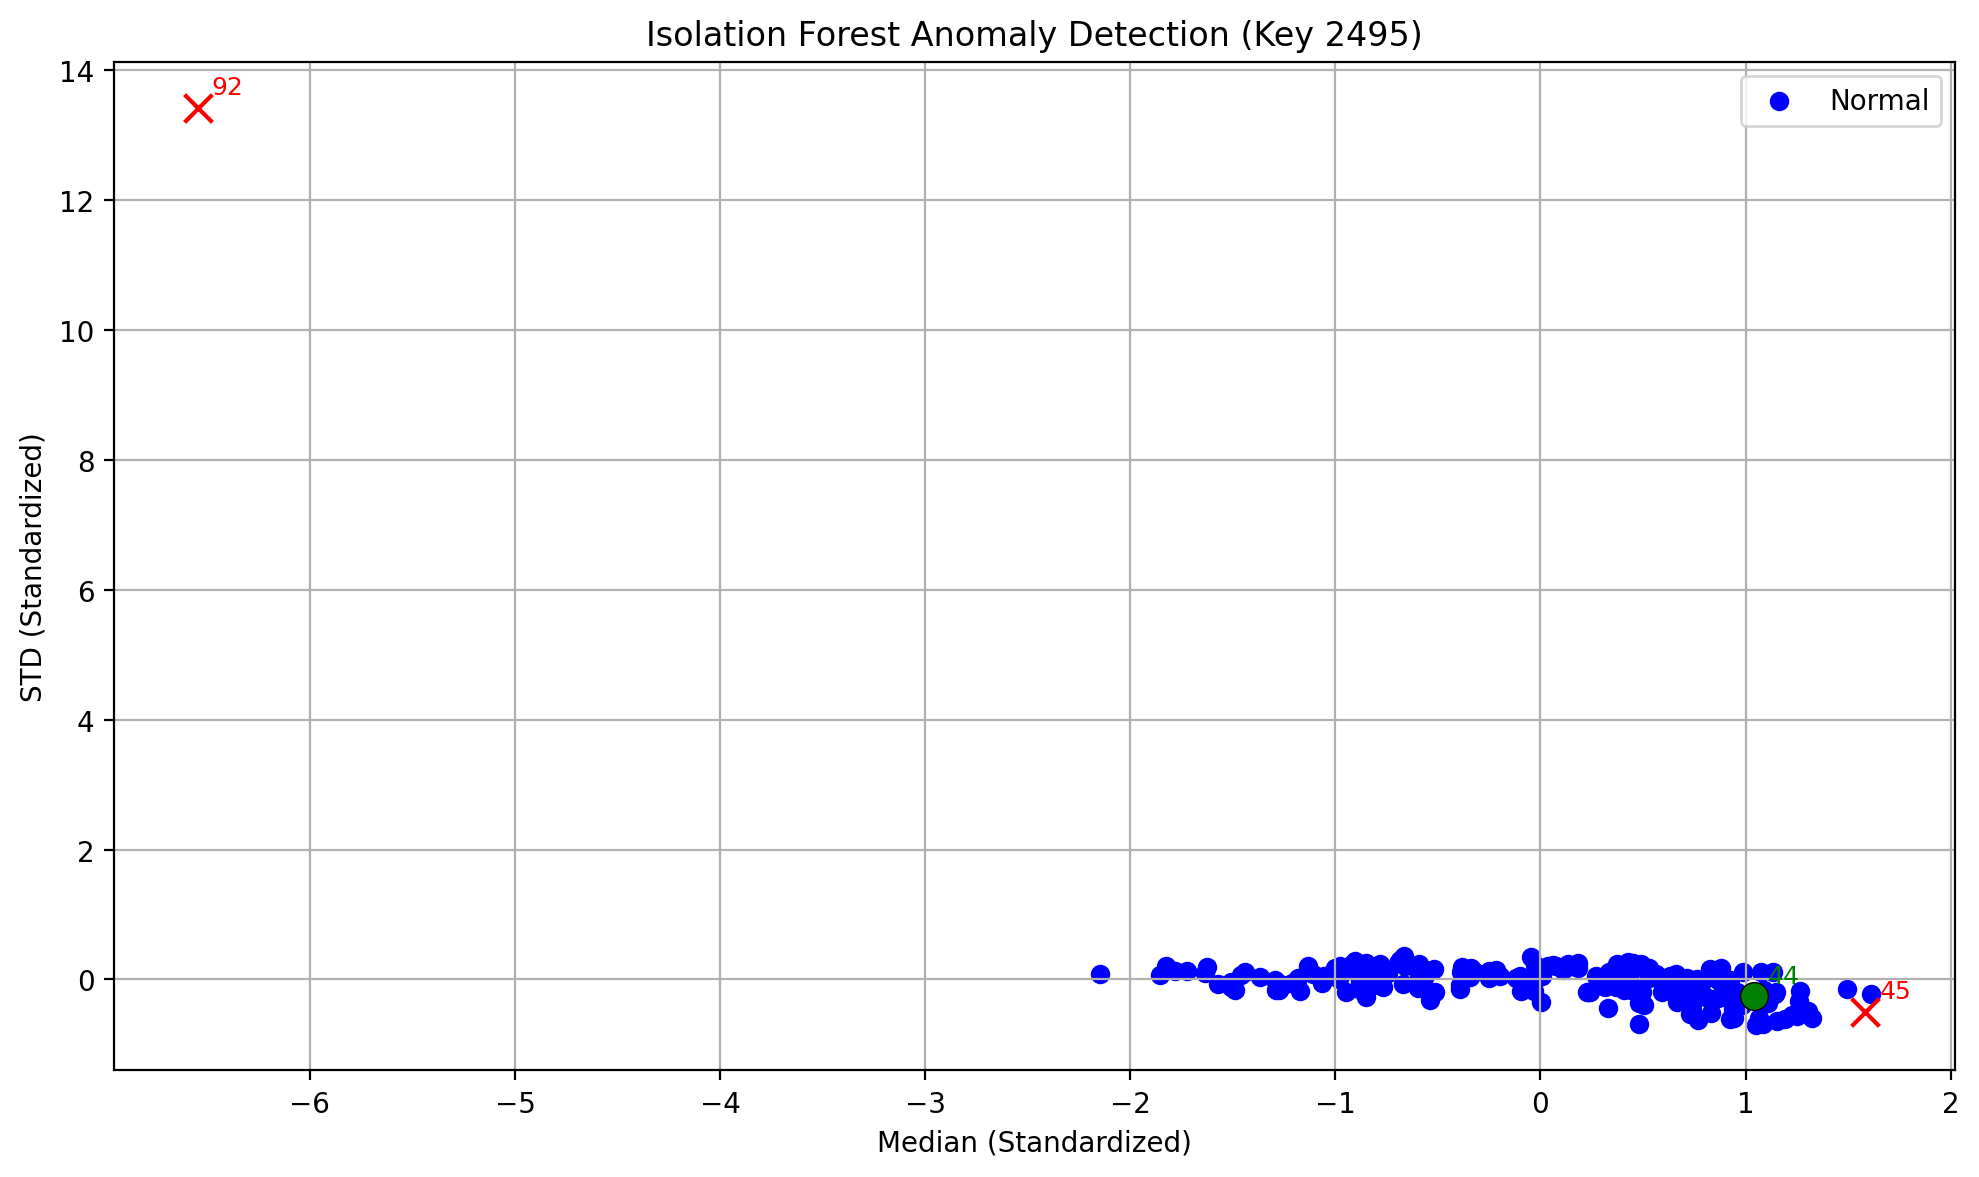

Anomalous sites detected for Key 2495:
[45, 92]


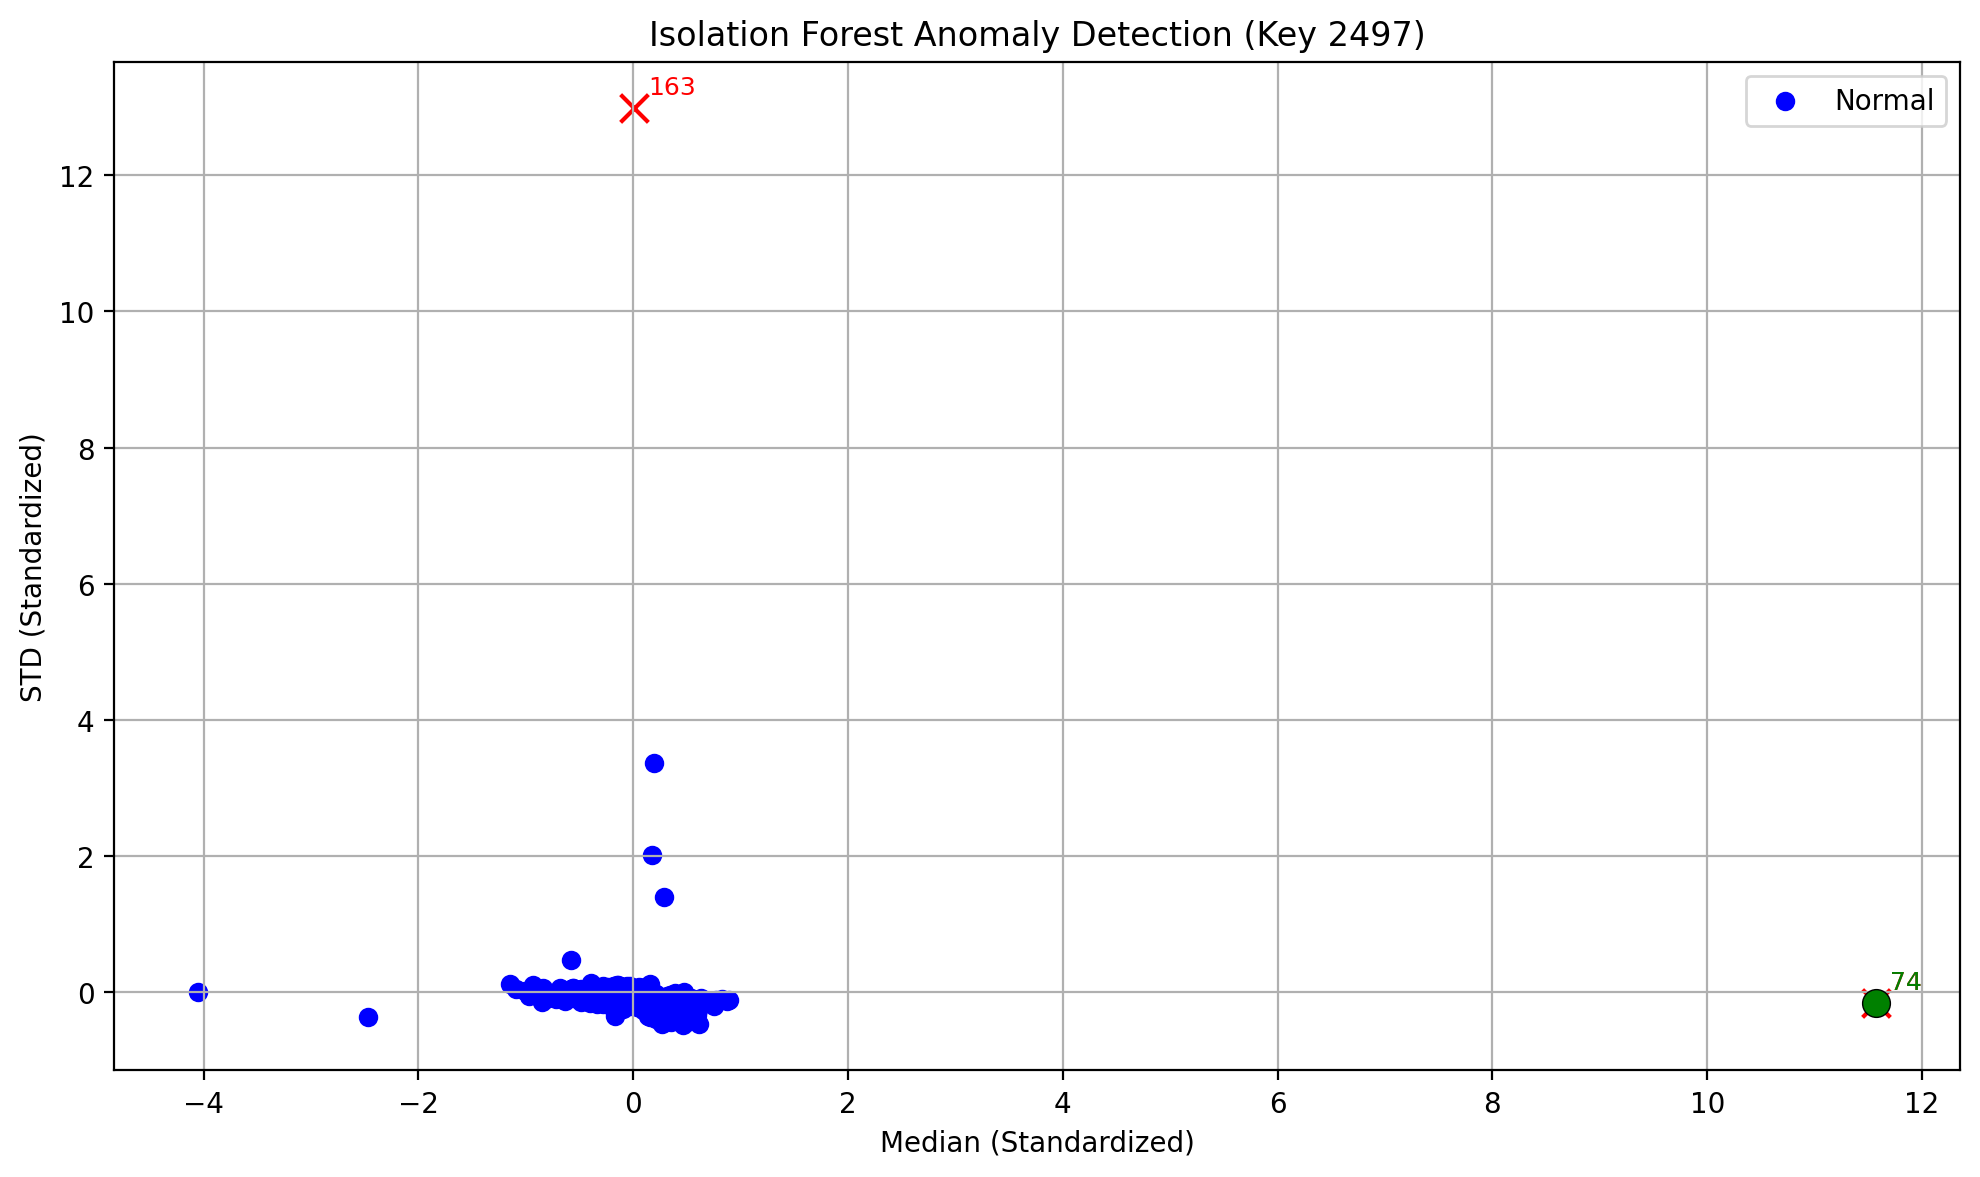

Anomalous sites detected for Key 2497:
[74, 163]


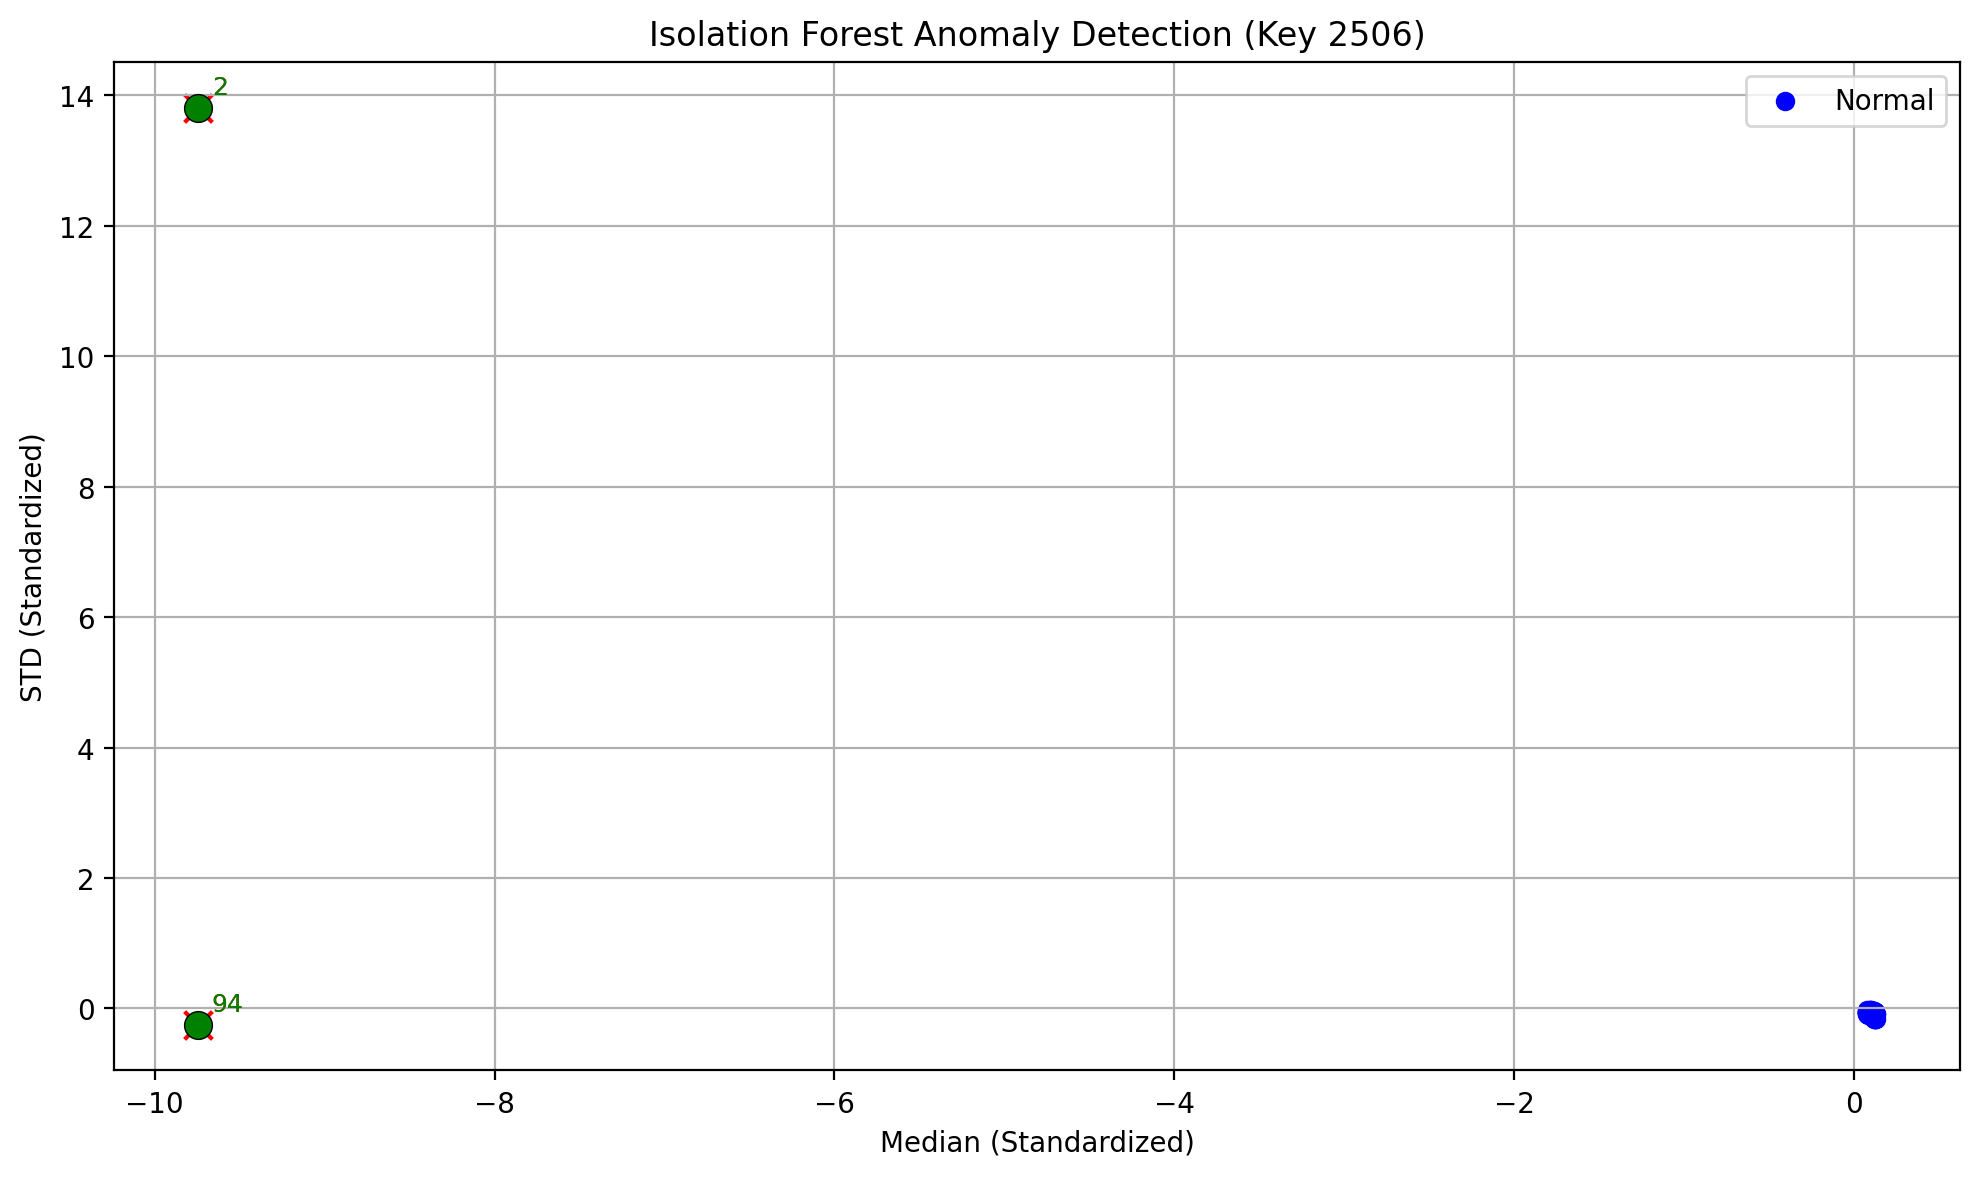

Anomalous sites detected for Key 2506:
[2, 94]


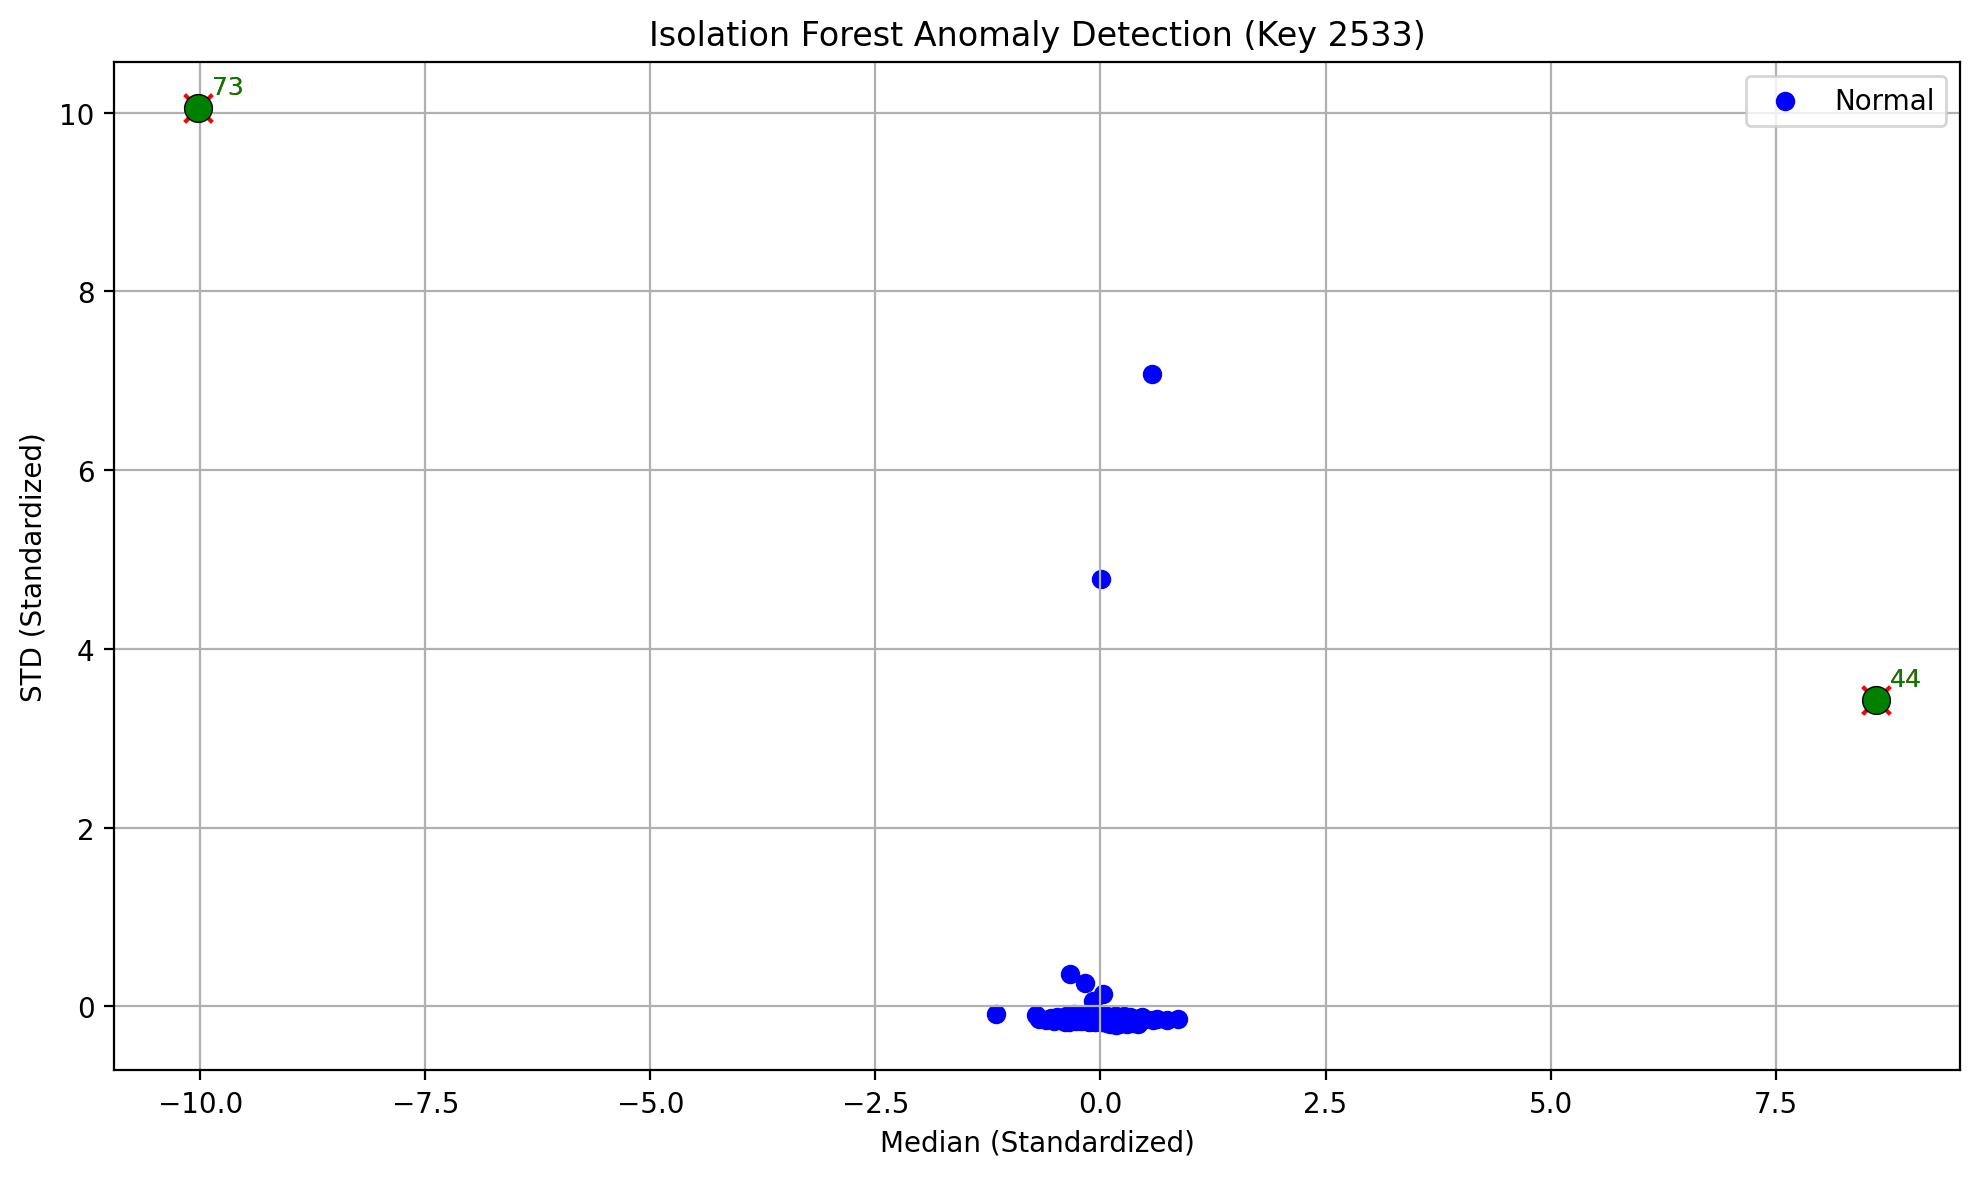

Anomalous sites detected for Key 2533:
[44, 73]


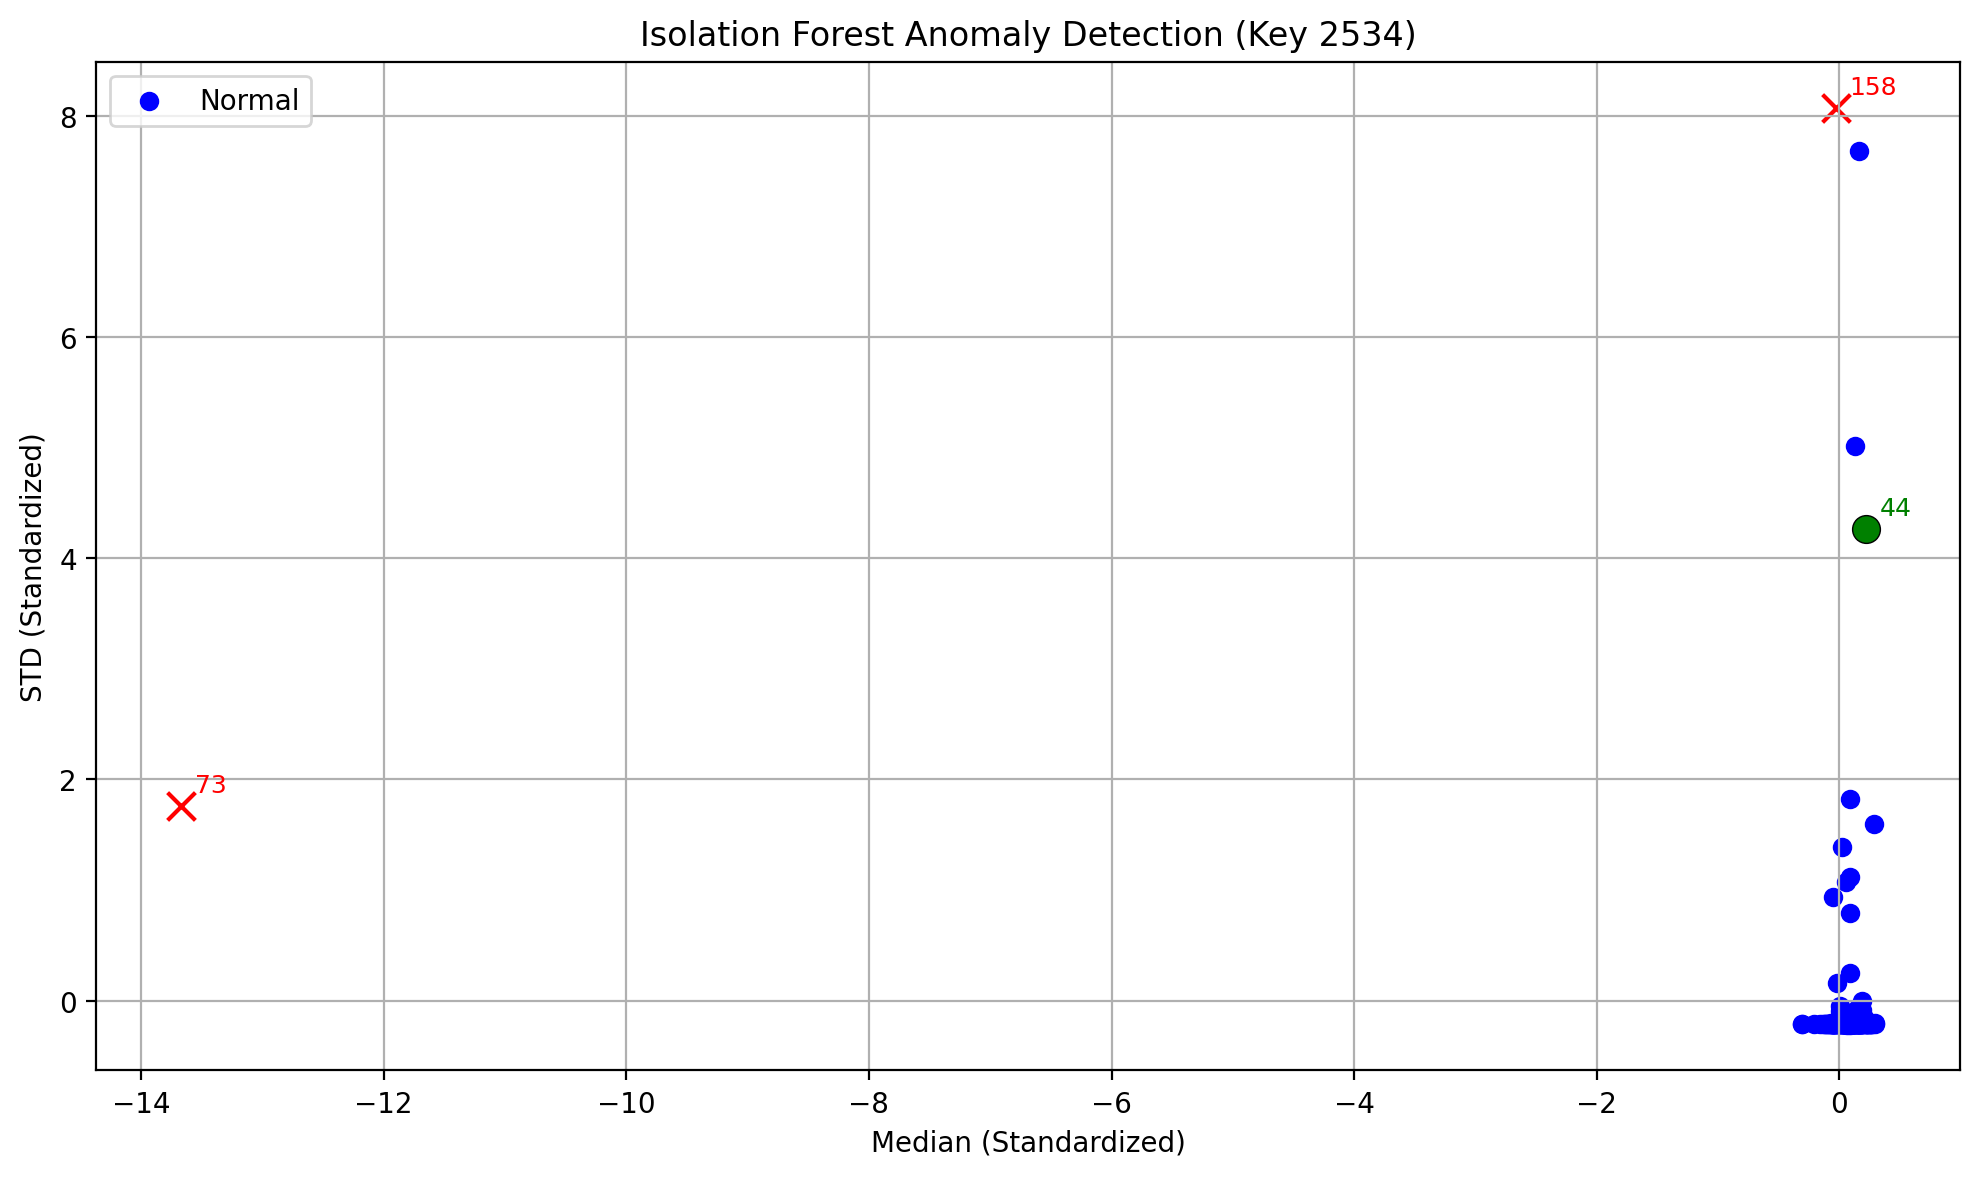

Anomalous sites detected for Key 2534:
[73, 158]


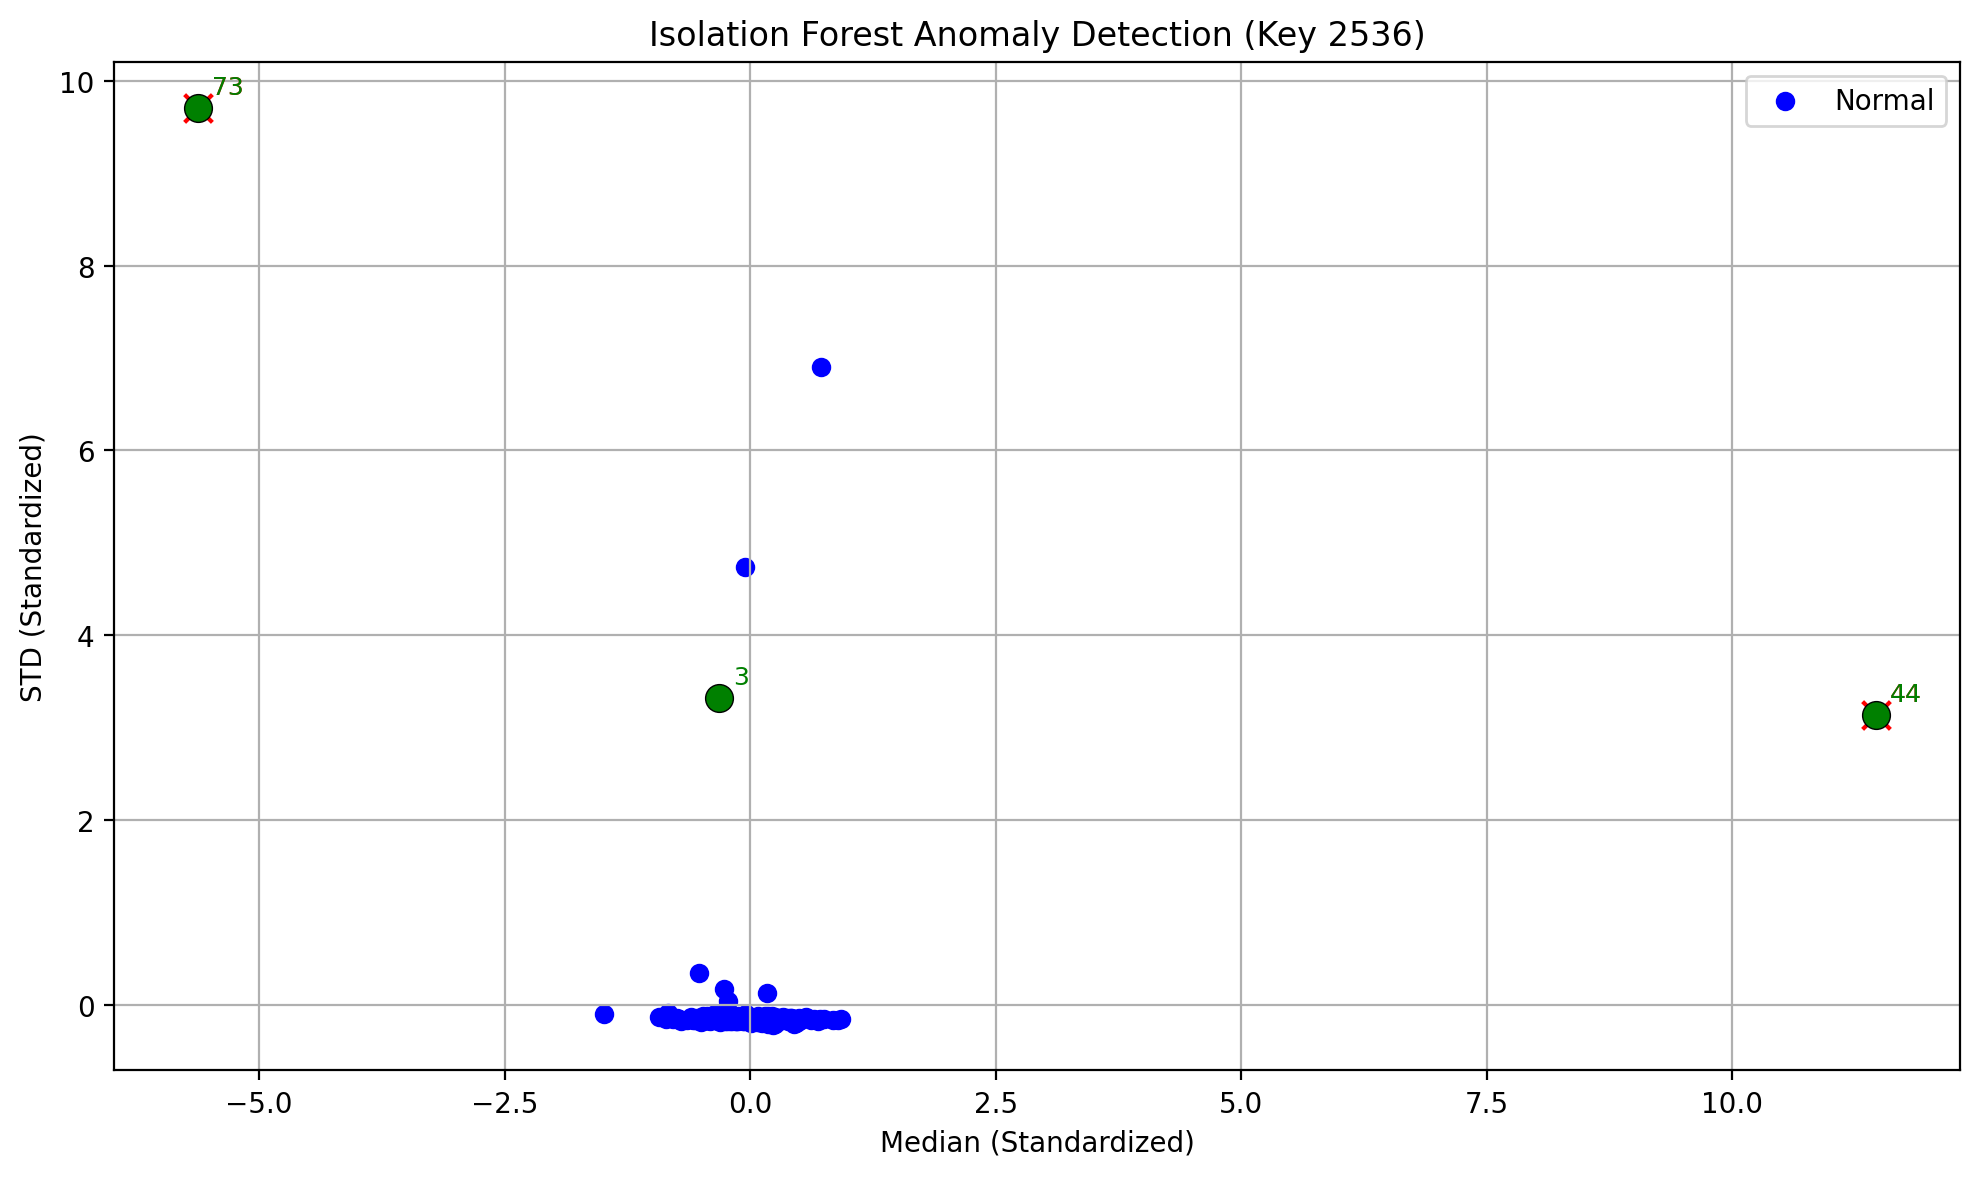

Anomalous sites detected for Key 2536:
[44, 73]


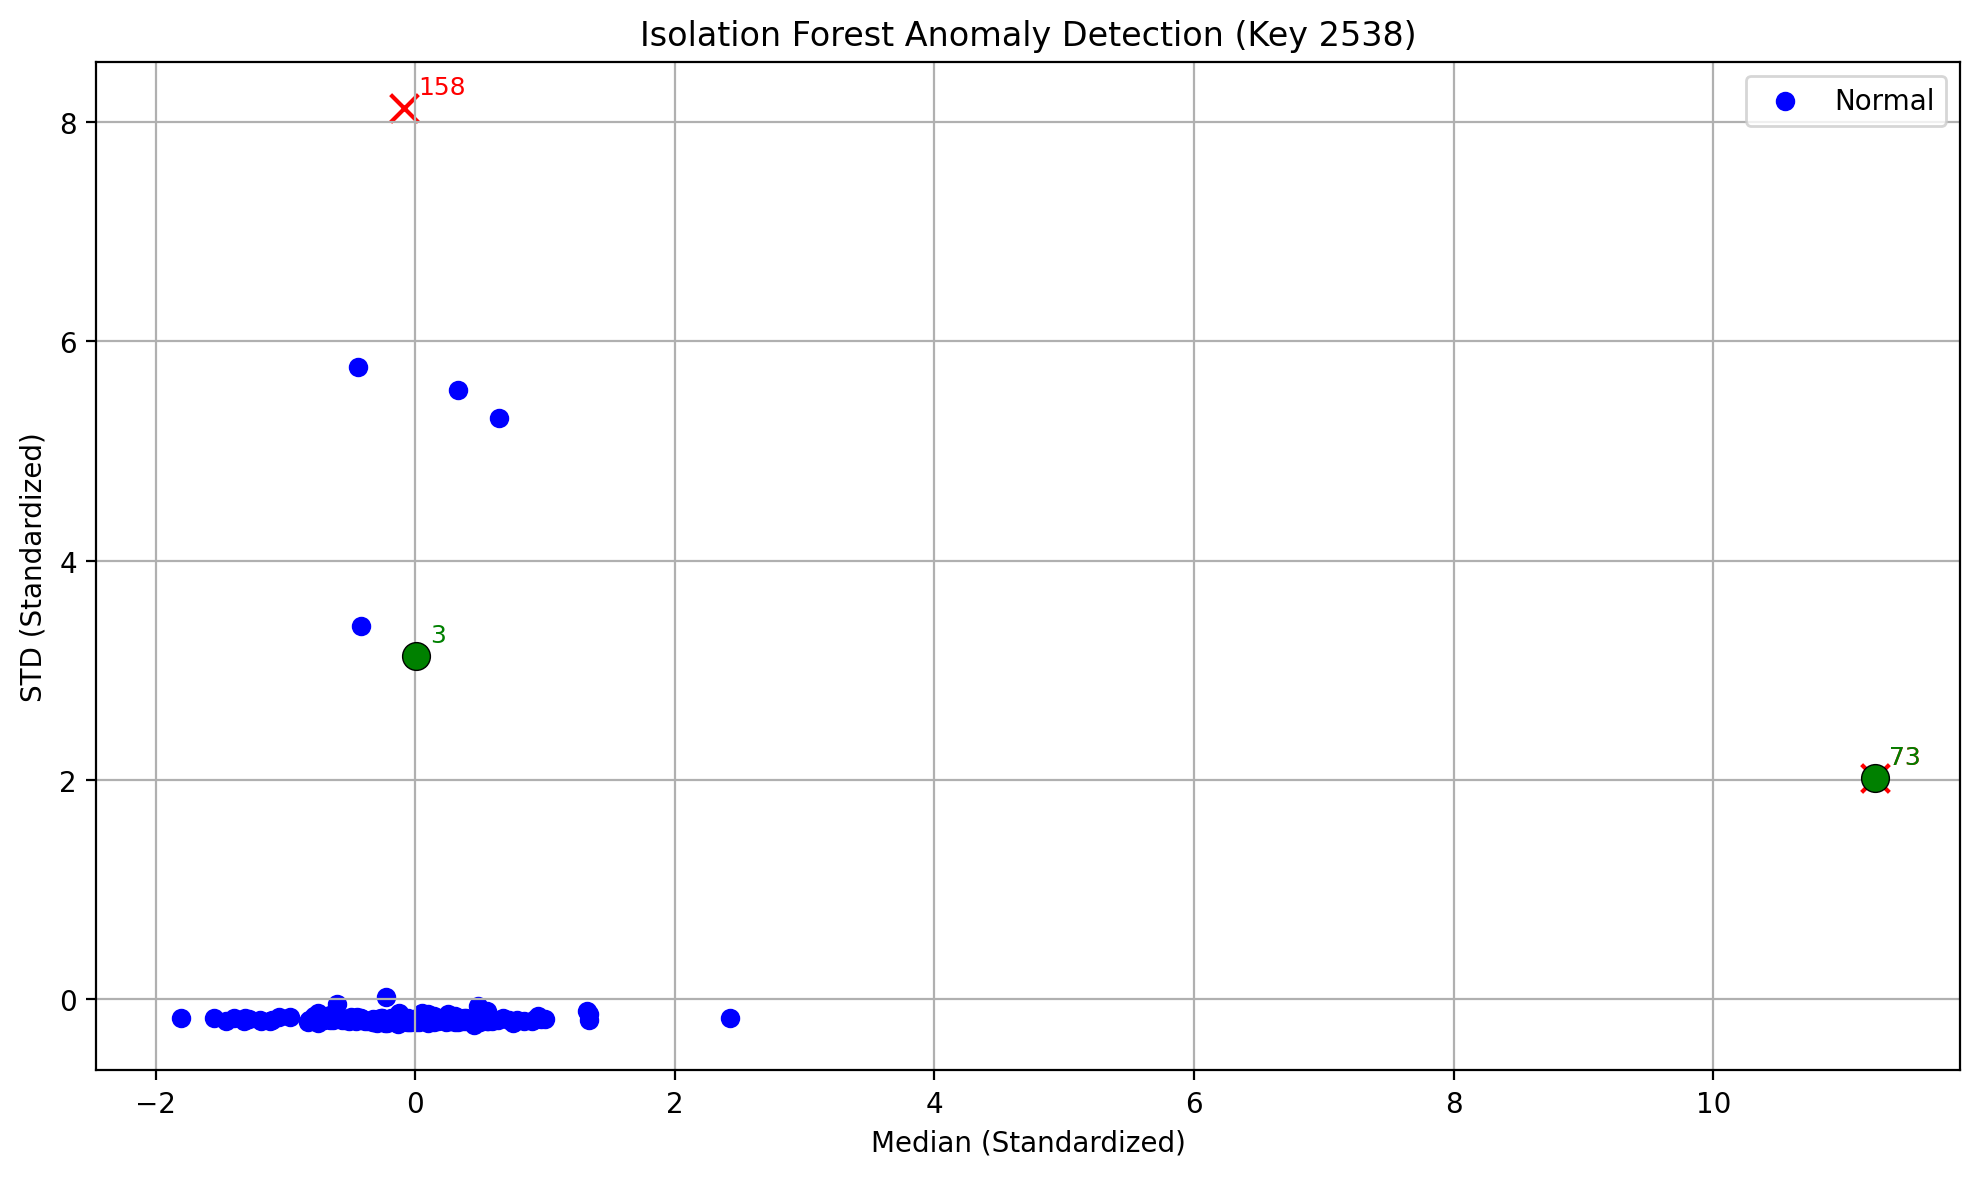

Anomalous sites detected for Key 2538:
[73, 158]


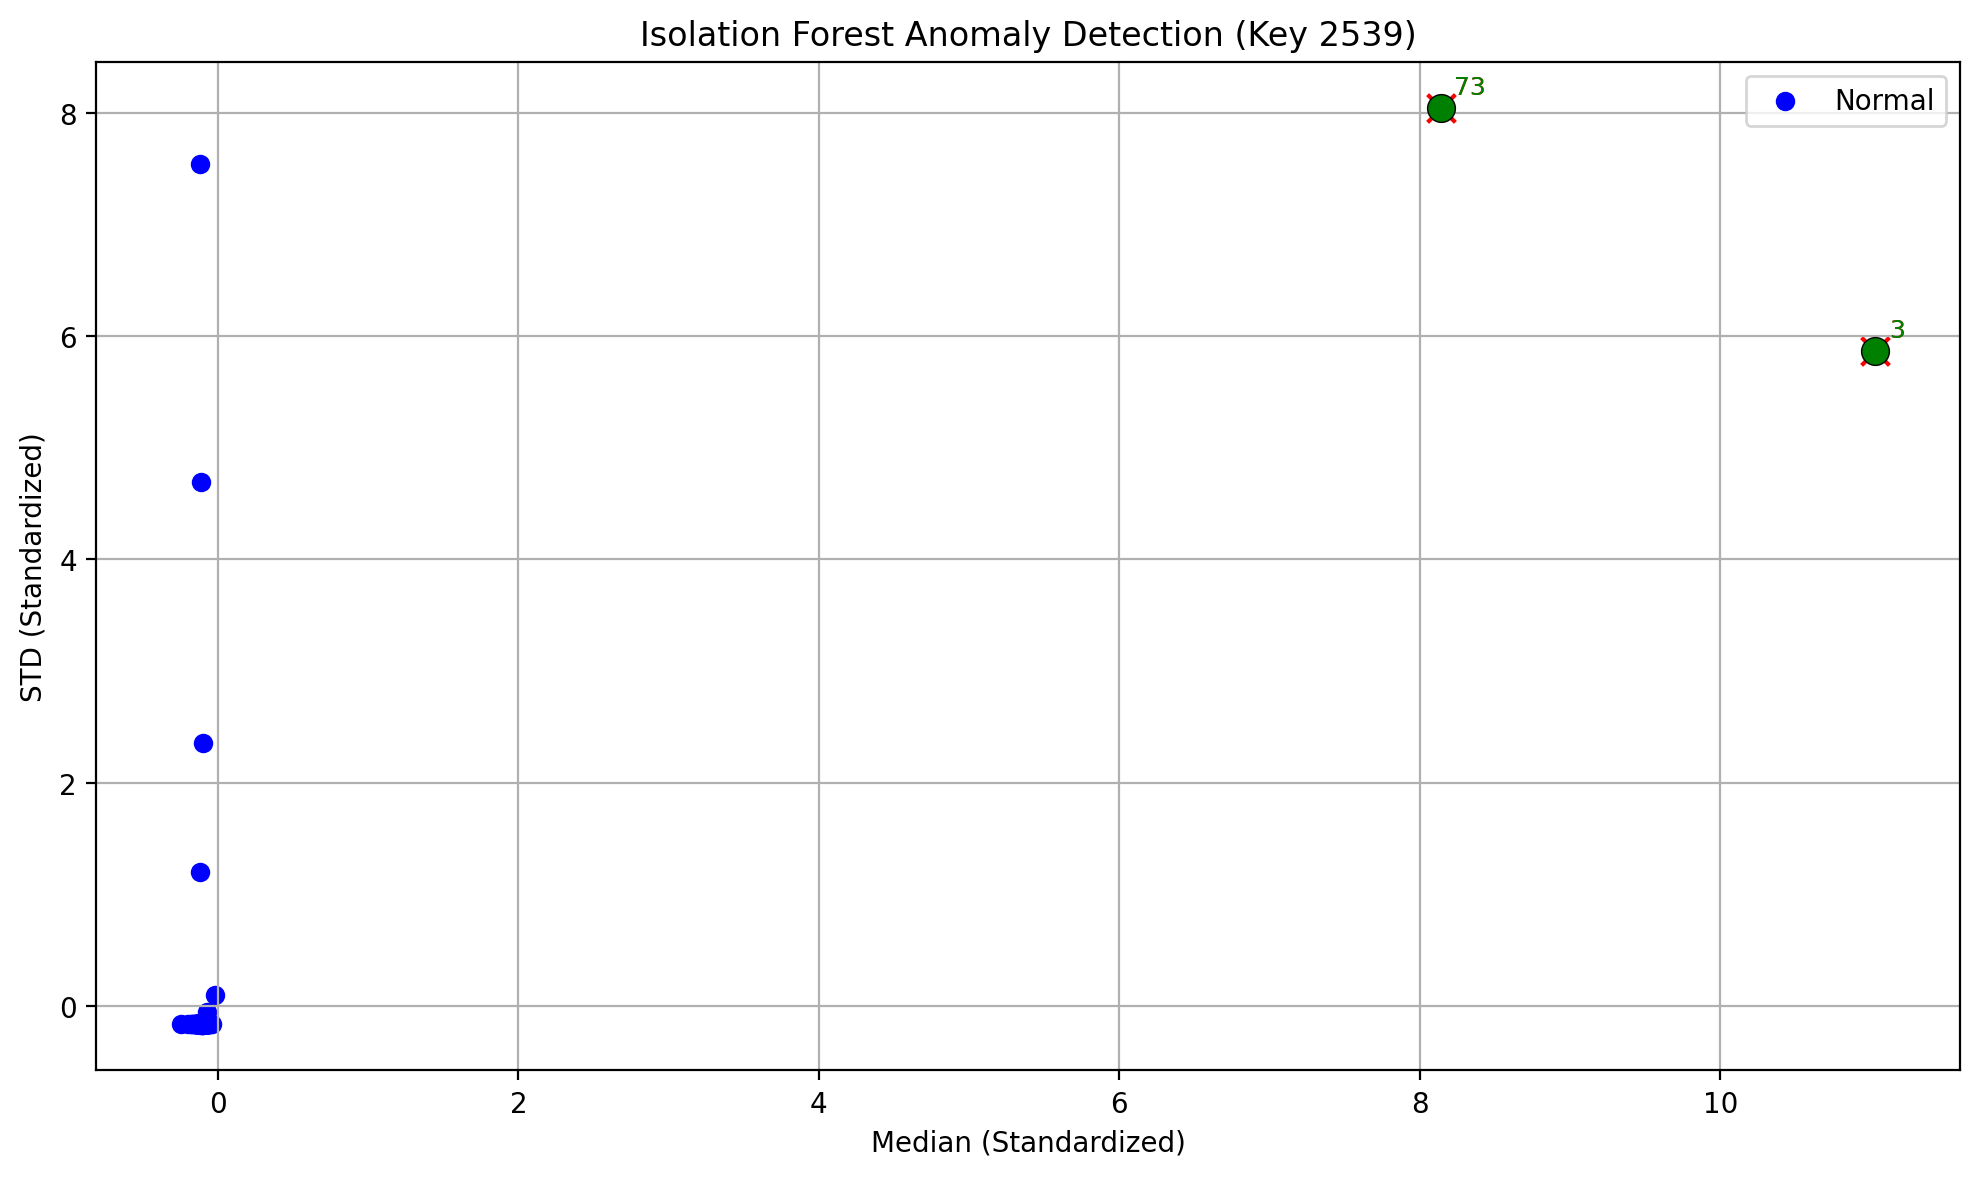

Anomalous sites detected for Key 2539:
[3, 73]


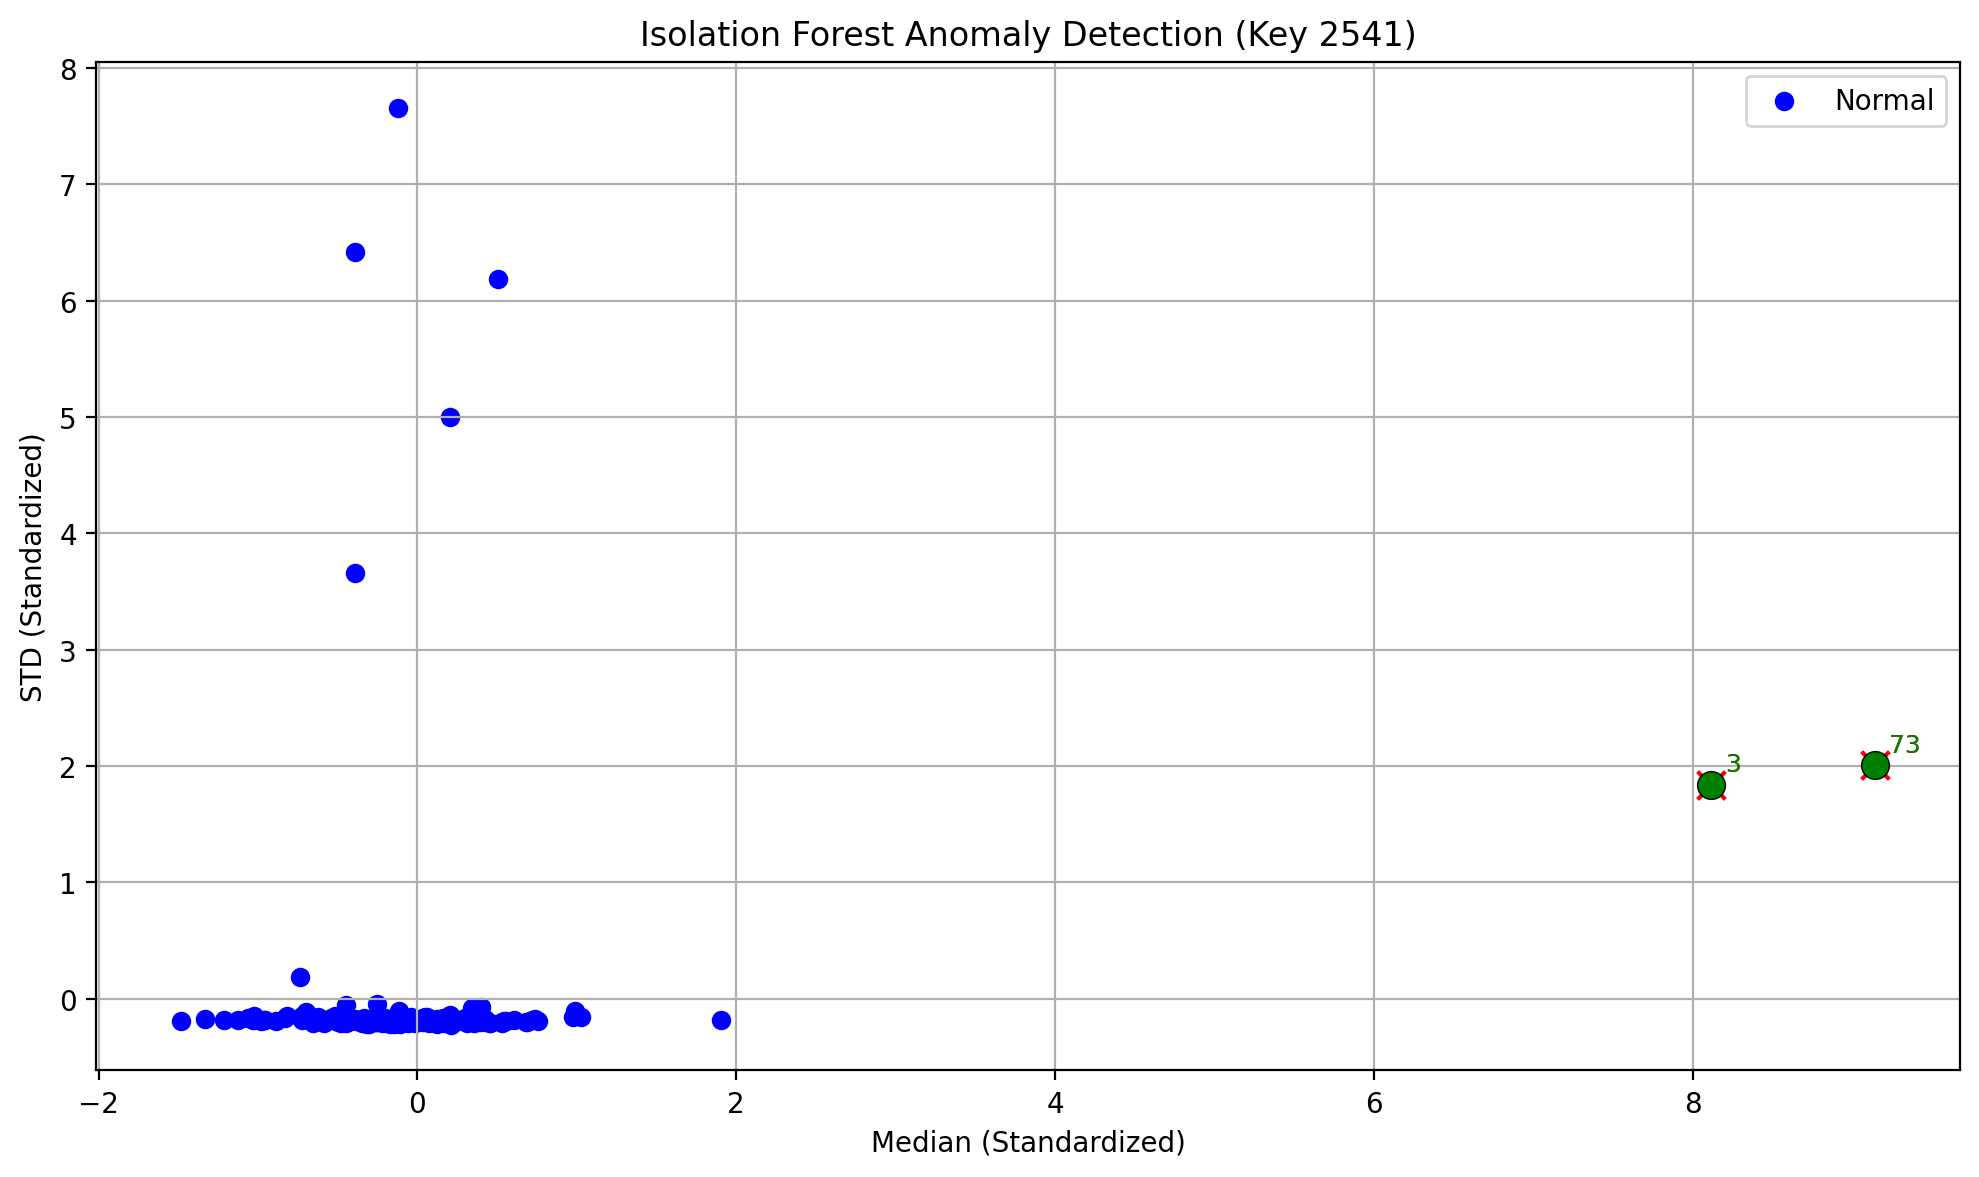

Anomalous sites detected for Key 2541:
[3, 73]


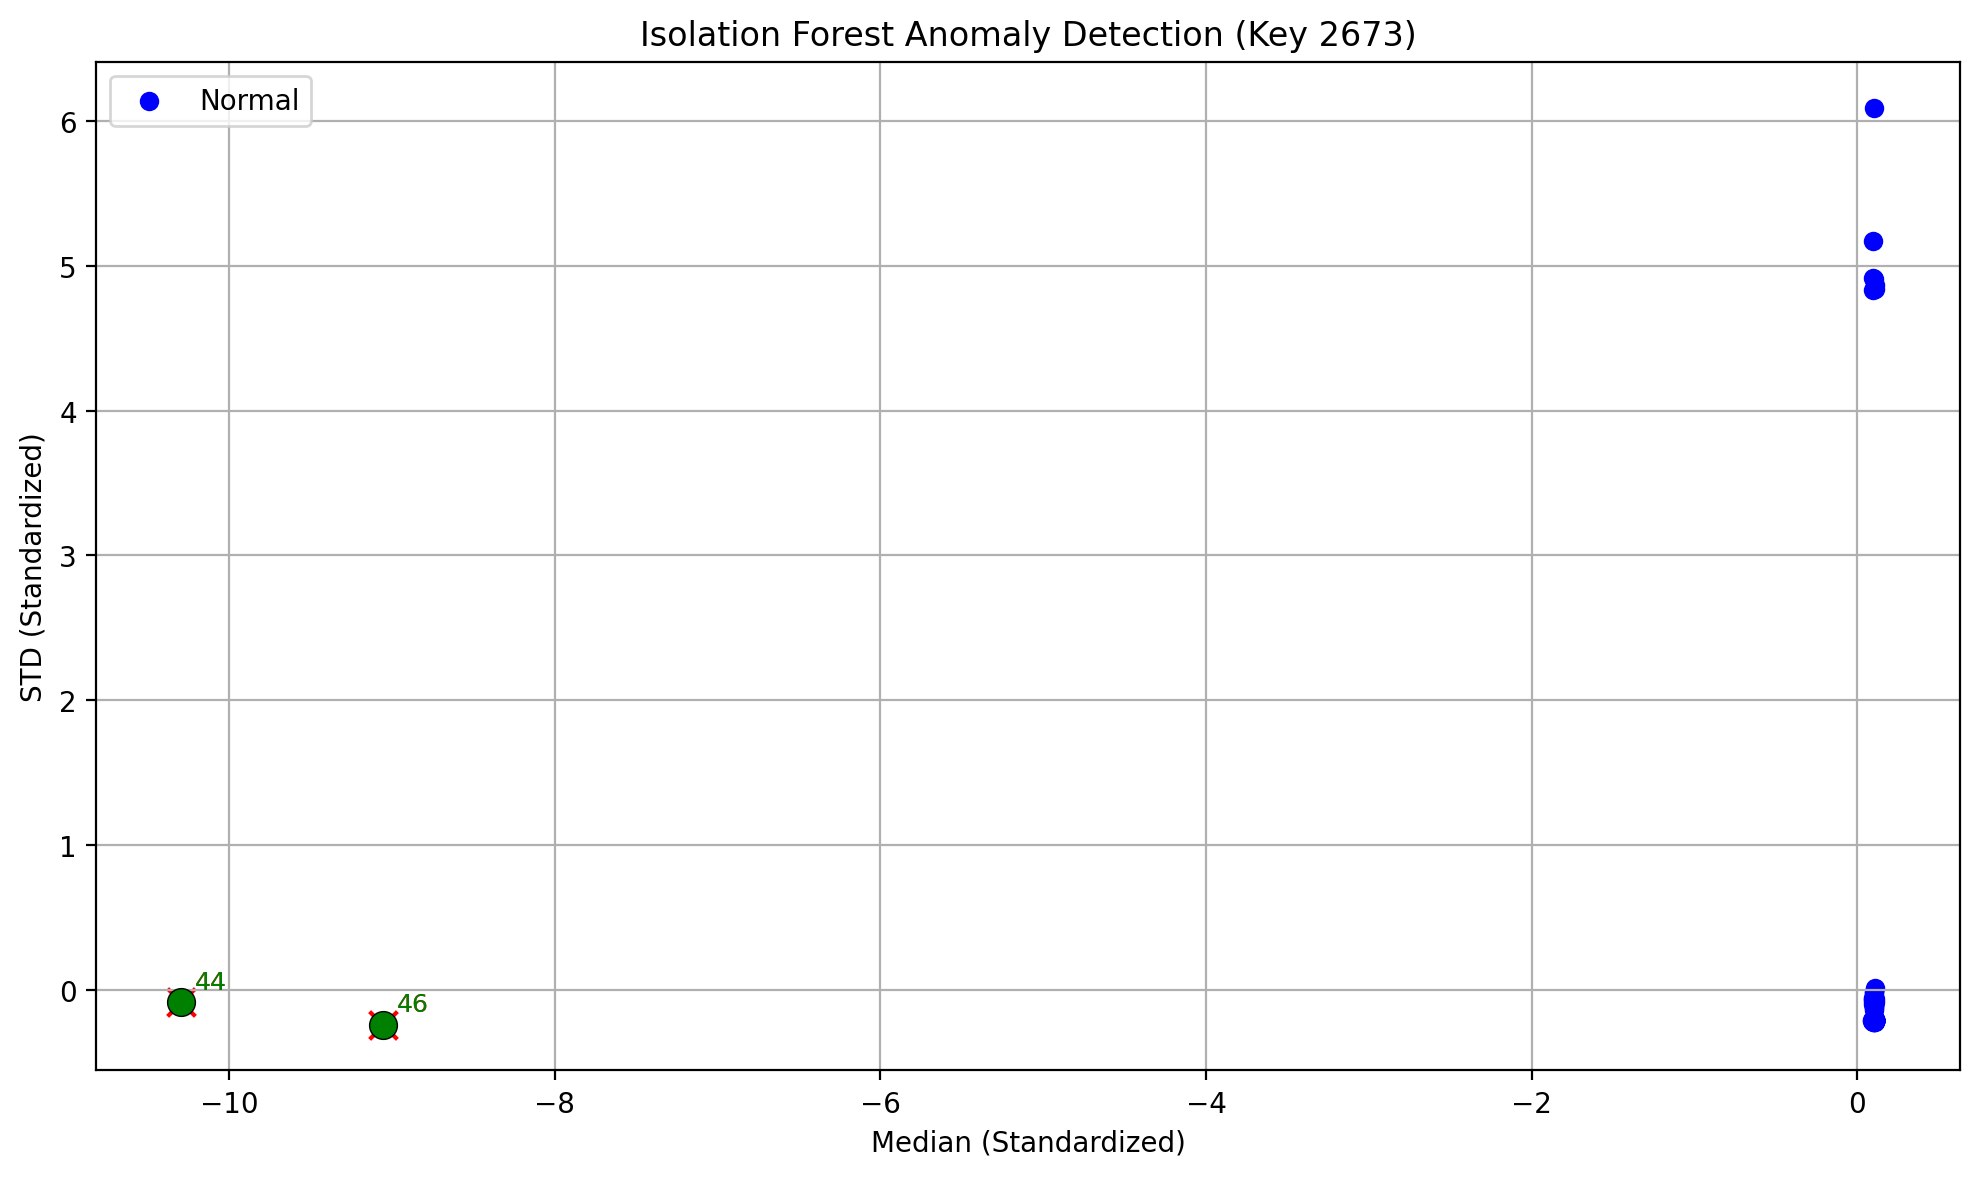

Anomalous sites detected for Key 2673:
[44, 46]


In [16]:
# Loop through each position and visualize
for position, key in indices_with_missed:
    param_med = z_med.iloc[position, :]
    param_std = z_std.iloc[position, :]
    data = pd.concat([param_med, param_std], axis=1)
    data.columns = ['med', 'std']

    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=0.0065, random_state=42)
    data['anomaly'] = iso_forest.fit_predict(data[['med', 'std']])

    # Plotting
    plt.figure(figsize=(10, 6))
    normal = data[data['anomaly'] == 1]
    anomalies = data[data['anomaly'] == -1]

    plt.scatter(normal['med'], normal['std'], c='blue', label='Normal')

    # Red Xs for anomalies
    for site, row in anomalies.iterrows():
        plt.scatter(row['med'], row['std'], c='red', marker='x', s=100)
        plt.annotate(str(site), (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='red')

    # Green dots for matched and missed sites
    if key in comparison_summary:
        for site in comparison_summary[key].get('matched', []):
            site = int(site)
            if site in data.index:
                row = data.loc[site]
                plt.scatter(row['med'], row['std'], c='green', marker='o', s=100, edgecolors='black', linewidths=0.5, zorder=5)
                plt.annotate(site, (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='green')

        for site in comparison_summary[key].get('missed', []):
            site = int(site)
            if site in data.index:
                row = data.loc[site]
                plt.scatter(row['med'], row['std'], c='green', marker='o', s=100, edgecolors='black', linewidths=0.5, zorder=5)
                plt.annotate(site, (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='green')

    plt.xlabel('Median (Standardized)')
    plt.ylabel('STD (Standardized)')
    plt.title(f'Isolation Forest Anomaly Detection (Key {key})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print anomalous site names
    print(f"Anomalous sites detected for Key {key}:")
    print(anomalies.index.tolist())

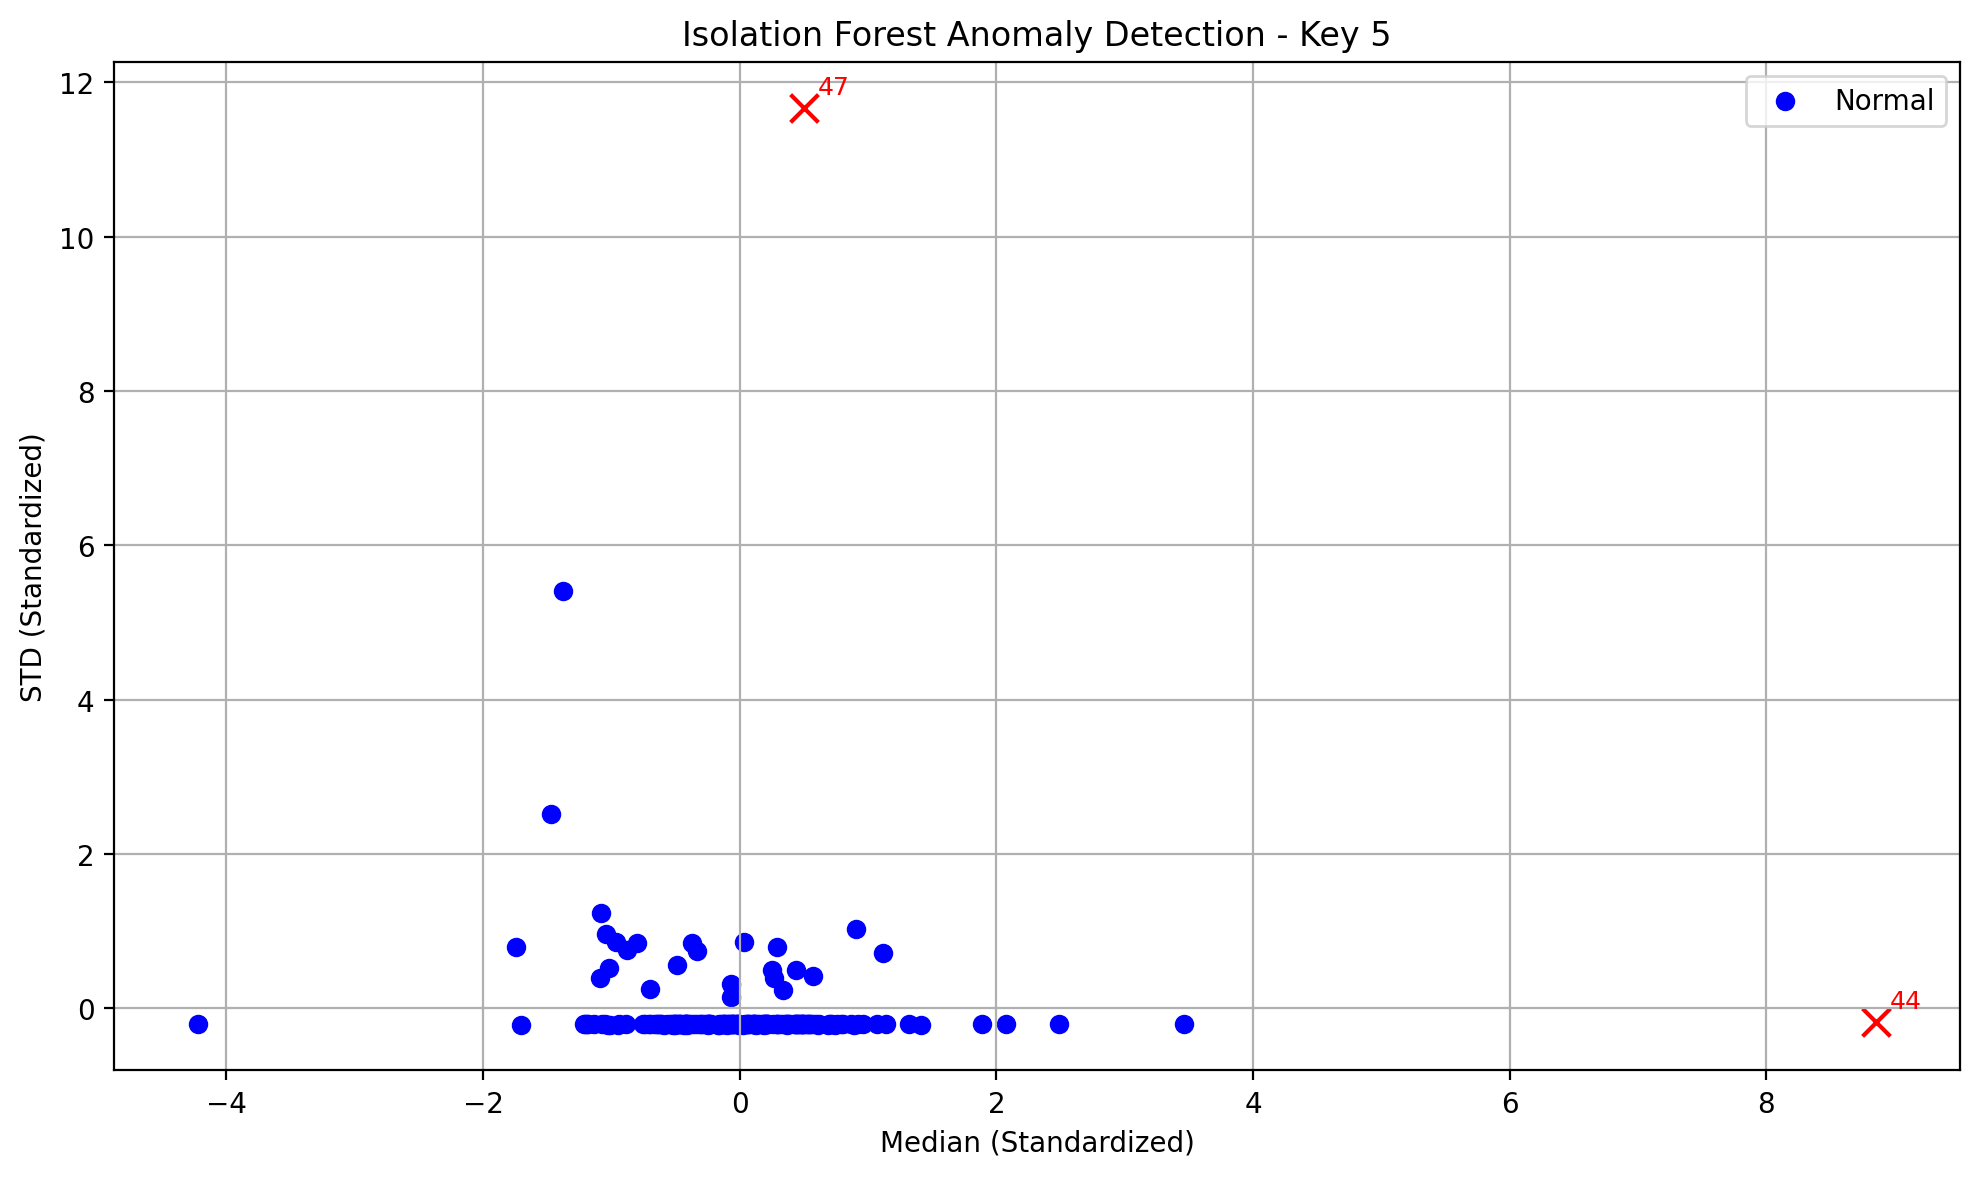

Anomalous sites detected for Position 1:
[44, 47]


In [17]:
def plot_anomalies_for_position(position, z_med, z_std, all_indices, comparison_summary=None):
    key = all_indices[position][1]
    param_med = z_med.iloc[position, :]
    param_std = z_std.iloc[position, :]
    data = pd.concat([param_med, param_std], axis=1)
    data.columns = ['med', 'std']

    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=0.0065, random_state=42)
    data['anomaly'] = iso_forest.fit_predict(data[['med', 'std']])

    # Plotting
    plt.figure(figsize=(10, 6))
    normal = data[data['anomaly'] == 1]
    anomalies = data[data['anomaly'] == -1]

    plt.scatter(normal['med'], normal['std'], c='blue', label='Normal')

    # Red Xs for false positives
    for site, row in anomalies.iterrows():
        plt.scatter(row['med'], row['std'], c='red', marker='x', s=100)
        plt.annotate(str(site), (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='red')

    # Green dots and red Xs for matched, green dots for missed
    if comparison_summary and key and key in comparison_summary:
        for site in comparison_summary[key].get('matched', []):
            if str(site) in data.index.astype(str):
                row = data.loc[int(site)]
                plt.scatter(row['med'], row['std'], c='green', marker='o', s=100)
                plt.scatter(row['med'], row['std'], c='red', marker='x', s=100)
                plt.annotate(site, (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='green')

        for site in comparison_summary[key].get('missed', []):
            if str(site) in data.index.astype(str):
                row = data.loc[int(site)]
                plt.scatter(row['med'], row['std'], c='green', marker='o', s=100)
                plt.annotate(f'site{site}', (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='green')

    plt.xlabel('Median (Standardized)')
    plt.ylabel('STD (Standardized)')
    title = f'Isolation Forest Anomaly Detection'
    if key:
        title += f' - Key {key}'
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Anomalous sites detected for Position {position}:")
    print(anomalies.index.tolist())


plot_anomalies_for_position(1, z_med, z_std, all_indices, comparison_summary)

In [ ]:
from collections import Counter

all_sites = [site for sites in anomalies_dict.values() for site in sites]

# Count occurrences of each site
site_counts = Counter(all_sites)

# Sort by frequency in descending order
sorted_site_counts = dict(sorted(site_counts.items(), key=lambda item: item[1], reverse=True))

# Display the result
print(sorted_site_counts)


{44: 327, 158: 85, 134: 46, 97: 41, 100: 38, 74: 21, 20: 20, 2: 18, 130: 18, 36: 14, 73: 14, 52: 10, 77: 8, 9: 8, 3: 8, 182: 7, 168: 7, 96: 6, 40: 5, 80: 5, 179: 4, 55: 4, 64: 4, 47: 4, 115: 3, 14: 3, 177: 3, 114: 3, 45: 3, 92: 3, 46: 3, 90: 2, 142: 2, 98: 2, 16: 2, 63: 2, 42: 2, 173: 2, 175: 2, 56: 2, 19: 2, 15: 2, 7: 2, 147: 2, 163: 2, 94: 2, 32: 2, 136: 1, 21: 1, 111: 1, 28: 1, 99: 1, 139: 1, 101: 1, 117: 1, 119: 1, 110: 1, 137: 1, 61: 1, 125: 1, 66: 1, 165: 1, 102: 1, 108: 1, 162: 1, 156: 1}
